In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
import itertools
import random
import pickle
from tqdm import tqdm
import time
from operator import itemgetter
import gc
from scipy.stats import skew, kurtosis, sem
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import xgboost as xgb
import tensorflow as tf
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from scipy.stats import t
from scipy.stats import norm

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(2025)

## Data importing and basic cleaning

In [4]:
def import_index_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

In [5]:
ticker = ['BTC-USD']
start_date = '2015-01-01'
end_date = '2023-12-31'

In [6]:
btc_df = import_index_data(ticker, start_date, end_date)
btc_df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800
...,...,...,...,...,...
2023-12-26,42520.402344,43603.175781,41676.488281,43599.847656,30026850982
2023-12-27,43442.855469,43683.160156,42167.582031,42518.468750,25260941032


In [7]:
btc_df.isna().any()

Price   Ticker 
Close   BTC-USD    False
High    BTC-USD    False
Low     BTC-USD    False
Open    BTC-USD    False
Volume  BTC-USD    False
dtype: bool

## Visualisation

In [14]:
btc_arima = btc_df.Close

In [15]:
def plot_series(df, name):
    
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df, label=name, color='blue')

    plt.title(name, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Close', fontsize=14)
    
    plt.gcf().autofmt_xdate()
    plt.grid(True)
    plt.legend()
    plt.show()

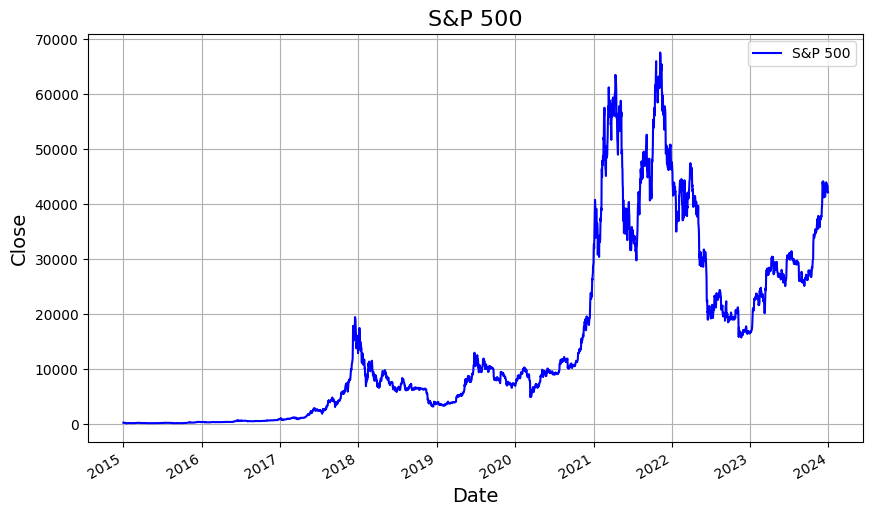

In [16]:
plot_series(btc_arima, 'S&P 500')

In [17]:
adfuller(btc_arima, maxlag = 1, regression = 'c', autolag = None)

(-1.0041266021162047,
 0.7517562438116856,
 1,
 3284,
 {'1%': -3.4323428193711396,
  '5%': -2.8624205094378947,
  '10%': -2.567238713568611})

In [18]:
def plot_log_returns(df, name):
    
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, np.log(df/df.shift(1)), label=name, color='blue')

    plt.title(name, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Returns', fontsize=14)
    
    plt.gcf().autofmt_xdate()
    plt.grid(True)
    plt.legend()
    plt.show()

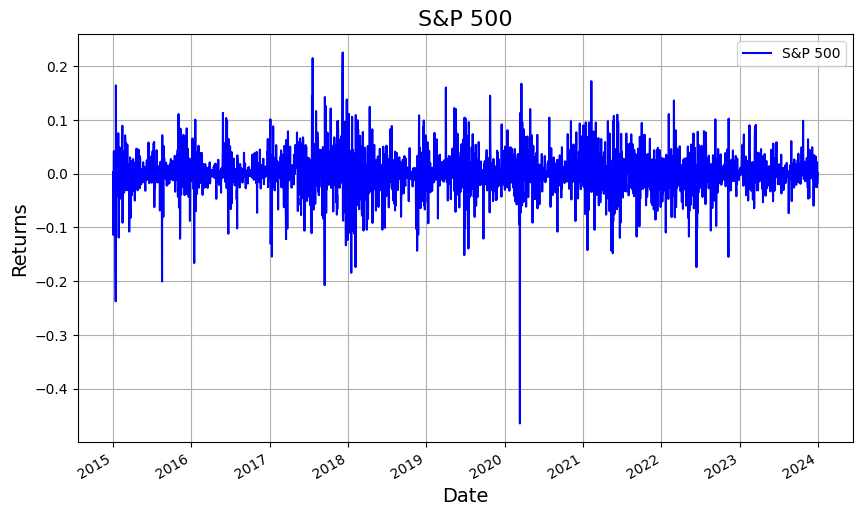

In [19]:
plot_log_returns(btc_arima, 'S&P 500')

In [20]:
adfuller((np.log(btc_arima/btc_arima.shift(1))).dropna(), maxlag = 1, regression = 'c', autolag = None)

(-40.544259803040845,
 0.0,
 1,
 3283,
 {'1%': -3.432343426858439,
  '5%': -2.8624207777608968,
  '10%': -2.567238856417868})

In [21]:
def plot_hist_log_returns(df, name):
    
    plt.figure(figsize=(10, 6))
    plt.hist(np.log(df/df.shift(1)), bins=25, alpha=0.8, edgecolor='black', label=name, color='blue')

    plt.title(name, fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Returns', fontsize=14)
    
    plt.gcf().autofmt_xdate()
    plt.grid(True)
    plt.legend()
    plt.show()

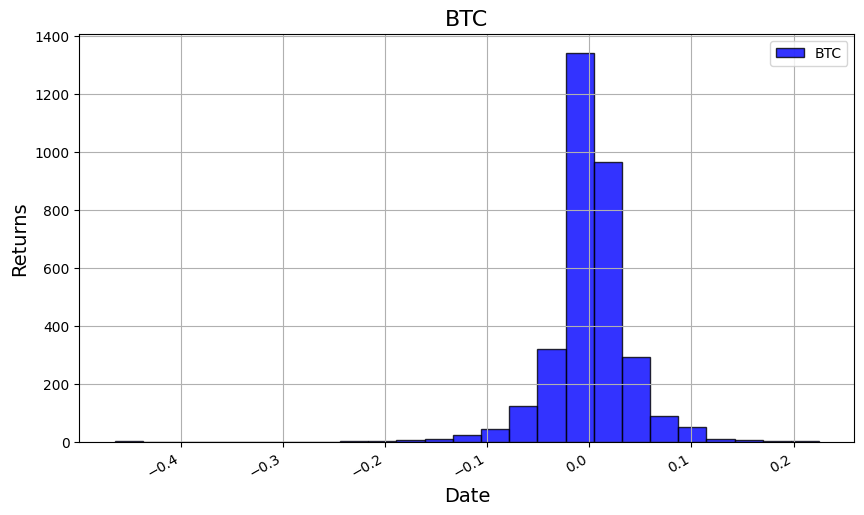

In [23]:
plot_hist_log_returns(btc_arima, 'BTC')

## Basic data description

In [24]:
def describe_data(df, name):
    
    print(f'Description of: {name}\n')

    print(f'Count: {df.count().round()}\n')
    
    print(f'Minimum value: {df.min().round(4)}')
    print(f'1st Quantile: {df.quantile(0.25).round(4)}')
    print(f'Median: {df.quantile(0.5).round(4)}')
    print(f'Mean value: {df.mean().round(4)}')
    print(f'3rd Quantile: {df.quantile(0.75).round(4)}')
    print(f'Maximum value: {df.max().round(4)}\n')

    print(f'Skewness: {skew(df).round(4)}')
    print(f'Kurtosis: {kurtosis(df).round(4)}')
    print(f'Standard Error: {sem(df).round(4)}')
    print(f'Standard Deviation: {df.std().round(4)}')

In [25]:
describe_data(btc_arima, 'BTC')

Description of: BTC

Count: 3286

Minimum value: 178.103
1st Quantile: 1187.825
Median: 8659.0205
Mean value: 15033.3409
3rd Quantile: 25153.1597
Maximum value: 67566.8281

Skewness: 1.1693
Kurtosis: 0.3766
Standard Error: 283.2641
Standard Deviation: 16237.7276


In [26]:
describe_data(np.log(btc_arima/btc_arima.shift(1)).dropna(), 'BTC Log Returns')

Description of: BTC Log Returns

Count: 3285

Minimum value: -0.4647
1st Quantile: -0.0122
Median: 0.0014
Mean value: 0.0015
3rd Quantile: 0.0169
Maximum value: 0.2251

Skewness: -0.7934
Kurtosis: 11.5991
Standard Error: 0.0007
Standard Deviation: 0.0374


## Framework for Cross Validation

In [171]:
btc_df.index[0]

Timestamp('2015-01-01 00:00:00')

In [172]:
new_df_lagged(btc_df, lag=7).index[0]

Timestamp('2015-01-09 00:00:00')

In [73]:
def CV_machine_expanding(df, train_years = 2, val_months = 12, test_months = 6):

    df = df.copy()
    df = df.dropna()
    df.index = pd.to_datetime(df.index)
    
    indices = []
    current_start_date = btc_df.index[0]

    while current_start_date <= pd.Timestamp('2023-01-01'):

        train_end_date = current_start_date + pd.DateOffset(years=train_years) - pd.Timedelta(days=1)
        val_start_date = train_end_date + pd.Timedelta(days=1)
        
        val_end_date_4m = val_start_date + pd.DateOffset(months=val_months/3) - pd.Timedelta(days=1)
        val_end_date_8m = val_start_date + pd.DateOffset(months=2*val_months/3) - pd.Timedelta(days=1)
        val_end_date_12m = val_start_date + pd.DateOffset(months=3*val_months/3) - pd.Timedelta(days=1)
        
        test_start_date = val_end_date_12m + pd.Timedelta(days=1)
        test_end_date = test_start_date + pd.DateOffset(months=test_months) - pd.Timedelta(days=1)

        if test_end_date > pd.Timestamp('2024-06-01'):
            break

        train_set = df.loc[current_start_date:train_end_date].index
        val_set_4m = df.loc[val_start_date:val_end_date_4m].index
        val_set_8m = df.loc[val_start_date:val_end_date_8m].index
        val_set_12m = df.loc[val_start_date:val_end_date_12m].index
        test_set = df.loc[test_start_date:test_end_date].index

        indices.append([train_set, [val_set_4m, val_set_8m, val_set_12m], test_set])

        current_start_date += pd.DateOffset(months=6)
    
    return indices

In [32]:
indices = CV_machine_expanding(btc_arima)

for i, window in enumerate(indices):
    print(f"Window {i+1}:")
    print("Training set:")
    print(btc_arima[window[0][:3]])
    print(btc_arima[window[0][-3:]])
    print("Validation set 1:")
    print(btc_arima[window[1][0][:3]])
    print(btc_arima[window[1][0][-3:]])
    print("Validation set 2:")
    print([window[1][1][:3]])
    print(btc_arima[window[1][1][-3:]])
    print("Validation set 3:")
    print(btc_arima[window[1][2][:3]])
    print(btc_arima[window[1][2][-3:]])
    print("Testing set:")
    print(btc_arima[window[2][:3]])
    print(btc_arima[window[2][-3:]])
    print("\n")

Window 1:
Training set:
Date
2015-01-01    314.248993
2015-01-02    315.032013
2015-01-03    281.082001
Name: Close, dtype: float64
Date
2016-12-29    973.497009
2016-12-30    961.237976
2016-12-31    963.742981
Name: Close, dtype: float64
Validation set 1:
Date
2017-01-01     998.325012
2017-01-02    1021.750000
2017-01-03    1043.839966
Name: Close, dtype: float64
Date
2017-04-28    1316.479980
2017-04-29    1321.790039
2017-04-30    1347.890015
Name: Close, dtype: float64
Validation set 2:
[DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03'], dtype='datetime64[ns]', name='Date', freq=None)]
Date
2017-08-29    4579.020020
2017-08-30    4565.299805
2017-08-31    4703.390137
Name: Close, dtype: float64
Validation set 3:
Date
2017-01-01     998.325012
2017-01-02    1021.750000
2017-01-03    1043.839966
Name: Close, dtype: float64
Date
2017-12-29    14656.200195
2017-12-30    12952.200195
2017-12-31    14156.400391
Name: Close, dtype: float64
Testing set:
Date
2018-01-01    13657.20

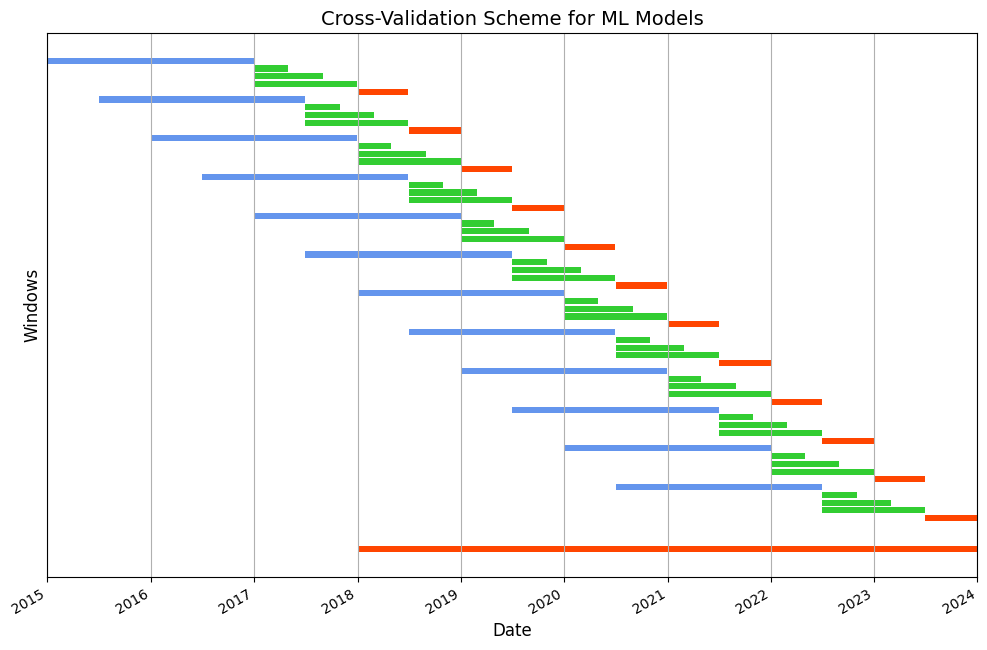

In [511]:
indices = CV_machine_expanding(btc_arima)

plot_data = []
testing_start_dates = []
testing_end_dates = []

for i, window in enumerate(indices):
    plot_data.append({
        'Type': 'Training',
        'StartDate': window[0][0],
        'EndDate': window[0][-1]
    })
    plot_data.append({
        'Type': 'Validation 1',
        'StartDate': window[1][0][0],
        'EndDate': window[1][0][-1]
    })
    plot_data.append({
        'Type': 'Validation 2',
        'StartDate': window[1][1][0],
        'EndDate': window[1][1][-1]
    })
    plot_data.append({
        'Type': 'Validation 2',
        'StartDate': window[1][2][0],
        'EndDate': window[1][2][-1]
    })
    plot_data.append({
        'Type': 'Testing',
        'StartDate': window[2][0],
        'EndDate': window[2][-1]
    })
    testing_start_dates.append

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 8))

colors = {'Training': 'cornflowerblue', 'Validation 1': 'limegreen', 'Validation 2': 'limegreen', 'Validation 3': 'limegreen', 'Testing': 'orangered'}

for i, (label, color) in enumerate(colors.items()):
    subset = plot_df[plot_df['Type'] == label]
    plt.barh(subset.index, (subset['EndDate'] - subset['StartDate']).dt.days, left=subset['StartDate'].map(mdates.date2num), color=color, label=label)

plt.barh(5*len(indices) + 3, (plot_df[plot_df['Type'] == 'Testing'].EndDate.max() - plot_df[plot_df['Type'] == 'Testing'].StartDate.min()).days, left=plot_df[plot_df['Type'] == 'Testing'].StartDate.min(), color='orangered')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Windows', fontsize=12)
plt.yticks([])
plt.title('Cross-Validation Scheme for ML Models', fontsize=14)
#plt.legend(fontsize=14)
plt.grid(True)

plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2024-01-01'))

plt.gcf().autofmt_xdate()

plt.show()

In [8]:
def CV_ARIMA(df, train_months = 36, test_months = 6):

    df = df.copy()
    df.index = pd.to_datetime(df.index)
    
    indices = []
    current_start_date = df.index[0]

    while True:

        train_end_date = current_start_date + pd.DateOffset(months=train_months) - pd.Timedelta(days=1)
        test_start_date = train_end_date + pd.Timedelta(days=1)
        test_end_date = test_start_date + pd.DateOffset(months=test_months) - pd.Timedelta(days=1)

        if test_end_date - pd.Timedelta(days=10) > df.index[-1]:
            break

        train_set = df.loc[current_start_date:train_end_date].index
        test_set = df.loc[test_start_date:test_end_date].index

        indices.append([train_set, test_set])

        current_start_date += pd.DateOffset(months=6)
    
    return indices

In [39]:
indices = CV_ARIMA(btc_arima)

for i, window in enumerate(indices):
    print(f"Window {i+1}:")
    print("Training set:")
    print(btc_arima[window[0][:3]])
    print(btc_arima[window[0][-3:]])
    print("Testing set:")
    print(btc_arima[window[1][:3]])
    print(btc_arima[window[1][-3:]])
    print("\n")

Window 1:
Training set:
Date
2015-01-01    314.248993
2015-01-02    315.032013
2015-01-03    281.082001
Name: Close, dtype: float64
Date
2017-12-29    14656.200195
2017-12-30    12952.200195
2017-12-31    14156.400391
Name: Close, dtype: float64
Testing set:
Date
2018-01-01    13657.200195
2018-01-02    14982.099609
2018-01-03    15201.000000
Name: Close, dtype: float64
Date
2018-06-28    5903.439941
2018-06-29    6218.299805
2018-06-30    6404.000000
Name: Close, dtype: float64


Window 2:
Training set:
Date
2015-07-01    258.621002
2015-07-02    255.412003
2015-07-03    256.335999
Name: Close, dtype: float64
Date
2018-06-28    5903.439941
2018-06-29    6218.299805
2018-06-30    6404.000000
Name: Close, dtype: float64
Testing set:
Date
2018-07-01    6385.819824
2018-07-02    6614.180176
2018-07-03    6529.589844
Name: Close, dtype: float64
Date
2018-12-29    3820.408691
2018-12-30    3865.952637
2018-12-31    3742.700439
Name: Close, dtype: float64


Window 3:
Training set:
Date
2016-

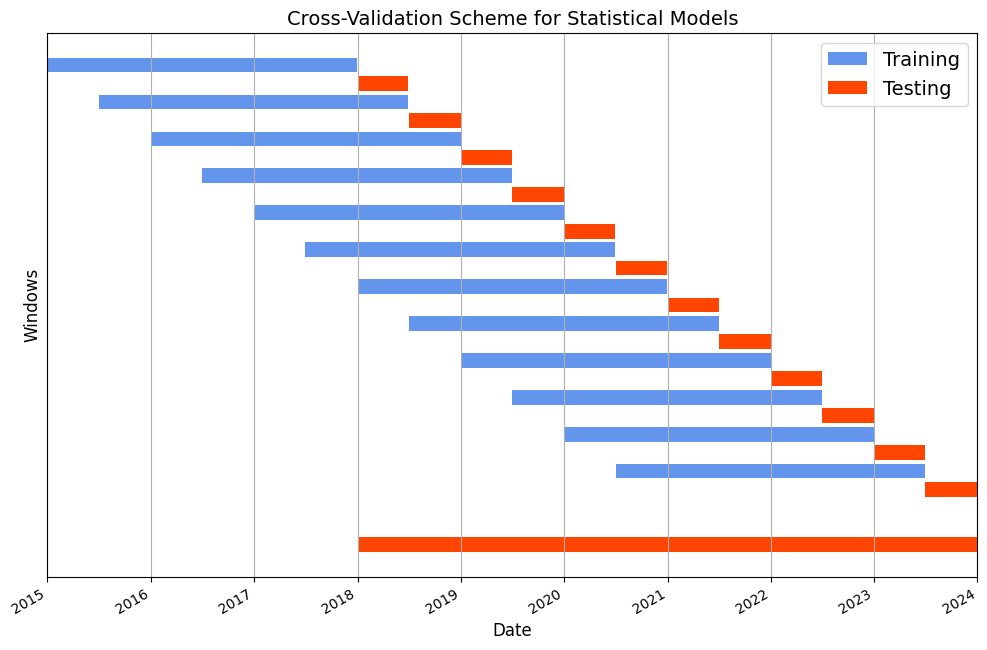

In [40]:
indices = CV_ARIMA(btc_arima)

plot_data = []
testing_start_dates = []
testing_end_dates = []

for i, window in enumerate(indices):
    plot_data.append({
        'Type': 'Training',
        'StartDate': window[0][0],
        'EndDate': window[0][-1]
    })
    plot_data.append({
        'Type': 'Testing',
        'StartDate': window[1][0],
        'EndDate': window[1][-1]
    })
    testing_start_dates.append

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 8))

colors = {'Training': 'cornflowerblue', 'Testing': 'orangered'}

for i, (label, color) in enumerate(colors.items()):
    subset = plot_df[plot_df['Type'] == label]
    plt.barh(subset.index, (subset['EndDate'] - subset['StartDate']).dt.days, left=subset['StartDate'].map(mdates.date2num), color=color, label=label)

plt.barh(2*len(indices) + 2, (plot_df[plot_df['Type'] == 'Testing'].EndDate.max() - plot_df[plot_df['Type'] == 'Testing'].StartDate.min()).days, left=plot_df[plot_df['Type'] == 'Testing'].StartDate.min(), color='orangered')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Windows', fontsize=12)
plt.yticks([])
plt.title('Cross-Validation Scheme for Statistical Models', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)

plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlim(pd.Timestamp('2015-01-01'), pd.Timestamp('2024-01-01'))

plt.gcf().autofmt_xdate()

plt.show()

## Function for calculating metrics

In [4]:
def mean_absolute_directional_loss(y_observed, y_predicted):

    y_observed = np.array(y_observed)
    y_predicted = np.array(y_predicted)
    
    direction = np.sign(y_observed * y_predicted)
    loss = np.abs(y_observed)
    directional_loss = (-1) * direction * loss
    
    MADL = np.mean(directional_loss)
    
    return MADL

In [5]:
def calculate_metrics(y_observed, y_predicted, returns = False):
    
    if not returns:
        metrics = {
            'MAE': mean_absolute_error(y_observed, y_predicted),
            'RMSE': root_mean_squared_error(y_observed, y_predicted),
        }
    else:
        metrics = {
            'MAE': mean_absolute_error(y_observed, y_predicted),
            'RMSE': root_mean_squared_error(y_observed, y_predicted),
            'MADL': mean_absolute_directional_loss(y_observed, y_predicted)
        }
    return metrics

## ARIMA

In [43]:
btc_arima = pd.DataFrame(btc_arima, columns = ['Close'])
btc_arima

,Close
Date,
2015-01-01,314.248993
2015-01-02,315.032013
2015-01-03,281.082001
2015-01-04,264.195007
2015-01-05,274.473999
...,...
2023-12-26,42520.402344
2023-12-27,43442.855469
2023-12-28,42627.855469


In [44]:
btc_arima['Log_Returns'] = np.log(btc_arima.Close / btc_arima.Close.shift(1))
btc_arima

,Close,Log_Returns
Date,,
2015-01-01,314.248993,NaN
2015-01-02,315.032013,0.002489
2015-01-03,281.082001,-0.114028
2015-01-04,264.195007,-0.061959
2015-01-05,274.473999,0.038169
...,...,...
2023-12-26,42520.402344,-0.025374
2023-12-27,43442.855469,0.021462
2023-12-28,42627.855469,-0.018938


In [45]:
def plot_acf_pacf(ts, lags=40):

    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    
    plot_acf(ts, lags=lags, auto_ylims=True, ax=ax[0])
    plot_pacf(ts, lags=lags, auto_ylims=True, ax=ax[1])
    
    ax[0].set_ylim(-0.2, 0.2)
    ax[1].set_ylim(-0.2, 0.2)
    
    plt.show()

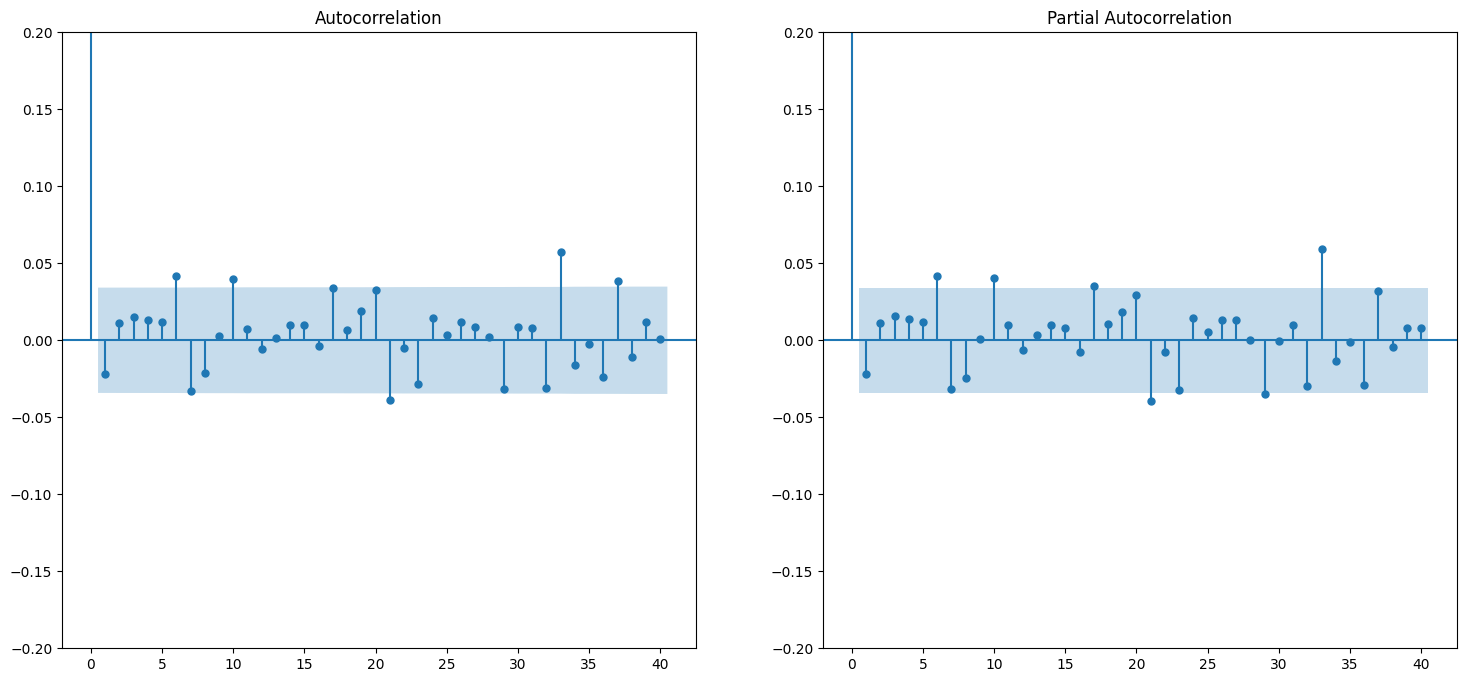

In [46]:
plot_acf_pacf(btc_arima['Log_Returns'].dropna())

In [99]:
def fit_ARIMA_auto(series):
    
    best_aic_model = {'orders': (), 'aic_value': float("inf")}

    model_aic = auto_arima(series, start_p=1, d = 0, start_q=1, max_p=5, max_q=5, max_order = None, 
                           seasonal = False, stationary = True, stepwise = True, information_criterion = 'aic')

    best_aic_model['orders'] = model_aic.get_params()['order']

    best_aic_model['aic_value'] = model_aic.aic()

    return best_aic_model

In [62]:
indices = CV_ARIMA(btc_arima)

best_arima_orders_btc_aic_auto ={}

for i, indice in tqdm(enumerate(indices)):
    
    best_aic_model = fit_ARIMA_auto(pd.DataFrame(btc_arima['Log_Returns'][indice[0]].dropna()))
    
    best_arima_orders_btc_aic_auto[i+1] = best_aic_model['orders']

12it [00:15,  1.26s/it]


### Forecasts for ARIMA models

In [64]:
def ARIMA_forecasts(df, orders):

    indices = CV_ARIMA(df, train_months = 36, test_months = 6)
    predictions = []
    
    for key, value in tqdm(orders.items()):

        series = df[indices[key-1][0]]
        len_train_series = df[indices[key-1][0]].count()
        len_test_series = df[indices[key-1][1]].count()

        for i in range(len_test_series):
        
            model = ARIMA(series[i:len_train_series+i], order=value, trend = 'n')
            model_fitted = model.fit()
            prediction = model_fitted.forecast()
            predictions.append(prediction)

    return np.array(predictions)

In [66]:
predictions_arima_btc_returns_auto = ARIMA_forecasts(btc_arima['Log_Returns'], best_arima_orders_btc_aic_auto)

100%|██████████| 12/12 [02:46<00:00, 13.87s/it]


In [67]:
predictions_arima_btc_returns_auto = [pred for prediction in predictions_arima_btc_returns_auto for pred in prediction]

In [69]:
calculate_metrics(btc_arima['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'], predictions_arima_btc_returns_auto, True)

{'MAE': 0.024229254346251294,
 'RMSE': 0.036858044672389116,
 'MADL': 8.251931861066884e-05}

In [72]:
btc_arima_complete_results = {
                                'Predictions for ARIMA': predictions_arima_btc_returns_auto
                               }

In [9]:
btc_arima_complete_results_df = pd.DataFrame(data = btc_arima_complete_results, 
                                               index = btc_arima['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'].index)

NameError: name 'btc_arima_complete_results' is not defined

In [74]:
btc_arima_observed_values_and_predictions = pd.concat([btc_arima, btc_arima_complete_results_df], axis=1, join='outer')
btc_arima_observed_values_and_predictions

,Close,Log_Returns,Predictions for ARIMA
Date,,,
2015-01-01,314.248993,NaN,NaN
2015-01-02,315.032013,0.002489,NaN
2015-01-03,281.082001,-0.114028,NaN
2015-01-04,264.195007,-0.061959,NaN
2015-01-05,274.473999,0.038169,NaN
...,...,...,...
2023-12-26,42520.402344,-0.025374,0.0
2023-12-27,43442.855469,0.021462,0.0
2023-12-28,42627.855469,-0.018938,0.0


## ARFIMA

In [78]:
btc_arima_ready = btc_arima_observed_values_and_predictions.copy()
btc_arima_ready

,Close,Log_Returns,Predictions for ARIMA
Date,,,
2015-01-01,314.248993,NaN,NaN
2015-01-02,315.032013,0.002489,NaN
2015-01-03,281.082001,-0.114028,NaN
2015-01-04,264.195007,-0.061959,NaN
2015-01-05,274.473999,0.038169,NaN
...,...,...,...
2023-12-26,42520.402344,-0.025374,0.0
2023-12-27,43442.855469,0.021462,0.0
2023-12-28,42627.855469,-0.018938,0.0


In [80]:
btc_arfima = pd.read_csv("")

In [81]:
btc_arfima

,predictions_btc
0,0.016491
1,-0.002686
2,0.001029
3,-0.001416
4,0.010314
...,...
2185,0.000385
2186,0.001512
2187,-0.000084
2188,0.001331


In [83]:
calculate_metrics(btc_arima_ready['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  btc_arfima, True)

{'MAE': 0.024382669680405387,
 'RMSE': 0.03708696604618666,
 'MADL': -0.0002630186418497128}

In [84]:
btc_arfima_complete_results_df = pd.DataFrame()

btc_arfima_complete_results_df["Predictions for ARFIMA"] = btc_arfima["predictions_btc"]

btc_arfima_complete_results_df = btc_arfima_complete_results_df.set_index(btc_arima_ready['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'].index)

btc_arima_arfima_observed_values_and_predictions = pd.concat([btc_arima_ready, btc_arfima_complete_results_df], axis=1, join='outer')

btc_arima_arfima_observed_values_and_predictions

,Close,Log_Returns,Predictions for ARIMA,Predictions for ARFIMA
Date,,,,
2015-01-01,314.248993,NaN,NaN,NaN
2015-01-02,315.032013,0.002489,NaN,NaN
2015-01-03,281.082001,-0.114028,NaN,NaN
2015-01-04,264.195007,-0.061959,NaN,NaN
2015-01-05,274.473999,0.038169,NaN,NaN
...,...,...,...,...
2023-12-26,42520.402344,-0.025374,0.0,0.000385
2023-12-27,43442.855469,0.021462,0.0,0.001512
2023-12-28,42627.855469,-0.018938,0.0,-0.000084


## Residuals for ML models

In [86]:
btc_arima_arfima_observed_values_and_predictions['ARIMA_residuals'] = (btc_arima_arfima_observed_values_and_predictions['Log_Returns'] 
                                                                    - btc_arima_arfima_observed_values_and_predictions['Predictions for ARIMA']) 
btc_arima_arfima_observed_values_and_predictions['ARFIMA_residuals'] = (btc_arima_arfima_observed_values_and_predictions['Log_Returns'] 
                                                                    - btc_arima_arfima_observed_values_and_predictions['Predictions for ARFIMA']) 
btc_arima_arfima_observed_values_and_predictions

,Close,Log_Returns,Predictions for ARIMA,Predictions for ARFIMA,ARIMA_residuals,ARFIMA_residuals
Date,,,,,,
2015-01-01,314.248993,NaN,NaN,NaN,NaN,NaN
2015-01-02,315.032013,0.002489,NaN,NaN,NaN,NaN
2015-01-03,281.082001,-0.114028,NaN,NaN,NaN,NaN
2015-01-04,264.195007,-0.061959,NaN,NaN,NaN,NaN
2015-01-05,274.473999,0.038169,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-26,42520.402344,-0.025374,0.0,0.000385,-0.025374,-0.025760
2023-12-27,43442.855469,0.021462,0.0,0.001512,0.021462,0.019950
2023-12-28,42627.855469,-0.018938,0.0,-0.000084,-0.018938,-0.018855


In [87]:
describe_data(btc_arima_arfima_observed_values_and_predictions['ARIMA_residuals'], name = 'ARIMA')

Description of: ARIMA

Count: 2190

Minimum value: -0.4647
1st Quantile: -0.0152
Median: -0.0
Mean value: -0.0004
3rd Quantile: 0.0152
Maximum value: 0.1683

Skewness: nan
Kurtosis: nan
Standard Error: nan
Standard Deviation: 0.0369


In [88]:
describe_data(btc_arima_arfima_observed_values_and_predictions['ARFIMA_residuals'], name = 'ARFIMA')

Description of: ARFIMA

Count: 2190

Minimum value: -0.4675
1st Quantile: -0.0156
Median: -0.0007
Mean value: -0.0011
3rd Quantile: 0.0144
Maximum value: 0.1656

Skewness: nan
Kurtosis: nan
Standard Error: nan
Standard Deviation: 0.0371


In [93]:
btc_arima_arfima_observed_values_and_predictions.to_csv("C:/Users/sdomi/OneDrive/Pulpit/ZSM PROJEKT/PLIKI/btc_hybrids/ARIMA_ARFIMA_residuals_btc.csv")

### Hybrid Models

In [6]:
file_path = ""
btc_arima_arfima_observed_values_and_predictions = pd.read_csv(file_path)
btc_arima_arfima_observed_values_and_predictions['Date'] = pd.to_datetime(btc_arima_arfima_observed_values_and_predictions['Date'])
btc_arima_arfima_observed_values_and_predictions.set_index('Date', inplace=True)

In [41]:
btc_arima_arfima_observed_values_and_predictions

,Close,Log_Returns,Predictions for ARIMA,Predictions for ARFIMA,ARIMA_residuals,ARFIMA_residuals
Date,,,,,,
2015-01-01,314.248993,NaN,NaN,NaN,NaN,NaN
2015-01-02,315.032013,0.002489,NaN,NaN,NaN,NaN
2015-01-03,281.082001,-0.114028,NaN,NaN,NaN,NaN
2015-01-04,264.195007,-0.061959,NaN,NaN,NaN,NaN
2015-01-05,274.473999,0.038169,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2023-12-26,42520.402344,-0.025374,0.0,0.000385,-0.025374,-0.025760
2023-12-27,43442.855469,0.021462,0.0,0.001512,0.021462,0.019950
2023-12-28,42627.855469,-0.018938,0.0,-0.000084,-0.018938,-0.018855


In [42]:
btc_arima_residuals_df = pd.DataFrame(btc_arima_arfima_observed_values_and_predictions['ARIMA_residuals'])
btc_arima_residuals_df.rename(columns={'ARIMA_residuals': 'Residuals'}, inplace=True)
btc_arfima_residuals_df = pd.DataFrame(btc_arima_arfima_observed_values_and_predictions['ARFIMA_residuals'])
btc_arfima_residuals_df.rename(columns={'ARFIMA_residuals': 'Residuals'}, inplace=True)

In [43]:
indices = CV_ARIMA(btc_arima_arfima_observed_values_and_predictions)

NameError: name 'CV_ARIMA' is not defined

In [44]:
model = ARIMA(btc_arima_arfima_observed_values_and_predictions['Log_Returns'][indices[0][0]], order=(0,0,0), trend = 'n')
model_fitted = model.fit()
predicted = model_fitted.predict()

new_residuals = btc_arima_arfima_observed_values_and_predictions['Log_Returns'][indices[0][0]] - predicted
btc_arima_residuals_df.loc[f'2015-01-01':f'2017-12-31'] = pd.DataFrame(new_residuals)
btc_arima_residuals_df

NameError: name 'indices' is not defined

In [45]:
btc_arima_arfima_observed_values_and_predictions['Auxiliary ARIMA Predictions'] = btc_arima_arfima_observed_values_and_predictions['Predictions for ARIMA'].copy()
btc_arima_arfima_observed_values_and_predictions['Auxiliary ARIMA Predictions'].loc[f'2015-01-01':f'2017-12-31'] = predicted

NameError: name 'predicted' is not defined

In [82]:
predicted = pd.read_csv("")
predicted.index = btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2015-01-01':f'2017-12-31'].index
new_residuals = btc_arima_arfima_observed_values_and_predictions['Log_Returns'][indices[0][0]] - predicted['fitted']
btc_arfima_residuals_df.loc[f'2015-01-01':f'2017-12-31'] = pd.DataFrame(new_residuals)
btc_arfima_residuals_df

,Residuals
Date,
2015-01-01,NaN
2015-01-02,-0.000981
2015-01-03,-0.116619
2015-01-04,-0.062578
2015-01-05,0.028324
...,...
2023-12-26,-0.025760
2023-12-27,0.019950
2023-12-28,-0.018855


In [83]:
btc_arima_arfima_observed_values_and_predictions['Auxiliary ARFIMA Predictions'] = btc_arima_arfima_observed_values_and_predictions['Predictions for ARFIMA'].copy()
btc_arima_arfima_observed_values_and_predictions['Auxiliary ARFIMA Predictions'].loc[f'2015-01-01':f'2017-12-31'] = predicted['fitted']

In [84]:
btc_arima_arfima_observed_values_and_predictions

,Close,Log_Returns,Predictions for ARIMA,Predictions for ARFIMA,ARIMA_residuals,ARFIMA_residuals,Auxiliary ARIMA Predictions,Auxiliary ARFIMA Predictions
Date,,,,,,,,
2015-01-01,314.248993,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2015-01-02,315.032013,0.002489,NaN,NaN,NaN,NaN,0.0,0.003470
2015-01-03,281.082001,-0.114028,NaN,NaN,NaN,NaN,0.0,0.002591
2015-01-04,264.195007,-0.061959,NaN,NaN,NaN,NaN,0.0,0.000619
2015-01-05,274.473999,0.038169,NaN,NaN,NaN,NaN,0.0,0.009845
...,...,...,...,...,...,...,...,...
2023-12-26,42520.402344,-0.025374,0.0,0.000385,-0.025374,-0.025760,0.0,0.000385
2023-12-27,43442.855469,0.021462,0.0,0.001512,0.021462,0.019950,0.0,0.001512
2023-12-28,42627.855469,-0.018938,0.0,-0.000084,-0.018938,-0.018855,0.0,-0.000084


## Support Vector Machines

In [18]:
def new_df_lagged(df, lag = 7):

    lagged_df = df.copy()

    for i in range(lag):
        lagged_df[f'Log_Returns_{i+1}'] = lagged_df['Log_Returns'].shift(i+1)

    lagged_df.rename(columns={'Log_Returns' : 'Target'}, inplace=True)
    lagged_df.dropna(inplace=True)
    lagged_df.index = pd.to_datetime(lagged_df.index)
    
    return lagged_df

In [114]:
btc_arima_arfima_observed_values_and_predictions

,Close,Log_Returns,Predictions for ARIMA,Predictions for ARFIMA,ARIMA_residuals,ARFIMA_residuals,Auxiliary ARIMA Predictions,Auxiliary ARFIMA Predictions
Date,,,,,,,,
2015-01-01,314.248993,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2015-01-02,315.032013,0.002489,NaN,NaN,NaN,NaN,0.0,0.003470
2015-01-03,281.082001,-0.114028,NaN,NaN,NaN,NaN,0.0,0.002591
2015-01-04,264.195007,-0.061959,NaN,NaN,NaN,NaN,0.0,0.000619
2015-01-05,274.473999,0.038169,NaN,NaN,NaN,NaN,0.0,0.009845
...,...,...,...,...,...,...,...,...
2023-12-26,42520.402344,-0.025374,0.0,0.000385,-0.025374,-0.025760,0.0,0.000385
2023-12-27,43442.855469,0.021462,0.0,0.001512,0.021462,0.019950,0.0,0.001512
2023-12-28,42627.855469,-0.018938,0.0,-0.000084,-0.018938,-0.018855,0.0,-0.000084


In [136]:
btc_df = pd.DataFrame(btc_arima_arfima_observed_values_and_predictions[['Log_Returns']])
btc_df

,Log_Returns
Date,
2015-01-01,NaN
2015-01-02,0.002489
2015-01-03,-0.114028
2015-01-04,-0.061959
2015-01-05,0.038169
...,...
2023-12-26,-0.025374
2023-12-27,0.021462
2023-12-28,-0.018938


In [137]:
def CV_SVM(df, lag=7, target='Target', scaler = False,
           best_models_rmse = {},
           best_models_madl = {},
           *args, **kwargs):

    lagged_df = new_df_lagged(df, lag)

    features = lagged_df.columns.tolist()
    features.remove(target)
     
    indices = CV_machine_expanding(lagged_df)
    
    for i, index in enumerate(indices):
        
        train, val_0, val_1, val_2 = index[0], index[1][0], index[1][1], index[1][2]

        X_train, y_train = lagged_df.loc[train][features], lagged_df.loc[train][target]
        
        X_val_0, y_val_0 = lagged_df.loc[val_0][features], lagged_df.loc[val_0][target]
        X_val_1, y_val_1 = lagged_df.loc[val_1][features], lagged_df.loc[val_1][target]
        X_val_2, y_val_2 = lagged_df.loc[val_2][features], lagged_df.loc[val_2][target]

        if scaler:
            
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_val_0 = sc.transform(X_val_0)
            X_val_1 = sc.transform(X_val_1)
            X_val_2 = sc.transform(X_val_2)

        model = SVR(tol = 1e-4, *args, **kwargs)
        model.fit(X_train, y_train)

        pred_val_0 = model.predict(X_val_0).tolist()
        pred_val_1 = model.predict(X_val_1).tolist()
        pred_val_2 = model.predict(X_val_2).tolist()
        
        val_rmse_0 = root_mean_squared_error(y_val_0, pred_val_0)
        val_rmse_1 = root_mean_squared_error(y_val_1, pred_val_1)
        val_rmse_2 = root_mean_squared_error(y_val_2, pred_val_2)

        val_madl_0 = mean_absolute_directional_loss(y_val_0, pred_val_0)
        val_madl_1 = mean_absolute_directional_loss(y_val_1, pred_val_1)
        val_madl_2 = mean_absolute_directional_loss(y_val_2, pred_val_2)

        val_rmse = np.mean([val_rmse_0, val_rmse_1, val_rmse_2])
        val_madl = np.mean([val_madl_0, val_madl_1, val_madl_2])
        
        if val_rmse < list(best_models_rmse.values())[i][3]:
            
            best_models_rmse[i][0] = model
            best_models_rmse[i][1] = lag
            best_models_rmse[i][2] = scaler
            best_models_rmse[i][3] = val_rmse
            best_models_rmse[i][4] = pred_val_2

        if val_madl < list(best_models_madl.values())[i][3]:
            
            best_models_madl[i][0] = model
            best_models_madl[i][1] = lag
            best_models_madl[i][2] = scaler
            best_models_madl[i][3] = val_madl
            best_models_madl[i][4] = pred_val_2

    return best_models_rmse, best_models_madl

### Hyperparameters tuning for SVM

In [195]:
best_models_rmse_svm_exp = {}
best_models_madl_svm_exp = {}

for i in range(12):
    
    best_models_rmse_svm_exp[i] = ['model', 100, 'scaler', np.Inf, np.nan]
    best_models_madl_svm_exp[i] = ['model', 100, 'scaler', np.Inf, np.nan]

In [196]:
for kernel in tqdm(['linear', 'rbf']):  

    if kernel == 'linear':
        
        for c in tqdm([0.0001, 0.001, 0.01, 0.1, 1]): 

                for scaling in [True]:

                    for lag in [4, 7, 14, 21, 28]:

                        for epsilon in [0.005, 0.0075, 0.01, 0.025]:
    
                            best_models_rmse_svm_loop, best_models_madl_svm_loop = CV_SVM(btc_df, kernel = kernel, C = c, lag = lag, 
                                                                                              scaler = scaling, epsilon = epsilon, 
                                                                                              best_models_rmse = best_models_rmse_svm_exp,
                                                                                              best_models_madl = best_models_madl_svm_exp)
                            best_models_rmse_svm_exp = best_models_rmse_svm_loop
                            best_models_madl_svm_exp = best_models_madl_svm_loop
                    


                            
    else:

        for c in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 5]):

                for gamma in [0.0001, 0.001, 0.01, 0.1, 1, 5]:

                    for scaling in [True]:

                        for lag in [4, 7, 14, 21, 28]:

                            for epsilon in [0.005, 0.0075, 0.01, 0.025]:

                                best_models_rmse_svm_loop, best_models_madl_svm_loop = CV_SVM(btc_df, kernel = kernel, C = c, lag = lag, 
                                                                                              scaler = scaling, epsilon = epsilon, 
                                                                                              best_models_rmse = best_models_rmse_svm_exp,
                                                                                              best_models_madl = best_models_madl_svm_exp)
                                best_models_rmse_svm_exp = best_models_rmse_svm_loop
                                best_models_madl_svm_exp = best_models_madl_svm_loop

100%|██████████| 2/2 [16:01<00:00, 480.96s/it]


In [197]:
list_of_results_svm_exp =[best_models_rmse_svm_exp, best_models_madl_svm_exp]

for number, dictio in enumerate(list_of_results_svm_exp):

    print(f'{number+1}')

    for i in range(12):

        print(list(dictio.values())[i][0], list(dictio.values())[i][1], list(dictio.values())[i][2])


1
SVR(C=0.01, epsilon=0.025, tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.025, tol=0.0001) 4 True
SVR(C=0.0001, epsilon=0.005, kernel='linear', tol=0.0001) 21 True
SVR(C=0.01, epsilon=0.025, tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.01, kernel='linear', tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.005, tol=0.0001) 7 True
SVR(C=1, epsilon=0.005, kernel='linear', tol=0.0001) 4 True
SVR(C=0.001, epsilon=0.025, kernel='linear', tol=0.0001) 7 True
SVR(C=0.0001, epsilon=0.01, kernel='linear', tol=0.0001) 4 True
SVR(C=0.001, epsilon=0.025, tol=0.0001) 14 True
SVR(C=0.01, epsilon=0.005, tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.01, tol=0.0001) 14 True
2
SVR(C=0.01, epsilon=0.025, kernel='linear', tol=0.0001) 28 True
SVR(C=0.01, epsilon=0.01, tol=0.0001) 4 True
SVR(C=1, epsilon=0.025, tol=0.0001) 7 True
SVR(C=1, epsilon=0.005, tol=0.0001) 7 True
SVR(C=0.01, epsilon=0.0075, kernel='linear', tol=0.0001) 21 True
SVR(C=1, epsilon=0.0075, tol=0.0001) 14 True
SVR(C=0.001, epsilon=0.005, kernel='linear', tol=0.

In [198]:
predictions_rmse_svm_exp = []
predictions_madl_svm_exp = []


for i in range(12):
    
    predictions_rmse_svm_exp.append((list(best_models_rmse_svm_exp.values())[i][3]))
    predictions_madl_svm_exp.append((list(best_models_madl_svm_exp.values())[i][3]))

predictions_rmse_svm_exp = np.mean(predictions_rmse_svm_exp)
predictions_madl_svm_exp = np.mean(predictions_madl_svm_exp)

In [199]:
print('RMSE', predictions_rmse_svm_exp, '\n',
     'MADL', predictions_madl_svm_exp, '\n')

RMSE 0.03912654535260235 
 MADL -0.0057453181098726346 



### Predictions for SVM

In [200]:
def pred_SVM(df, target='Target',
             best_models = {},
             debug = True, print_results = True, *args, **kwargs):

    lagged_df = new_df_lagged(df, lag = list(best_models.values())[0][1])
    indices = CV_machine_expanding(lagged_df)

    train_rmse_list = []
    train_mae_list = []
    train_madl_list = []
    test_rmse_list = []
    test_mae_list = []
    test_madl_list = []
    
    predictions = []

    for i, index in enumerate(indices):
        
        train, test = index[0], index[2]

        lag_chosen = list(best_models.values())[i][1]
        lagged_df = new_df_lagged(df, lag = lag_chosen)

        features = lagged_df.columns.tolist()
        features.remove(target)

        X_train, y_train = lagged_df.loc[train][features], lagged_df.loc[train][target]
        X_test, y_test = lagged_df.loc[test][features], lagged_df.loc[test][target]

        scaler_chosen = list(best_models.values())[i][2]
        if scaler_chosen:
            
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)

        model = list(best_models.values())[i][0]
        
        model.fit(X_train, y_train)

        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        predictions.append(pred_test.tolist().copy())
        
        train_rmse = root_mean_squared_error(y_train, pred_train)
        test_rmse = root_mean_squared_error(y_test, pred_test)
        train_mae = mean_absolute_error(y_train, pred_train)
        test_mae = mean_absolute_error(y_test, pred_test)
        train_madl = mean_absolute_directional_loss(y_train, pred_train)
        test_madl = mean_absolute_directional_loss(y_test, pred_test)
    
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        train_mae_list.append(train_mae)
        test_mae_list.append(test_mae)
        train_madl_list.append(train_madl)
        test_madl_list.append(test_madl)

        if debug:
            
            print(model)
            print(lag_chosen)
            print(scaler_chosen)
    
    if print_results:  
        
        print("\navg Train RMSE:", round(np.mean(train_rmse_list), 5), "avg Test RMSE", round(np.mean(test_rmse_list), 5),
             "\navg Train MAE:", round(np.mean(train_mae_list), 5), "avg Test MAE", round(np.mean(test_mae_list), 5),
             "\navg Train MADL:", round(np.mean(train_madl_list), 5), "avg Test MADL", round(np.mean(test_madl_list), 5),)
    
    return train_rmse_list, test_rmse_list, train_mae_list, test_mae_list, test_madl_list, predictions

### RMSE

In [201]:
btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31']

Date
2018-01-01   -0.035900
2018-01-02    0.092589
2018-01-03    0.014505
2018-01-04    0.025858
2018-01-05    0.110945
                ...   
2023-12-26   -0.025374
2023-12-27    0.021462
2023-12-28   -0.018938
2023-12-29   -0.012474
2023-12-30    0.001365
Name: Log_Returns, Length: 2190, dtype: float64

In [202]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list,
 test_madl_list, predictions) = pred_SVM(df = btc_df, best_models = best_models_rmse_svm_exp)

predictions_test_rmse_svm_exp = [pred for prediction in predictions for pred in prediction]

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_svm_exp, True)

SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.0001, epsilon=0.005, kernel='linear', tol=0.0001)
21
True
SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.01, kernel='linear', tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.005, tol=0.0001)
7
True
SVR(C=1, epsilon=0.005, kernel='linear', tol=0.0001)
4
True
SVR(C=0.001, epsilon=0.025, kernel='linear', tol=0.0001)
7
True
SVR(C=0.0001, epsilon=0.01, kernel='linear', tol=0.0001)
4
True
SVR(C=0.001, epsilon=0.025, tol=0.0001)
14
True
SVR(C=0.01, epsilon=0.005, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.01, tol=0.0001)
14
True

avg Train RMSE: 0.03855 avg Test RMSE 0.03579 
avg Train MAE: 0.02506 avg Test MAE 0.02444 
avg Train MADL: -0.00631 avg Test MADL -0.00142


{'MAE': 0.024417633850209657,
 'RMSE': 0.03693991881460276,
 'MADL': -0.0014076313924743615}

### Save SVM predictions

In [206]:
with open('', 'wb') as f:
    
    pickle.dump(best_models_rmse_svm_exp, f)
    pickle.dump(predictions_test_rmse_svm_exp, f)

### Hyperparameters tuning for HYBRID 1 - SVM

In [21]:
btc_arima_hybrid1_df = pd.DataFrame(btc_arima_arfima_observed_values_and_predictions[['Log_Returns', 'Auxiliary ARIMA Predictions']])
btc_arima_hybrid1_df

,Log_Returns,Auxiliary ARIMA Predictions
Date,,
2015-01-01,NaN,0.0
2015-01-02,0.002489,0.0
2015-01-03,-0.114028,0.0
2015-01-04,-0.061959,0.0
2015-01-05,0.038169,0.0
...,...,...
2023-12-26,-0.025374,0.0
2023-12-27,0.021462,0.0
2023-12-28,-0.018938,0.0


In [22]:
btc_arfima_hybrid1_df = pd.DataFrame(btc_arima_arfima_observed_values_and_predictions[['Log_Returns', 'Auxiliary ARFIMA Predictions']])
btc_arfima_hybrid1_df

,Log_Returns,Auxiliary ARFIMA Predictions
Date,,
2015-01-01,NaN,NaN
2015-01-02,0.002489,0.003470
2015-01-03,-0.114028,0.002591
2015-01-04,-0.061959,0.000619
2015-01-05,0.038169,0.009845
...,...,...
2023-12-26,-0.025374,0.000385
2023-12-27,0.021462,0.001512
2023-12-28,-0.018938,-0.000084


In [209]:
best_models_rmse_svm_arima_exp = {}
best_models_rmse_svm_arfima_exp = {}
best_models_madl_svm_arima_exp = {}
best_models_madl_svm_arfima_exp = {}

for i in range(12):
    
    best_models_rmse_svm_arima_exp[i] = ['model', 100, 'scaler', np.Inf, np.nan]
    best_models_rmse_svm_arfima_exp[i] = ['model', 100, 'scaler', np.Inf, np.nan]
    best_models_madl_svm_arima_exp[i] = ['model', 100, 'scaler', np.Inf, np.nan]
    best_models_madl_svm_arfima_exp[i] = ['model', 100, 'scaler', np.Inf, np.nan]

In [210]:
for kernel in tqdm(['linear', 'rbf']): 

    if kernel == 'linear':
        
        for c in tqdm([0.0001, 0.001, 0.01, 0.1, 1]): 

                for scaling in [True]:

                    for lag in [4, 7, 14, 21, 28]:

                        for epsilon in [0.005, 0.0075, 0.01, 0.025]:
    
                            best_models_rmse_svm_arima_loop, best_models_madl_svm_arima_loop = CV_SVM(btc_arima_hybrid1_df, kernel = kernel, C = c, lag = lag, 
                                                                                              scaler = scaling, epsilon = epsilon, 
                                                                                              best_models_rmse = best_models_rmse_svm_arima_exp,
                                                                                              best_models_madl = best_models_madl_svm_arima_exp)
                            best_models_rmse_svm_arima_exp = best_models_rmse_svm_arima_loop
                            best_models_madl_svm_arima_exp = best_models_madl_svm_arima_loop
                    
                            best_models_rmse_svm_arfima_loop, best_models_madl_svm_arfima_loop = CV_SVM(btc_arfima_hybrid1_df, kernel = kernel, C = c, lag = lag, 
                                                                                              scaler = scaling, epsilon = epsilon, 
                                                                                              best_models_rmse = best_models_rmse_svm_arfima_exp,
                                                                                              best_models_madl = best_models_madl_svm_arfima_exp)
                            best_models_rmse_svm_arfima_exp = best_models_rmse_svm_arfima_loop
                            best_models_madl_svm_arfima_exp = best_models_madl_svm_arfima_loop


                            
    else:

        for c in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 5]):

                for gamma in [0.0001, 0.001, 0.01, 0.1, 1, 5]:

                    for scaling in [True]:

                        for lag in [4, 7, 14, 21, 28]:

                            for epsilon in [0.005, 0.0075, 0.01, 0.025]:

                                best_models_rmse_svm_arima_loop, best_models_madl_svm_arima_loop = CV_SVM(btc_arima_hybrid1_df, kernel = kernel, C = c, lag = lag, 
                                                                                              scaler = scaling, epsilon = epsilon, 
                                                                                              best_models_rmse = best_models_rmse_svm_arima_exp,
                                                                                              best_models_madl = best_models_madl_svm_arima_exp)
                                best_models_rmse_svm_arima_exp = best_models_rmse_svm_arima_loop
                                best_models_madl_svm_arima_exp = best_models_madl_svm_arima_loop
                    
                                best_models_rmse_svm_arfima_loop, best_models_madl_svm_arfima_loop = CV_SVM(btc_arfima_hybrid1_df, kernel = kernel, C = c, lag = lag, 
                                                                                              scaler = scaling, epsilon = epsilon, 
                                                                                              best_models_rmse = best_models_rmse_svm_arfima_exp,
                                                                                              best_models_madl = best_models_madl_svm_arfima_exp)
                                best_models_rmse_svm_arfima_exp = best_models_rmse_svm_arfima_loop
                                best_models_madl_svm_arfima_exp = best_models_madl_svm_arfima_loop
    

100%|██████████| 2/2 [32:39<00:00, 979.73s/it] 


In [211]:
list_of_results_svm_exp =[best_models_rmse_svm_arima_exp, best_models_madl_svm_arima_exp,
                         best_models_rmse_svm_arfima_exp, best_models_madl_svm_arfima_exp]

for number, dictio in enumerate(list_of_results_svm_exp):

    print(f'{number+1}')

    for i in range(12):

        print(list(dictio.values())[i][0], list(dictio.values())[i][1], list(dictio.values())[i][2])


1
SVR(C=0.01, epsilon=0.025, tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.025, tol=0.0001) 4 True
SVR(C=0.0001, epsilon=0.005, kernel='linear', tol=0.0001) 21 True
SVR(C=0.01, epsilon=0.025, tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.01, kernel='linear', tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.005, tol=0.0001) 7 True
SVR(C=1, epsilon=0.005, kernel='linear', tol=0.0001) 4 True
SVR(C=0.001, epsilon=0.025, kernel='linear', tol=0.0001) 7 True
SVR(C=0.0001, epsilon=0.01, kernel='linear', tol=0.0001) 4 True
SVR(C=0.0001, epsilon=0.01, tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.005, tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.005, tol=0.0001) 14 True
2
SVR(C=0.01, epsilon=0.025, kernel='linear', tol=0.0001) 28 True
SVR(C=0.01, epsilon=0.01, tol=0.0001) 4 True
SVR(C=1, epsilon=0.025, tol=0.0001) 7 True
SVR(C=1, epsilon=0.005, tol=0.0001) 7 True
SVR(C=0.01, epsilon=0.0075, kernel='linear', tol=0.0001) 21 True
SVR(C=1, epsilon=0.0075, tol=0.0001) 14 True
SVR(C=0.001, epsilon=0.005, kernel='linear', tol=0.

In [212]:
predictions_rmse_svm_arima_exp = []
predictions_rmse_svm_arfima_exp = []
predictions_madl_svm_arima_exp = []
predictions_madl_svm_arfima_exp = []


for i in range(12):
    
    predictions_rmse_svm_arima_exp.append((list(best_models_rmse_svm_arima_exp.values())[i][3]))
    predictions_rmse_svm_arfima_exp.append((list(best_models_rmse_svm_arfima_exp.values())[i][3]))
    predictions_madl_svm_arima_exp.append((list(best_models_madl_svm_arima_exp.values())[i][3]))
    predictions_madl_svm_arfima_exp.append((list(best_models_madl_svm_arfima_exp.values())[i][3]))

predictions_rmse_svm_arima_exp = np.mean(predictions_rmse_svm_arima_exp)
predictions_rmse_svm_arfima_exp = np.mean(predictions_rmse_svm_arfima_exp)
predictions_madl_svm_arima_exp = np.mean(predictions_madl_svm_arima_exp)
predictions_madl_svm_arfima_exp = np.mean(predictions_madl_svm_arfima_exp)

In [213]:
print('RMSE ARIMA', predictions_rmse_svm_arima_exp, '\n',
     'RMSE ARFIMA', predictions_rmse_svm_arfima_exp, '\n',
     'MADL ARIMA', predictions_madl_svm_arima_exp, '\n',
     'MADL ARFIMA', predictions_madl_svm_arfima_exp, '\n')

RMSE ARIMA 0.03911856520383351 
 RMSE ARFIMA 0.03911570801903364 
 MADL ARIMA -0.005834588848881733 
 MADL ARFIMA -0.006040778860650977 



## Predictions for HYBRID 1 - SVM

#### ARIMA RMSE

In [214]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list,
 test_madl_list, predictions) = pred_SVM(df = btc_arima_hybrid1_df, best_models = best_models_rmse_svm_arima_exp)

predictions_test_rmse_svm_arima_exp = [pred for prediction in predictions for pred in prediction]

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_svm_arima_exp, True)

SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.0001, epsilon=0.005, kernel='linear', tol=0.0001)
21
True
SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.01, kernel='linear', tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.005, tol=0.0001)
7
True
SVR(C=1, epsilon=0.005, kernel='linear', tol=0.0001)
4
True
SVR(C=0.001, epsilon=0.025, kernel='linear', tol=0.0001)
7
True
SVR(C=0.0001, epsilon=0.01, kernel='linear', tol=0.0001)
4
True
SVR(C=0.0001, epsilon=0.01, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.005, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.005, tol=0.0001)
14
True

avg Train RMSE: 0.03855 avg Test RMSE 0.03577 
avg Train MAE: 0.02501 avg Test MAE 0.02447 
avg Train MADL: -0.00632 avg Test MADL -0.00137


{'MAE': 0.024447838368147803,
 'RMSE': 0.036927736334461676,
 'MADL': -0.0013676396886246266}

#### ARFIMA - RMSE

In [216]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list,
 test_madl_list, predictions) = pred_SVM(df = btc_arfima_hybrid1_df, best_models = best_models_rmse_svm_arfima_exp)

predictions_test_rmse_svm_arfima_exp = [pred for prediction in predictions for pred in prediction]

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_svm_arfima_exp, True)

SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.025, tol=0.0001)
21
True
SVR(C=0.0001, epsilon=0.005, kernel='linear', tol=0.0001)
21
True
SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.0001, epsilon=0.025, kernel='linear', tol=0.0001)
14
True
SVR(C=0.01, epsilon=0.005, tol=0.0001)
7
True
SVR(C=0.1, epsilon=0.0075, kernel='linear', tol=0.0001)
7
True
SVR(C=0.001, epsilon=0.025, kernel='linear', tol=0.0001)
7
True
SVR(C=0.001, epsilon=0.005, tol=0.0001)
4
True
SVR(C=0.001, epsilon=0.025, tol=0.0001)
14
True
SVR(C=0.1, epsilon=0.025, tol=0.0001)
28
True
SVR(C=0.01, epsilon=0.01, tol=0.0001)
14
True

avg Train RMSE: 0.03744 avg Test RMSE 0.03595 
avg Train MAE: 0.0245 avg Test MAE 0.02461 
avg Train MADL: -0.0077 avg Test MADL -0.00077


{'MAE': 0.024588931929470138,
 'RMSE': 0.037093388274927176,
 'MADL': -0.0007701797541472289}

### Save HYBRID 1 - SVM predictions

In [222]:
with open('', 'wb') as f:
    
    pickle.dump(best_models_rmse_svm_arima_exp, f)
    pickle.dump(best_models_rmse_svm_arfima_exp, f)
    
    pickle.dump(predictions_test_rmse_svm_arima_exp, f)
    pickle.dump(predictions_test_rmse_svm_arfima_exp, f)

### Hyperparameters tuning for HYBRID 2 - SVM

In [23]:
def new_df_lagged_hybrid(df, lag = 7):

    lagged_df = df.copy()

    for i in range(lag):
        lagged_df[f'Residuals_{i+1}'] = lagged_df['Residuals'].shift(i+1)

    lagged_df.rename(columns={'Residuals' : 'Target'}, inplace=True)
    lagged_df.dropna(inplace=True)
    lagged_df.index = pd.to_datetime(lagged_df.index)
    return lagged_df

In [224]:
best_models_rmse_svm_arima_exp_2 = {}
best_models_rmse_svm_arfima_exp_2 = {}
best_models_madl_svm_arima_exp_2 = {}
best_models_madl_svm_arfima_exp_2 = {}

for i in range(12):
    
    best_models_rmse_svm_arima_exp_2[i] = ['model', 100, 'scaler', np.Inf, np.nan]
    best_models_rmse_svm_arfima_exp_2[i] = ['model', 100, 'scaler', np.Inf, np.nan]
    best_models_madl_svm_arima_exp_2[i] = ['model', 100, 'scaler', np.Inf, np.nan]
    best_models_madl_svm_arfima_exp_2[i] = ['model', 100, 'scaler', np.Inf, np.nan]

In [225]:
def CV_SVM_hybrid_2(df, lag=7, target='Target', scaler = False, arima = True,
           best_models_rmse = {},
           best_models_madl = {},
           debug = False, *args, **kwargs):

    lagged_df = new_df_lagged_hybrid(df, lag)

    features = lagged_df.columns.tolist()
    features.remove(target)

    indices = CV_machine_expanding(lagged_df)
    
    for i, index in enumerate(indices):
        
        train, val_0, val_1, val_2 = index[0], index[1][0], index[1][1], index[1][2]

        X_train, y_train = lagged_df.loc[train][features], lagged_df.loc[train][target]
        
        X_val_0, y_val_0 = lagged_df.loc[val_0][features], lagged_df.loc[val_0][target]
        X_val_1, y_val_1 = lagged_df.loc[val_1][features], lagged_df.loc[val_1][target]
        X_val_2, y_val_2 = lagged_df.loc[val_2][features], lagged_df.loc[val_2][target]

        if scaler:
            
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_val_0 = sc.transform(X_val_0)
            X_val_1 = sc.transform(X_val_1)
            X_val_2 = sc.transform(X_val_2)

        model = SVR(tol = 1e-4, *args, **kwargs)
        model.fit(X_train, y_train)

        pred_val_0 = model.predict(X_val_0).tolist()
        pred_val_1 = model.predict(X_val_1).tolist()
        pred_val_2 = model.predict(X_val_2).tolist()
        
        val_rmse_0 = root_mean_squared_error(y_val_0, pred_val_0)
        val_rmse_1 = root_mean_squared_error(y_val_1, pred_val_1)
        val_rmse_2 = root_mean_squared_error(y_val_2, pred_val_2)

        val_rmse = np.mean([val_rmse_0, val_rmse_1, val_rmse_2])

        if arima == True:

            predictions_combined_0 = pred_val_0 + btc_arima_arfima_observed_values_and_predictions.loc[val_0]["Auxiliary ARIMA Predictions"]
            val_madl_combined_0 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_0]['Log_Returns'],
                                                                          predictions_combined_0, True)['MADL']
            predictions_combined_1 = pred_val_1 + btc_arima_arfima_observed_values_and_predictions.loc[val_1]["Auxiliary ARIMA Predictions"]
            val_madl_combined_1 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_1]['Log_Returns'],
                                                                          predictions_combined_1, True)['MADL']
            predictions_combined_2 = pred_val_2 + btc_arima_arfima_observed_values_and_predictions.loc[val_2]["Auxiliary ARIMA Predictions"]
            val_madl_combined_2 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_2]['Log_Returns'],
                                                                          predictions_combined_2, True)['MADL']
            
            val_madl_combined = np.mean([val_madl_combined_0, val_madl_combined_1, val_madl_combined_2])

        elif arima == False:


            predictions_combined_0 = pred_val_0 + btc_arima_arfima_observed_values_and_predictions.loc[val_0]["Auxiliary ARFIMA Predictions"]
            val_madl_combined_0 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_0]['Log_Returns'],
                                                                          predictions_combined_0, True)['MADL']
            predictions_combined_1 = pred_val_1 + btc_arima_arfima_observed_values_and_predictions.loc[val_1]["Auxiliary ARFIMA Predictions"]
            val_madl_combined_1 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_1]['Log_Returns'],
                                                                          predictions_combined_1, True)['MADL']
            predictions_combined_2 = pred_val_2 + btc_arima_arfima_observed_values_and_predictions.loc[val_2]["Auxiliary ARFIMA Predictions"]
            val_madl_combined_2 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_2]['Log_Returns'],
                                                                          predictions_combined_2, True)['MADL']
            
            val_madl_combined = np.mean([val_madl_combined_0, val_madl_combined_1, val_madl_combined_2])

        if val_rmse < list(best_models_rmse.values())[i][3]:
            
            best_models_rmse[i][0] = model
            best_models_rmse[i][1] = lag
            best_models_rmse[i][2] = scaler
            best_models_rmse[i][3] = val_rmse
            best_models_rmse[i][4] = pred_val_2

        if val_madl_combined < list(best_models_madl.values())[i][3]:
            
            best_models_madl[i][0] = model
            best_models_madl[i][1] = lag
            best_models_madl[i][2] = scaler
            best_models_madl[i][3] = val_madl_combined
            best_models_madl[i][4] = pred_val_2

    
    return best_models_rmse, best_models_madl

In [226]:
for kernel in tqdm(['linear', 'rbf']): 

    if kernel == 'linear':
        
        for c in tqdm([0.0001, 0.001, 0.01, 0.1, 1]): 

                for scaling in [True]:

                    for lag in [4, 7, 14, 21, 28]:

                        for epsilon in [0.005, 0.0075, 0.01, 0.025]:
    
                            best_models_rmse_svm_arima_exp_2_loop, best_models_madl_svm_arima_exp_2_loop = CV_SVM_hybrid_2(
                                                                                              df = btc_arima_residuals_df, arima = True,
                                                                                              kernel = kernel, C = c, lag = lag, 
                                                                                              scaler = scaling, epsilon = epsilon,
                                                                                              best_models_rmse = best_models_rmse_svm_arima_exp_2,
                                                                                              best_models_madl = best_models_madl_svm_arima_exp_2)
                            
                            best_models_rmse_svm_arima_exp_2 = best_models_rmse_svm_arima_exp_2_loop
                            best_models_madl_svm_arima_exp_2 = best_models_madl_svm_arima_exp_2_loop
                    
                            best_models_rmse_svm_arfima_exp_2_loop, best_models_madl_svm_arfima_exp_2_loop = CV_SVM_hybrid_2(
                                                                                              df = btc_arfima_residuals_df, arima = False,
                                                                                              kernel = kernel, C = c, lag = lag, 
                                                                                              scaler = scaling, epsilon = epsilon,
                                                                                              best_models_rmse = best_models_rmse_svm_arfima_exp_2,
                                                                                              best_models_madl = best_models_madl_svm_arfima_exp_2)
                            
                            best_models_rmse_svm_arfima_exp_2 = best_models_rmse_svm_arfima_exp_2_loop
                            best_models_madl_svm_arfima_exp_2 = best_models_madl_svm_arfima_exp_2_loop
    

    else:

        for c in tqdm([0.0001, 0.001, 0.01, 0.1, 1, 5]):

                for gamma in [0.0001, 0.001, 0.01, 0.1, 1, 5]:

                    for scaling in [True]:

                        for lag in [4, 7, 14, 21, 28]:

                            for epsilon in [0.005, 0.0075, 0.01, 0.025]:

                                best_models_rmse_svm_arima_exp_2_loop, best_models_madl_svm_arima_exp_2_loop = CV_SVM_hybrid_2(
                                                                                              df = btc_arima_residuals_df, arima = True,
                                                                                              kernel = kernel, C = c, lag = lag, 
                                                                                              scaler = scaling, epsilon = epsilon,
                                                                                              best_models_rmse = best_models_rmse_svm_arima_exp_2,
                                                                                              best_models_madl = best_models_madl_svm_arima_exp_2)
                            
                                best_models_rmse_svm_arima_exp_2 = best_models_rmse_svm_arima_exp_2_loop
                                best_models_madl_svm_arima_exp_2 = best_models_madl_svm_arima_exp_2_loop
                        
                                best_models_rmse_svm_arfima_exp_2_loop, best_models_madl_svm_arfima_exp_2_loop = CV_SVM_hybrid_2(
                                                                                                  df = btc_arima_residuals_df, arima = False,
                                                                                                  kernel = kernel, C = c, lag = lag, 
                                                                                                  scaler = scaling, epsilon = epsilon,
                                                                                                  best_models_rmse = best_models_rmse_svm_arfima_exp_2,
                                                                                                  best_models_madl = best_models_madl_svm_arfima_exp_2)
                                
                                best_models_rmse_svm_arfima_exp_2 = best_models_rmse_svm_arfima_exp_2_loop
                                best_models_madl_svm_arfima_exp_2 = best_models_madl_svm_arfima_exp_2_loop

100%|██████████| 2/2 [35:14<00:00, 1057.28s/it]


In [227]:
list_of_results_svm_exp =[best_models_rmse_svm_arima_exp_2, best_models_madl_svm_arima_exp_2,
                         best_models_rmse_svm_arfima_exp_2, best_models_madl_svm_arfima_exp_2]

for number, dictio in enumerate(list_of_results_svm_exp):

    print(f'{number+1}')

    for i in range(12):

        print(list(dictio.values())[i][0], list(dictio.values())[i][1], list(dictio.values())[i][2])

1
SVR(C=0.01, epsilon=0.025, tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.025, tol=0.0001) 4 True
SVR(C=0.0001, epsilon=0.005, kernel='linear', tol=0.0001) 21 True
SVR(C=0.01, epsilon=0.025, tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.01, kernel='linear', tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.005, tol=0.0001) 7 True
SVR(C=1, epsilon=0.005, kernel='linear', tol=0.0001) 4 True
SVR(C=0.001, epsilon=0.025, kernel='linear', tol=0.0001) 7 True
SVR(C=0.01, epsilon=0.025, tol=0.0001) 14 True
SVR(C=0.0001, epsilon=0.005, tol=0.0001) 28 True
SVR(C=0.01, epsilon=0.005, tol=0.0001) 4 True
SVR(C=0.01, epsilon=0.01, tol=0.0001) 14 True
2
SVR(C=0.01, epsilon=0.025, kernel='linear', tol=0.0001) 28 True
SVR(C=0.01, epsilon=0.01, tol=0.0001) 4 True
SVR(C=1, epsilon=0.025, tol=0.0001) 7 True
SVR(C=1, epsilon=0.005, tol=0.0001) 7 True
SVR(C=0.01, epsilon=0.0075, kernel='linear', tol=0.0001) 21 True
SVR(C=1, epsilon=0.0075, tol=0.0001) 14 True
SVR(C=0.001, epsilon=0.005, kernel='linear', tol=0.0001) 4 True
SVR

In [228]:
predictions_rmse_svm_arima_exp_2 = []
predictions_rmse_svm_arfima_exp_2 = []
predictions_madl_svm_arima_exp_2 = []
predictions_madl_svm_arfima_exp_2 = []


for i in range(12):
    
    predictions_rmse_svm_arima_exp_2.append((list(best_models_rmse_svm_arima_exp_2.values())[i][3]))
    predictions_rmse_svm_arfima_exp_2.append((list(best_models_rmse_svm_arfima_exp_2.values())[i][3]))
    predictions_madl_svm_arima_exp_2.append((list(best_models_madl_svm_arima_exp_2.values())[i][3]))
    predictions_madl_svm_arfima_exp_2.append((list(best_models_madl_svm_arfima_exp_2.values())[i][3]))

predictions_rmse_svm_arima_exp_2 = np.mean(predictions_rmse_svm_arima_exp_2)
predictions_rmse_svm_arfima_exp_2 = np.mean(predictions_rmse_svm_arfima_exp_2)
predictions_madl_svm_arima_exp_2 = np.mean(predictions_madl_svm_arima_exp_2)
predictions_madl_svm_arfima_exp_2 = np.mean(predictions_madl_svm_arfima_exp_2)

In [229]:
print('RMSE ARIMA', predictions_rmse_svm_arima_exp_2, '\n',
     'RMSE ARFIMA', predictions_rmse_svm_arfima_exp_2, '\n',
     'MADL ARIMA', predictions_madl_svm_arima_exp_2, '\n',
     'MADL ARFIMA', predictions_madl_svm_arfima_exp_2, '\n')

RMSE ARIMA 0.039146988914813656 
 RMSE ARFIMA 0.03917466747844931 
 MADL ARIMA -0.005734586244787964 
 MADL ARFIMA -0.005320624017624092 



## Predictions for HYBRID 2 - SVM

In [230]:
def pred_SVM_hybrid_2(df, target='Target',
             best_models = {},
             debug = True, print_results = True, *args, **kwargs):

    lagged_df = new_df_lagged_hybrid(df, lag = list(best_models.values())[0][1])
    indices = CV_machine_expanding(lagged_df)
    #indices = CV_ARIMA(lagged_df)

    train_rmse_list = []
    train_mae_list = []
    train_madl_list = []
    test_rmse_list = []
    test_mae_list = []
    test_madl_list = []
    
    predictions = []

    for i, index in enumerate(indices):
        
        train, test = index[0], index[2]

        lag_chosen = list(best_models.values())[i][1]
        lagged_df = new_df_lagged_hybrid(df, lag = lag_chosen)

        features = lagged_df.columns.tolist()
        features.remove(target)

        X_train, y_train = lagged_df.loc[train][features], lagged_df.loc[train][target]
        X_test, y_test = lagged_df.loc[test][features], lagged_df.loc[test][target]

        scaler_chosen = list(best_models.values())[i][2]
        if scaler_chosen:
            
            sc = StandardScaler()
            X_train = sc.fit_transform(X_train)
            X_test = sc.transform(X_test)

        model = list(best_models.values())[i][0]
        
        model.fit(X_train, y_train)

        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        predictions.append(pred_test.tolist().copy())
        
        train_rmse = root_mean_squared_error(y_train, pred_train)
        test_rmse = root_mean_squared_error(y_test, pred_test)
        train_mae = mean_absolute_error(y_train, pred_train)
        test_mae = mean_absolute_error(y_test, pred_test)
        train_madl = mean_absolute_directional_loss(y_train, pred_train)
        test_madl = mean_absolute_directional_loss(y_test, pred_test)
    
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        train_mae_list.append(train_mae)
        test_mae_list.append(test_mae)
        train_madl_list.append(train_madl)
        test_madl_list.append(test_madl)

        if debug:
            
            print(model)
            print(lag_chosen)
            print(scaler_chosen)
    
    if print_results:  
        
        print("\navg Train RMSE:", round(np.mean(train_rmse_list), 5), "avg Test RMSE", round(np.mean(test_rmse_list), 5),
             "\navg Train MAE:", round(np.mean(train_mae_list), 5), "avg Test MAE", round(np.mean(test_mae_list), 5),
             "\navg Train MADL:", round(np.mean(train_madl_list), 5), "avg Test MADL", round(np.mean(test_madl_list), 5),)
    
    return train_rmse_list, test_rmse_list, train_mae_list, test_mae_list, test_madl_list, predictions

### ARIMA RMSE

In [232]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list,
 test_madl_list, predictions) = pred_SVM_hybrid_2(df = btc_arima_residuals_df, best_models = best_models_rmse_svm_arima_exp_2)

predictions_test_rmse_svm_arima_btc_exp = [pred for prediction in predictions for pred in prediction]

predictions_test_rmse_svm_arima_btc_combined_exp = predictions_test_rmse_svm_arima_btc_exp + btc_arima_arfima_observed_values_and_predictions['Predictions for ARIMA'].loc[f'2018-01-01':f'2023-12-31']

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_svm_arima_btc_combined_exp, True)

SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.0001, epsilon=0.005, kernel='linear', tol=0.0001)
21
True
SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.01, kernel='linear', tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.005, tol=0.0001)
7
True
SVR(C=1, epsilon=0.005, kernel='linear', tol=0.0001)
4
True
SVR(C=0.001, epsilon=0.025, kernel='linear', tol=0.0001)
7
True
SVR(C=0.01, epsilon=0.025, tol=0.0001)
14
True
SVR(C=0.0001, epsilon=0.005, tol=0.0001)
28
True
SVR(C=0.01, epsilon=0.005, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.01, tol=0.0001)
14
True

avg Train RMSE: 0.03845 avg Test RMSE 0.03593 
avg Train MAE: 0.02502 avg Test MAE 0.02457 
avg Train MADL: -0.00661 avg Test MADL -0.00086


{'MAE': 0.02454977559918619,
 'RMSE': 0.03707466873091295,
 'MADL': -0.0008021055454163307}

### ARFIMA RMSE

In [234]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list,
 test_madl_list, predictions) = pred_SVM_hybrid_2(df = btc_arfima_residuals_df, best_models = best_models_rmse_svm_arfima_exp_2)

predictions_test_rmse_svm_arfima_btc_exp = [pred for prediction in predictions for pred in prediction]

predictions_test_rmse_svm_arfima_btc_combined_exp = predictions_test_rmse_svm_arfima_btc_exp + btc_arima_arfima_observed_values_and_predictions['Predictions for ARFIMA'].loc[f'2018-01-01':f'2023-12-31']

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_svm_arfima_btc_combined_exp, True)

SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.025, tol=0.0001)
4
True
SVR(C=0.001, epsilon=0.005, tol=0.0001)
14
True
SVR(C=0.001, epsilon=0.005, kernel='linear', tol=0.0001)
7
True
SVR(C=0.01, epsilon=0.005, tol=0.0001)
7
True
SVR(C=0.01, epsilon=0.005, tol=0.0001)
7
True
SVR(C=0.01, epsilon=0.005, kernel='linear', tol=0.0001)
4
True
SVR(C=0.001, epsilon=0.025, tol=0.0001)
7
True
SVR(C=0.01, epsilon=0.025, tol=0.0001)
14
True
SVR(C=0.0001, epsilon=0.005, tol=0.0001)
28
True
SVR(C=0.01, epsilon=0.005, tol=0.0001)
4
True
SVR(C=0.01, epsilon=0.01, tol=0.0001)
14
True

avg Train RMSE: 0.03843 avg Test RMSE 0.03612 
avg Train MAE: 0.02496 avg Test MAE 0.02472 
avg Train MADL: -0.00797 avg Test MADL -0.00095


{'MAE': 0.02469683069114659,
 'RMSE': 0.037278474053019484,
 'MADL': -0.00077688311263686}

## Saving the Predictions

In [240]:
with open('', 'wb') as f:
    
    pickle.dump(best_models_rmse_svm_arima_exp_2, f)
    pickle.dump(best_models_rmse_svm_arfima_exp_2, f)

    pickle.dump(predictions_test_rmse_svm_arima_btc_combined_exp, f)
    pickle.dump(predictions_test_rmse_svm_arfima_btc_combined_exp, f)

# XGBoost

In [241]:
def run_xgb(train, validate_0, validate_1, validate_2, features, target,
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7,
            colsample_bylevel=1, lambdaX = 1, alpha=0, gamma=0, min_child_weight=0,
            rate_drop = 0.2, skip_drop=0.5,
            num_boost_round = 400,
            debug=True, eval_metric= ["rmse"], objective = "reg:squarederror",
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"):
   
    start_time = time.time()
    
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round', 
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    params = dict()
    
    for param in paramList:
        params[param]=eval(param)
        
    if(debug):
        
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    
    params["silent"]=1
    
    params["lambda"]=lambdaX
    
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values.tolist())
    
    dvalid_0 = xgb.DMatrix(validate_0[features].values, validate_0[target].values, feature_names=validate_0[features].columns.values.tolist())
    dvalid_1 = xgb.DMatrix(validate_1[features].values, validate_1[target].values, feature_names=validate_1[features].columns.values.tolist())
    dvalid_2 = xgb.DMatrix(validate_2[features].values, validate_2[target].values, feature_names=validate_2[features].columns.values.tolist())

    evals = [(dtrain, 'train'), (dvalid_1, 'valid')]
    
    train_history = dict()

    gbm = xgb.train(params, dtrain, 
                    num_boost_round, 
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    

    trainHistory = dict()
    
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    
    train_history = pd.DataFrame(trainHistory)

    trainPred = gbm.predict(dtrain, iteration_range=(0, num_boost_round))
    
    testPred_0 = gbm.predict(dvalid_0, iteration_range=(0, num_boost_round))
    testPred_1 = gbm.predict(dvalid_1, iteration_range=(0, num_boost_round))
    testPred_2 = gbm.predict(dvalid_2, iteration_range=(0, num_boost_round))


    no_of_iterations = num_boost_round

    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        impFig, ax = plt.subplots()
        xgb.plot_importance(gbm, ax=ax)
    
    return trainPred, testPred_0, testPred_1, testPred_2, train_history, impFig, imp, no_of_iterations, params

In [242]:
def CV_XGB(df, lag=7, target='Target',
           best_models_rmse = {},
           best_models_madl = {},
           debug = False, *args, **kwargs):

    lagged_df = new_df_lagged(df, lag)

    features = lagged_df.columns.tolist()
    features.remove(target)
     
    indices = CV_machine_expanding(lagged_df)

    for i, index in enumerate(indices):
        
        train, val_0, val_1, val_2 = index[0], index[1][0], index[1][1], index[1][2]

        (trainPred, testPred_0, testPred_1, testPred_2,
         train_history, impFig, imp, no_of_iterations, params) = run_xgb(lagged_df.loc[train], 
                                                                         lagged_df.loc[val_0],
                                                                         lagged_df.loc[val_1],
                                                                         lagged_df.loc[val_2],
                                                                         features, target, debug=debug, *args, **kwargs)
        
        val_rmse_0 = root_mean_squared_error(lagged_df.loc[val_0][target], testPred_0)
        val_rmse_1 = root_mean_squared_error(lagged_df.loc[val_1][target], testPred_1)
        val_rmse_2 = root_mean_squared_error(lagged_df.loc[val_2][target], testPred_2)

        val_rmse = np.mean([val_rmse_0, val_rmse_1, val_rmse_2])

        val_madl_0 = mean_absolute_directional_loss(lagged_df.loc[val_0][target], testPred_0)
        val_madl_1 = mean_absolute_directional_loss(lagged_df.loc[val_1][target], testPred_1)
        val_madl_2 = mean_absolute_directional_loss(lagged_df.loc[val_2][target], testPred_2)

        val_madl = np.mean([val_madl_0, val_madl_1, val_madl_2])
            
        if val_rmse < list(best_models_rmse.values())[i][2]:
            
            best_models_rmse[i][0] = params
            best_models_rmse[i][1] = lag
            best_models_rmse[i][2] = val_rmse
            best_models_rmse[i][3] = testPred_2
            best_models_rmse[i][4] = no_of_iterations

        if val_madl < list(best_models_madl.values())[i][2]:
            
            best_models_madl[i][0] = params
            best_models_madl[i][1] = lag
            best_models_madl[i][2] = val_madl
            best_models_madl[i][3] = testPred_2
            best_models_madl[i][4] = no_of_iterations

    
    return best_models_rmse, best_models_madl

## Hyperparameters tuning for XGBoost

In [243]:
best_models_rmse_xgb_exp = {}
best_models_madl_xgb_exp = {}

for i in range(12):
    
    best_models_rmse_xgb_exp[i] = ['model', 100,  np.Inf, np.nan, 400]
    best_models_madl_xgb_exp[i] = ['model', 100,  np.Inf, np.nan, 400]

In [244]:
for x in tqdm(range(250)):
    
    params = (random.randint(3, 6), random.uniform(0, 1), random.uniform(0, 1), 
              random.randint(1, 10), random.uniform(0.01, 0.05), random.choice([0, 1, 2]), random.choice([4, 7, 14, 21, 28]),
              random.choice([0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]), random.choice([20, 50, 100, 200]))
    
    best_models_rmse_xgb_loop, best_models_madl_xgb_loop = CV_XGB(btc_df,
                                                                              max_depth = params[0],
                                                                              subsample = params[1],
                                                                              colsample_bytree = params[2],
                                                                              lambdaX = params[3],
                                                                              eta = params[4],
                                                                              min_child_weight = params[5],                                                        
                                                                              lag = params[6],
                                                                              gamma = params[7],
                                                                              num_boost_round = params[8],
                                                                              best_models_rmse = best_models_rmse_xgb_exp,
                                                                              best_models_madl = best_models_madl_xgb_exp)
    best_models_rmse_xgb_exp = best_models_rmse_xgb_loop
    best_models_madl_xgb_exp = best_models_madl_xgb_loop

100%|██████████| 250/250 [05:44<00:00,  1.38s/it]


In [245]:
list_of_results_xgb_exp =[best_models_rmse_xgb_exp, best_models_madl_xgb_exp]

for number, dictio in enumerate(list_of_results_xgb_exp):

    print(f'{number+1}')

    for i in range(12):

        print(list(dictio.values())[i][0], list(dictio.values())[i][1], list(dictio.values())[i][4])

1
{'eta': 0.017073635679010747, 'max_depth': 6, 'subsample': 0.25249163556731347, 'colsample_bytree': 0.8402542395487913, 'colsample_bylevel': 1, 'lambdaX': 5, 'alpha': 0, 'gamma': 1e-05, 'min_child_weight': 0, 'num_boost_round': 200, 'rate_drop': 0.2, 'skip_drop': 0.5, 'eval_metric': ['rmse'], 'objective': 'reg:squarederror', 'seed': 2017, 'booster': 'gbtree', 'tree_method': 'exact', 'grow_policy': 'depthwise', 'silent': 1, 'lambda': 5} 21 200
{'eta': 0.038183267403796885, 'max_depth': 6, 'subsample': 0.1317917945366366, 'colsample_bytree': 0.12206198026118875, 'colsample_bylevel': 1, 'lambdaX': 10, 'alpha': 0, 'gamma': 0.001, 'min_child_weight': 2, 'num_boost_round': 50, 'rate_drop': 0.2, 'skip_drop': 0.5, 'eval_metric': ['rmse'], 'objective': 'reg:squarederror', 'seed': 2017, 'booster': 'gbtree', 'tree_method': 'exact', 'grow_policy': 'depthwise', 'silent': 1, 'lambda': 10} 14 50
{'eta': 0.02753076024444051, 'max_depth': 3, 'subsample': 0.9208720041791307, 'colsample_bytree': 0.8225

In [246]:
predictions_rmse_xgb_exp = []
predictions_madl_xgb_exp = []


for i in range(12):
    
    predictions_rmse_xgb_exp.append((list(best_models_rmse_xgb_exp.values())[i][2]))
    predictions_madl_xgb_exp.append((list(best_models_madl_xgb_exp.values())[i][2]))

predictions_rmse_xgb_exp = np.mean(predictions_rmse_xgb_exp)
predictions_madl_xgb_exp = np.mean(predictions_madl_xgb_exp)

In [248]:
print('RMSE', predictions_rmse_xgb_exp, '\n',
     'MADL', predictions_madl_xgb_exp, '\n')

RMSE 0.03901490830306241 
 MADL -0.00486361027265266 



### Predictions for XGBoost

In [249]:
def run_xgb_pred(train, validate, features, target,
            eta=0.03, max_depth=7, subsample = 0.7, colsample_bytree = 0.7,
            colsample_bylevel=1, lambdaX = 1, alpha=0, gamma=0, min_child_weight=0,
            rate_drop = 0.2, skip_drop=0.5,
            num_boost_round = 400, 
            debug=True, eval_metric= ["rmse"], objective = "reg:squarederror",
            seed=2017, booster = "gbtree", tree_method="exact", grow_policy="depthwise"):
   
    start_time = time.time()
    
    paramList= ['eta', 'max_depth',
         'subsample', 'colsample_bytree', 'colsample_bylevel',
         'lambdaX', 'alpha', 'gamma', 'min_child_weight',
         'num_boost_round',
         'rate_drop', 'skip_drop',
         'eval_metric', 'objective', 
          'seed', 'booster', 'tree_method', 'grow_policy']
    
    params = dict()
    
    for param in paramList:
        params[param]=eval(param)
        
    if(debug):
        
        for param in paramList:
            print(param, eval(param), end=", ")
        print('\nLength train:', len(train.index))
        print('Length valid:', len(validate.index))

    if (params["objective"]=="multi:softmax" or params["objective"]=="multi:softprob"):
        params["num_class"]=train[target].nunique()
    
    params["silent"]=1
    
    params["lambda"]=lambdaX
    
    dtrain = xgb.DMatrix(train[features].values, train[target].values, feature_names=train[features].columns.values.tolist())
    dvalid = xgb.DMatrix(validate[features].values, validate[target].values, feature_names=validate[features].columns.values.tolist())

    evals = [(dtrain, 'train')]
    
    train_history = dict()

    gbm = xgb.train(params, dtrain, 
                    num_boost_round, 
                    evals=evals, evals_result=train_history, verbose_eval=debug)
    

    trainHistory = dict()
    
    for key in train_history.keys():
        for metric in train_history[key].keys():
            trainHistory[key+metric.upper()]=train_history[key][metric]
    
    train_history = pd.DataFrame(trainHistory)

    trainPred = gbm.predict(dtrain, iteration_range=(0, num_boost_round))
    testPred = gbm.predict(dvalid, iteration_range=(0, num_boost_round))


    imp = gbm.get_fscore()
    imp = sorted(imp.items(), key=itemgetter(1), reverse=True)

    impFig=None
    if(debug):
        print('Czas trenowania: {} minut'.format(round((time.time() - start_time)/60, 2)))
        #impFig, ax = plt.subplots()
        #xgb.plot_importance(gbm, ax=ax)
    
    return trainPred, testPred, train_history, impFig, imp, params

In [250]:
def pred_XGB(df, lag=7, target='Target', 
             best_models = {},
             debug = True, print_results = True, *args, **kwargs):
    
    lagged_df = new_df_lagged(df, lag = list(best_models.values())[0][1])
    indices = CV_machine_expanding(lagged_df)
    #indices = CV_ARIMA(lagged_df)

    train_rmse_list = []
    train_mae_list = []
    train_madl_list = []
    test_rmse_list = []
    test_mae_list = []
    test_madl_list = []
    
    predictions = []
    
    for i, index in enumerate(indices):
        
        train, test = index[0], index[2]

        lag_chosen = list(best_models.values())[i][1]
        lagged_df = new_df_lagged(df, lag = lag_chosen)

        features = lagged_df.columns.tolist()
        features.remove(target)

        trainPred, testPred, train_history, impFig, imp, params = run_xgb_pred(lagged_df.loc[train], lagged_df.loc[test],
                                                                               features, target, 
                                                                               max_depth = list((list(best_models.values())[i][0]).values())[1],
                                                                               subsample = list((list(best_models.values())[i][0]).values())[2],
                                                                               colsample_bytree = list((list(best_models.values())[i][0]).values())[3],
                                                                               lambdaX = list((list(best_models.values())[i][0]).values())[5],
                                                                               eta = list((list(best_models.values())[i][0]).values())[0],
                                                                               min_child_weight = list((list(best_models.values())[i][0]).values())[8],                                                        
                                                                               gamma = list((list(best_models.values())[i][0]).values())[7],
                                                                               num_boost_round = list(best_models.values())[i][4] + 1,
                                                                               debug=debug, *args, **kwargs)
        
        predictions.append(testPred.copy())
        
        train_rmse = root_mean_squared_error(lagged_df.loc[train][target], trainPred)
        test_rmse = root_mean_squared_error(lagged_df.loc[test][target], testPred)
        train_mae = mean_absolute_error(lagged_df.loc[train][target], trainPred)
        test_mae = mean_absolute_error(lagged_df.loc[test][target], testPred)
        train_madl = mean_absolute_directional_loss(lagged_df.loc[train][target], trainPred)
        test_madl = mean_absolute_directional_loss(lagged_df.loc[test][target], testPred)
    
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        train_mae_list.append(train_mae)
        test_mae_list.append(test_mae)
        train_madl_list.append(train_madl)
        test_madl_list.append(test_madl)

        if debug:
            
            print(params)
            print(lag_chosen)
    
    if print_results:  
        
        print("\navg Train RMSE:", round(np.mean(train_rmse_list), 5), "avg Test RMSE", round(np.mean(test_rmse_list), 5),
             "\navg Train MAE:", round(np.mean(train_mae_list), 5), "avg Test MAE", round(np.mean(test_mae_list), 5),
             "\navg Train MADL:", round(np.mean(train_madl_list), 5), "avg Test MADL", round(np.mean(test_madl_list), 5),)
    
    return train_rmse_list, test_rmse_list, train_mae_list, test_mae_list, test_madl_list, predictions

### RMSE

In [251]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list,
 test_madl_list, predictions) = pred_XGB(df = btc_df, best_models = best_models_rmse_xgb_exp)

predictions_test_rmse_xgb_exp = [pred for prediction in predictions for pred in prediction]

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_xgb_exp, True)

eta 0.017073635679010747, max_depth 6, subsample 0.25249163556731347, colsample_bytree 0.8402542395487913, colsample_bylevel 1, lambdaX 5, alpha 0, gamma 1e-05, min_child_weight 0, num_boost_round 201, rate_drop 0.2, skip_drop 0.5, eval_metric ['rmse'], objective reg:squarederror, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 709
Length valid: 181
[0]	train-rmse:0.02834
[1]	train-rmse:0.02829
[2]	train-rmse:0.02824
[3]	train-rmse:0.02819
[4]	train-rmse:0.02815
[5]	train-rmse:0.02812
[6]	train-rmse:0.02808
[7]	train-rmse:0.02804
[8]	train-rmse:0.02801
[9]	train-rmse:0.02797
[10]	train-rmse:0.02794
[11]	train-rmse:0.02791
[12]	train-rmse:0.02786
[13]	train-rmse:0.02779
[14]	train-rmse:0.02774
[15]	train-rmse:0.02770
[16]	train-rmse:0.02765
[17]	train-rmse:0.02758
[18]	train-rmse:0.02753
[19]	train-rmse:0.02749
[20]	train-rmse:0.02747
[21]	train-rmse:0.02742
[22]	train-rmse:0.02739
[23]	train-rmse:0.02736
[24]	train-rmse:0.02732
[25]	train-rmse:0.0272

{'MAE': 0.024600007473981386,
 'RMSE': 0.03709523505682883,
 'MADL': -0.0005182411594040575}

### Saving the Predictions

In [255]:
with open('', 'wb') as f:
    
    pickle.dump(best_models_rmse_xgb_exp, f)
    
    pickle.dump(predictions_test_rmse_xgb_exp, f)

## Hyperparameters tuning for HYBRID 1 - XGBoost

In [257]:
best_models_rmse_xgb_arima_exp = {}
best_models_rmse_xgb_arfima_exp = {}
best_models_madl_xgb_arima_exp = {}
best_models_madl_xgb_arfima_exp = {}

for i in range(12):
    
    best_models_rmse_xgb_arima_exp[i] = ['model', 100,  np.Inf, np.nan, 400]
    best_models_rmse_xgb_arfima_exp[i] = ['model', 100,  np.Inf, np.nan, 400]
    best_models_madl_xgb_arima_exp[i] = ['model', 100,  np.Inf, np.nan, 400]
    best_models_madl_xgb_arfima_exp[i] = ['model', 100,  np.Inf, np.nan, 400]

In [258]:
for x in tqdm(range(250)):
    
    params = (random.randint(2, 7), random.uniform(0, 1), random.uniform(0, 1), 
              random.choice([0, 1, 10, 100]), random.uniform(0.01, 0.05), random.choice([1, 5, 10, 25]), random.choice([4, 7, 14, 21, 28]),
              random.choice([0, 0.00001, 0.0001, 0.001]), random.choice([100]))
    
    best_models_rmse_xgb_arima_loop, best_models_madl_xgb_arima_loop = CV_XGB(btc_arima_hybrid1_df,
                                                                              max_depth = params[0],
                                                                              subsample = params[1],
                                                                              colsample_bytree = params[2],
                                                                              lambdaX = params[3],
                                                                              eta = params[4],
                                                                              min_child_weight = params[5],                                                        
                                                                              lag = params[6],
                                                                              gamma = params[7],
                                                                              num_boost_round = params[8],
                                                                              best_models_rmse = best_models_rmse_xgb_arima_exp,
                                                                              best_models_madl = best_models_madl_xgb_arima_exp)
    best_models_rmse_xgb_arima_exp = best_models_rmse_xgb_arima_loop
    best_models_madl_xgb_arima_exp = best_models_madl_xgb_arima_loop

                
    best_models_rmse_xgb_arfima_loop, best_models_madl_xgb_arfima_loop = CV_XGB(btc_arfima_hybrid1_df,
                                                                              max_depth = params[0],
                                                                              subsample = params[1],
                                                                              colsample_bytree = params[2],
                                                                              lambdaX = params[3],
                                                                              eta = params[4],
                                                                              min_child_weight = params[5],                                                        
                                                                              lag = params[6],
                                                                              gamma = params[7],
                                                                              num_boost_round = params[8],
                                                                              best_models_rmse = best_models_rmse_xgb_arfima_exp,
                                                                              best_models_madl = best_models_madl_xgb_arfima_exp)
    best_models_rmse_xgb_arfima_exp = best_models_rmse_xgb_arfima_loop
    best_models_madl_xgb_arfima_exp = best_models_madl_xgb_arfima_loop


100%|██████████| 250/250 [11:15<00:00,  2.70s/it]


In [259]:
list_of_results_xgb_exp =[best_models_rmse_xgb_arima_exp, best_models_madl_xgb_arima_exp,
                          best_models_rmse_xgb_arfima_exp, best_models_madl_xgb_arfima_exp]

for number, dictio in enumerate(list_of_results_xgb_exp):

    print(f'{number+1}')

    for i in range(12):

        print(list(dictio.values())[i][0], list(dictio.values())[i][1], list(dictio.values())[i][4])

1
{'eta': 0.025827894535615792, 'max_depth': 3, 'subsample': 0.820311252649394, 'colsample_bytree': 0.85632486375188, 'colsample_bylevel': 1, 'lambdaX': 100, 'alpha': 0, 'gamma': 0.001, 'min_child_weight': 1, 'num_boost_round': 100, 'rate_drop': 0.2, 'skip_drop': 0.5, 'eval_metric': ['rmse'], 'objective': 'reg:squarederror', 'seed': 2017, 'booster': 'gbtree', 'tree_method': 'exact', 'grow_policy': 'depthwise', 'silent': 1, 'lambda': 100} 21 100
{'eta': 0.017751242964674847, 'max_depth': 4, 'subsample': 0.10642742447165354, 'colsample_bytree': 0.9435624296200762, 'colsample_bylevel': 1, 'lambdaX': 10, 'alpha': 0, 'gamma': 0, 'min_child_weight': 5, 'num_boost_round': 100, 'rate_drop': 0.2, 'skip_drop': 0.5, 'eval_metric': ['rmse'], 'objective': 'reg:squarederror', 'seed': 2017, 'booster': 'gbtree', 'tree_method': 'exact', 'grow_policy': 'depthwise', 'silent': 1, 'lambda': 10} 7 100
{'eta': 0.037093717257315466, 'max_depth': 3, 'subsample': 0.44207306019489423, 'colsample_bytree': 0.66836

In [260]:
predictions_rmse_xgb_arima_exp = []
predictions_rmse_xgb_arfima_exp = []
predictions_madl_xgb_arima_exp = []
predictions_madl_xgb_arfima_exp = []


for i in range(12):
    
    predictions_rmse_xgb_arima_exp.append((list(best_models_rmse_xgb_arima_exp.values())[i][2]))
    predictions_rmse_xgb_arfima_exp.append((list(best_models_rmse_xgb_arfima_exp.values())[i][2]))
    predictions_madl_xgb_arima_exp.append((list(best_models_madl_xgb_arima_exp.values())[i][2]))
    predictions_madl_xgb_arfima_exp.append((list(best_models_madl_xgb_arfima_exp.values())[i][2]))

predictions_rmse_xgb_arima_exp = np.mean(predictions_rmse_xgb_arima_exp)
predictions_rmse_xgb_arfima_exp = np.mean(predictions_rmse_xgb_arfima_exp)
predictions_madl_xgb_arima_exp = np.mean(predictions_madl_xgb_arima_exp)
predictions_madl_xgb_arfima_exp = np.mean(predictions_madl_xgb_arfima_exp)

In [261]:
print('RMSE ARIMA', predictions_rmse_xgb_arima_exp, '\n',
     'RMSE ARFIMA', predictions_rmse_xgb_arfima_exp, '\n',
     'MADL ARIMA', predictions_madl_xgb_arima_exp, '\n',
     'MADL ARFIMA', predictions_madl_xgb_arfima_exp, '\n')

RMSE ARIMA 0.039057747664930725 
 RMSE ARFIMA 0.03904398504619958 
 MADL ARIMA -0.005338398472242976 
 MADL ARFIMA -0.005136602558984517 



### Predictions for HYBRID 1 - XGBoost

#### ARIMA RMSE

In [262]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list,
 test_madl_list, predictions) = pred_XGB(df = btc_arima_hybrid1_df, best_models = best_models_rmse_xgb_arima_exp)

predictions_test_rmse_xgb_arima_exp = [pred for prediction in predictions for pred in prediction]

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_xgb_arima_exp, True)

eta 0.025827894535615792, max_depth 3, subsample 0.820311252649394, colsample_bytree 0.85632486375188, colsample_bylevel 1, lambdaX 100, alpha 0, gamma 0.001, min_child_weight 1, num_boost_round 101, rate_drop 0.2, skip_drop 0.5, eval_metric ['rmse'], objective reg:squarederror, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 709
Length valid: 181
[0]	train-rmse:0.02839
[1]	train-rmse:0.02837
[2]	train-rmse:0.02835
[3]	train-rmse:0.02833
[4]	train-rmse:0.02831
[5]	train-rmse:0.02829
[6]	train-rmse:0.02827
[7]	train-rmse:0.02824
[8]	train-rmse:0.02823
[9]	train-rmse:0.02821
[10]	train-rmse:0.02819
[11]	train-rmse:0.02817
[12]	train-rmse:0.02816
[13]	train-rmse:0.02814
[14]	train-rmse:0.02812
[15]	train-rmse:0.02810
[16]	train-rmse:0.02809
[17]	train-rmse:0.02806
[18]	train-rmse:0.02804
[19]	train-rmse:0.02802
[20]	train-rmse:0.02800
[21]	train-rmse:0.02798
[22]	train-rmse:0.02797
[23]	train-rmse:0.02795
[24]	train-rmse:0.02793
[25]	train-rmse:0.02791


{'MAE': 0.02473618994730533,
 'RMSE': 0.03735441410158849,
 'MADL': 0.0006544532464481442}

#### ARFIMA RMSE

In [264]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list,
 test_madl_list, predictions) = pred_XGB(df = btc_arfima_hybrid1_df, best_models = best_models_rmse_xgb_arfima_exp)

predictions_test_rmse_xgb_arfima_exp = [pred for prediction in predictions for pred in prediction]

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_xgb_arfima_exp, True)

eta 0.01121064442636626, max_depth 6, subsample 0.9324209839885308, colsample_bytree 0.942375753823167, colsample_bylevel 1, lambdaX 1, alpha 0, gamma 1e-05, min_child_weight 1, num_boost_round 101, rate_drop 0.2, skip_drop 0.5, eval_metric ['rmse'], objective reg:squarederror, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 726
Length valid: 181
[0]	train-rmse:0.03108
[1]	train-rmse:0.03102
[2]	train-rmse:0.03095
[3]	train-rmse:0.03090
[4]	train-rmse:0.03083
[5]	train-rmse:0.03079
[6]	train-rmse:0.03074
[7]	train-rmse:0.03069
[8]	train-rmse:0.03065
[9]	train-rmse:0.03061
[10]	train-rmse:0.03052
[11]	train-rmse:0.03046
[12]	train-rmse:0.03040
[13]	train-rmse:0.03034
[14]	train-rmse:0.03028
[15]	train-rmse:0.03024
[16]	train-rmse:0.03019
[17]	train-rmse:0.03012
[18]	train-rmse:0.03005
[19]	train-rmse:0.02999
[20]	train-rmse:0.02992
[21]	train-rmse:0.02985
[22]	train-rmse:0.02981
[23]	train-rmse:0.02975
[24]	train-rmse:0.02968
[25]	train-rmse:0.02963
[

{'MAE': 0.025024649540392324,
 'RMSE': 0.03781892194970323,
 'MADL': 0.0011847345646216567}

### Saving the Predictions

In [270]:
with open('', 'wb') as f:
    
    pickle.dump(best_models_rmse_xgb_arima_exp, f)
    pickle.dump(best_models_rmse_xgb_arfima_exp, f)
    
    pickle.dump(predictions_test_rmse_xgb_arima_exp, f)
    pickle.dump(predictions_test_rmse_xgb_arfima_exp, f)

## Hyperparameters tuning for HYBRID 2 - XGBoost

In [271]:
def CV_XGB_hybrid_2(df, lag=7, target='Target', btc = True, arima = True, 
           best_models_rmse = {},
           best_models_madl = {},
           debug = False, *args, **kwargs):

    lagged_df = new_df_lagged_hybrid(df, lag)

    features = lagged_df.columns.tolist()
    features.remove(target)
    
    indices = CV_machine_expanding(lagged_df)
    
    for i, index in enumerate(indices):
        
        train, val_0, val_1, val_2 = index[0], index[1][0], index[1][1], index[1][2]

        (trainPred, testPred_0, testPred_1, testPred_2,
         train_history, impFig, imp, no_of_iterations, params) = run_xgb(lagged_df.loc[train], 
                                                                         lagged_df.loc[val_0],
                                                                         lagged_df.loc[val_1],
                                                                         lagged_df.loc[val_2],
                                                                         features, target, debug=debug, *args, **kwargs)
        
        val_rmse_0 = root_mean_squared_error(lagged_df.loc[val_0][target], testPred_0)
        val_rmse_1 = root_mean_squared_error(lagged_df.loc[val_1][target], testPred_1)
        val_rmse_2 = root_mean_squared_error(lagged_df.loc[val_2][target], testPred_2)

        val_rmse = np.mean([val_rmse_0, val_rmse_1, val_rmse_2])

        if arima == True:

            predictions_combined_0 = testPred_0 + btc_arima_arfima_observed_values_and_predictions.loc[val_0]["Auxiliary ARIMA Predictions"]
            val_madl_combined_0 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_0]['Log_Returns'],
                                                                          predictions_combined_0, True)['MADL']
            predictions_combined_1 = testPred_1 + btc_arima_arfima_observed_values_and_predictions.loc[val_1]["Auxiliary ARIMA Predictions"]
            val_madl_combined_1 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_1]['Log_Returns'],
                                                                          predictions_combined_1, True)['MADL']
            predictions_combined_2 = testPred_2 + btc_arima_arfima_observed_values_and_predictions.loc[val_2]["Auxiliary ARIMA Predictions"]
            val_madl_combined_2 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_2]['Log_Returns'],
                                                                          predictions_combined_2, True)['MADL']
            
            val_madl_combined = np.mean([val_madl_combined_0, val_madl_combined_1, val_madl_combined_2])

        elif arima == False:


            predictions_combined_0 = testPred_0 + btc_arima_arfima_observed_values_and_predictions.loc[val_0]["Auxiliary ARFIMA Predictions"]
            val_madl_combined_0 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_0]['Log_Returns'],
                                                                          predictions_combined_0, True)['MADL']
            predictions_combined_1 = testPred_1 + btc_arima_arfima_observed_values_and_predictions.loc[val_1]["Auxiliary ARFIMA Predictions"]
            val_madl_combined_1 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_1]['Log_Returns'],
                                                                          predictions_combined_1, True)['MADL']
            predictions_combined_2 = testPred_2 + btc_arima_arfima_observed_values_and_predictions.loc[val_2]["Auxiliary ARFIMA Predictions"]
            val_madl_combined_2 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_2]['Log_Returns'],
                                                                          predictions_combined_2, True)['MADL']
            
            val_madl_combined = np.mean([val_madl_combined_0, val_madl_combined_1, val_madl_combined_2])
            
        if val_rmse < list(best_models_rmse.values())[i][2]:
            
            best_models_rmse[i][0] = params
            best_models_rmse[i][1] = lag
            best_models_rmse[i][2] = val_rmse
            best_models_rmse[i][3] = testPred_2
            best_models_rmse[i][4] = no_of_iterations

        if val_madl_combined < list(best_models_madl.values())[i][2]:
            
            best_models_madl[i][0] = params
            best_models_madl[i][1] = lag
            best_models_madl[i][2] = val_madl_combined
            best_models_madl[i][3] = testPred_2
            best_models_madl[i][4] = no_of_iterations


    return best_models_rmse, best_models_madl

In [272]:
best_models_rmse_xgb_arima_btc_exp_2 = {}
best_models_rmse_xgb_arfima_btc_exp_2 = {}

best_models_madl_xgb_arima_btc_exp_2 = {}
best_models_madl_xgb_arfima_btc_exp_2 = {}


for i in range(12):
    
    best_models_rmse_xgb_arima_btc_exp_2[i] = ['model', 100,  np.Inf, np.nan, 400]
    best_models_rmse_xgb_arfima_btc_exp_2[i] = ['model', 100,  np.Inf, np.nan, 400]
    
    best_models_madl_xgb_arima_btc_exp_2[i] = ['model', 100,  np.Inf, np.nan, 400]
    best_models_madl_xgb_arfima_btc_exp_2[i] = ['model', 100,  np.Inf, np.nan, 400]


In [273]:
for x in tqdm(range(250)):
    
    params = (random.randint(3, 6), random.uniform(0, 1), random.uniform(0, 1), 
              random.randint(1, 10), random.uniform(0.01, 0.05), random.choice([0, 1, 2]), random.choice([4, 7, 14, 21, 28]),
              random.choice([0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]), random.choice([20, 50, 100, 200]))
    
    best_models_rmse_xgb_arima_btc_loop_2, best_models_madl_xgb_arima_btc_loop_2 = CV_XGB_hybrid_2(arima = True,
                                                                              df = btc_arima_residuals_df,
                                                                              max_depth = params[0],
                                                                              subsample = params[1],
                                                                              colsample_bytree = params[2],
                                                                              lambdaX = params[3],
                                                                              eta = params[4],
                                                                              min_child_weight = params[5],                                                        
                                                                              lag = params[6],
                                                                              gamma = params[7],
                                                                              num_boost_round = params[8],
                                                                              best_models_rmse = best_models_rmse_xgb_arima_btc_exp_2,
                                                                              best_models_madl = best_models_madl_xgb_arima_btc_exp_2)
    best_models_rmse_xgb_arima_btc_exp_2 = best_models_rmse_xgb_arima_btc_loop_2
    best_models_madl_xgb_arima_btc_exp_2 = best_models_madl_xgb_arima_btc_loop_2

    best_models_rmse_xgb_arfima_btc_loop_2, best_models_madl_xgb_arfima_btc_loop_2 = CV_XGB_hybrid_2(arima = False,
                                                                              df = btc_arfima_residuals_df,
                                                                              max_depth = params[0],
                                                                              subsample = params[1],
                                                                              colsample_bytree = params[2],
                                                                              lambdaX = params[3],
                                                                              eta = params[4],
                                                                              min_child_weight = params[5],                                                        
                                                                              lag = params[6],
                                                                              gamma = params[7],
                                                                              num_boost_round = params[8],
                                                                              best_models_rmse = best_models_rmse_xgb_arfima_btc_exp_2,
                                                                              best_models_madl = best_models_madl_xgb_arfima_btc_exp_2)
    best_models_rmse_xgb_arfima_btc_exp_2 = best_models_rmse_xgb_arfima_btc_loop_2
    best_models_madl_xgb_arfima_btc_exp_2 = best_models_madl_xgb_arfima_btc_loop_2

100%|██████████| 250/250 [12:37<00:00,  3.03s/it]


In [274]:
list_of_results_xgb_hybrid_exp =[best_models_rmse_xgb_arima_btc_exp_2, 
                            best_models_rmse_xgb_arfima_btc_exp_2, 
                            best_models_madl_xgb_arima_btc_exp_2, 
                            best_models_madl_xgb_arfima_btc_exp_2]

for number, dictio in enumerate(list_of_results_xgb_hybrid_exp):

    print(f'{number+1}')

    for i in range(12):

        print(list(dictio.values())[i][0], list(dictio.values())[i][1], list(dictio.values())[i][4])

1
{'eta': 0.03522958453530466, 'max_depth': 4, 'subsample': 0.4979460859038627, 'colsample_bytree': 0.0819636293919549, 'colsample_bylevel': 1, 'lambdaX': 9, 'alpha': 0, 'gamma': 0, 'min_child_weight': 2, 'num_boost_round': 100, 'rate_drop': 0.2, 'skip_drop': 0.5, 'eval_metric': ['rmse'], 'objective': 'reg:squarederror', 'seed': 2017, 'booster': 'gbtree', 'tree_method': 'exact', 'grow_policy': 'depthwise', 'silent': 1, 'lambda': 9} 21 100
{'eta': 0.03722699792829732, 'max_depth': 6, 'subsample': 0.043998199395170356, 'colsample_bytree': 0.10442604039264602, 'colsample_bylevel': 1, 'lambdaX': 9, 'alpha': 0, 'gamma': 0, 'min_child_weight': 0, 'num_boost_round': 200, 'rate_drop': 0.2, 'skip_drop': 0.5, 'eval_metric': ['rmse'], 'objective': 'reg:squarederror', 'seed': 2017, 'booster': 'gbtree', 'tree_method': 'exact', 'grow_policy': 'depthwise', 'silent': 1, 'lambda': 9} 28 200
{'eta': 0.023184960009606063, 'max_depth': 5, 'subsample': 0.1252298900889598, 'colsample_bytree': 0.313205193328

In [275]:
predictions_rmse_xgb_arima_btc_exp_2 = []

predictions_rmse_xgb_arfima_btc_exp_2 = []

predictions_madl_xgb_arima_btc_exp_2 = []

predictions_madl_xgb_arfima_btc_exp_2 = []



for i in range(12):
    
    predictions_rmse_xgb_arima_btc_exp_2.append((list(best_models_rmse_xgb_arima_btc_exp_2.values())[i][2]))
        
    predictions_rmse_xgb_arfima_btc_exp_2.append((list(best_models_rmse_xgb_arfima_btc_exp_2.values())[i][2]))
        
    predictions_madl_xgb_arima_btc_exp_2.append((list(best_models_madl_xgb_arima_btc_exp_2.values())[i][2]))
    
    predictions_madl_xgb_arfima_btc_exp_2.append((list(best_models_madl_xgb_arfima_btc_exp_2.values())[i][2]))


predictions_rmse_xgb_arima_btc_exp_2 = np.mean(predictions_rmse_xgb_arima_btc_exp_2)

predictions_rmse_xgb_arfima_btc_exp_2 = np.mean(predictions_rmse_xgb_arfima_btc_exp_2)

predictions_madl_xgb_arima_btc_exp_2 = np.mean(predictions_madl_xgb_arima_btc_exp_2)

predictions_madl_xgb_arfima_btc_exp_2 = np.mean(predictions_madl_xgb_arfima_btc_exp_2)


In [276]:
print('RMSE ARIMA', predictions_rmse_xgb_arima_btc_exp_2, '\n',
      'RMSE ARFIMA', predictions_rmse_xgb_arfima_btc_exp_2, '\n',
      'MADL ARIMA', predictions_madl_xgb_arima_btc_exp_2, '\n',
      'MADL ARFIMA', predictions_madl_xgb_arfima_btc_exp_2)


RMSE ARIMA 0.03911263724048475 
 RMSE ARFIMA 0.039322199986152814 
 MADL ARIMA -0.005025300637092765 
 MADL ARFIMA -0.004265631228309741


### Predictions for Hybrid 2 - XGBoost

In [277]:
def pred_XGB_hybrid_2(df, lag=7, target='Target', 
             best_models = {},
             debug = True, print_results = True, *args, **kwargs):
    
    lagged_df = new_df_lagged_hybrid(df, lag = list(best_models.values())[0][1])
    indices = CV_machine_expanding(lagged_df)
    #indices = CV_ARIMA(lagged_df)

    train_rmse_list = []
    train_mae_list = []
    train_madl_list = []
    test_rmse_list = []
    test_mae_list = []
    test_madl_list = []
    
    predictions = []
    
    for i, index in enumerate(indices):
        
        train, test = index[0], index[2]

        lag_chosen = list(best_models.values())[i][1]
        lagged_df = new_df_lagged_hybrid(df, lag = lag_chosen)

        features = lagged_df.columns.tolist()
        features.remove(target)

        trainPred, testPred, train_history, impFig, imp, params = run_xgb_pred(lagged_df.loc[train], lagged_df.loc[test],
                                                                               features, target, 
                                                                               max_depth = list((list(best_models.values())[i][0]).values())[1],
                                                                               subsample = list((list(best_models.values())[i][0]).values())[2],
                                                                               colsample_bytree = list((list(best_models.values())[i][0]).values())[3],
                                                                               lambdaX = list((list(best_models.values())[i][0]).values())[5],
                                                                               eta = list((list(best_models.values())[i][0]).values())[0],
                                                                               min_child_weight = list((list(best_models.values())[i][0]).values())[8],                                                        
                                                                               gamma = list((list(best_models.values())[i][0]).values())[7],
                                                                               num_boost_round = list(best_models.values())[i][4] + 1,
                                                                               debug=debug, *args, **kwargs)
        
        predictions.append(testPred.copy())
        
        train_rmse = root_mean_squared_error(lagged_df.loc[train][target], trainPred)
        test_rmse = root_mean_squared_error(lagged_df.loc[test][target], testPred)
        train_mae = mean_absolute_error(lagged_df.loc[train][target], trainPred)
        test_mae = mean_absolute_error(lagged_df.loc[test][target], testPred)
        train_madl = mean_absolute_directional_loss(lagged_df.loc[train][target], trainPred)
        test_madl = mean_absolute_directional_loss(lagged_df.loc[test][target], testPred)
    
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        train_mae_list.append(train_mae)
        test_mae_list.append(test_mae)
        train_madl_list.append(train_madl)
        test_madl_list.append(test_madl)

        if debug:
            
            print(params)
            print(lag_chosen)
    
    if print_results:  
        
        print("\navg Train RMSE:", round(np.mean(train_rmse_list), 5), "avg Test RMSE", round(np.mean(test_rmse_list), 5),
             "\navg Train MAE:", round(np.mean(train_mae_list), 5), "avg Test MAE", round(np.mean(test_mae_list), 5),
             "\navg Train MADL:", round(np.mean(train_madl_list), 5), "avg Test MADL", round(np.mean(test_madl_list), 5),)
    
    return train_rmse_list, test_rmse_list, train_mae_list, test_mae_list, test_madl_list, predictions

#### ARIMA RMSE

In [280]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list,
 test_madl_list, predictions) = pred_XGB_hybrid_2(df = btc_arima_residuals_df, best_models = best_models_rmse_xgb_arima_btc_exp_2)

predictions_test_rmse_xgb_arima_btc_exp_2 = [pred for prediction in predictions for pred in prediction]

predictions_test_rmse_xgb_arima_btc_combined_exp_2 = predictions_test_rmse_xgb_arima_btc_exp_2 + btc_arima_arfima_observed_values_and_predictions['Predictions for ARIMA'].loc[f'2018-01-01':f'2023-12-31']

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_xgb_arima_btc_combined_exp_2, True)

eta 0.03522958453530466, max_depth 4, subsample 0.4979460859038627, colsample_bytree 0.0819636293919549, colsample_bylevel 1, lambdaX 9, alpha 0, gamma 0, min_child_weight 2, num_boost_round 101, rate_drop 0.2, skip_drop 0.5, eval_metric ['rmse'], objective reg:squarederror, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 709
Length valid: 181
[0]	train-rmse:0.02837
[1]	train-rmse:0.02835
[2]	train-rmse:0.02834
[3]	train-rmse:0.02831
[4]	train-rmse:0.02828
[5]	train-rmse:0.02826
[6]	train-rmse:0.02821
[7]	train-rmse:0.02818
[8]	train-rmse:0.02816
[9]	train-rmse:0.02812
[10]	train-rmse:0.02809
[11]	train-rmse:0.02808
[12]	train-rmse:0.02804
[13]	train-rmse:0.02802
[14]	train-rmse:0.02798
[15]	train-rmse:0.02796
[16]	train-rmse:0.02792
[17]	train-rmse:0.02789
[18]	train-rmse:0.02785
[19]	train-rmse:0.02781
[20]	train-rmse:0.02778
[21]	train-rmse:0.02773
[22]	train-rmse:0.02771
[23]	train-rmse:0.02767
[24]	train-rmse:0.02764
[25]	train-rmse:0.02762
[26]

{'MAE': 0.024554676142390545,
 'RMSE': 0.03714422847585231,
 'MADL': 0.00032968783135275097}

#### ARFIMA RMSE

In [282]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list,
 test_madl_list, predictions) = pred_XGB_hybrid_2(df = btc_arfima_residuals_df, best_models = best_models_rmse_xgb_arfima_btc_exp_2)

predictions_test_rmse_xgb_arfima_btc_exp_2 = [pred for prediction in predictions for pred in prediction]

predictions_test_rmse_xgb_arfima_btc_combined_exp_2 = predictions_test_rmse_xgb_arfima_btc_exp_2 + btc_arima_arfima_observed_values_and_predictions['Predictions for ARFIMA'].loc[f'2018-01-01':f'2023-12-31']

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_xgb_arfima_btc_combined_exp_2, True)

eta 0.029127010476168683, max_depth 4, subsample 0.24931219017646422, colsample_bytree 0.8099149711361023, colsample_bylevel 1, lambdaX 6, alpha 0, gamma 0, min_child_weight 1, num_boost_round 101, rate_drop 0.2, skip_drop 0.5, eval_metric ['rmse'], objective reg:squarederror, seed 2017, booster gbtree, tree_method exact, grow_policy depthwise, 
Length train: 723
Length valid: 181
[0]	train-rmse:0.03082
[1]	train-rmse:0.03075
[2]	train-rmse:0.03072
[3]	train-rmse:0.03071
[4]	train-rmse:0.03068
[5]	train-rmse:0.03065
[6]	train-rmse:0.03061
[7]	train-rmse:0.03058
[8]	train-rmse:0.03055
[9]	train-rmse:0.03053
[10]	train-rmse:0.03051
[11]	train-rmse:0.03048
[12]	train-rmse:0.03044
[13]	train-rmse:0.03041
[14]	train-rmse:0.03036
[15]	train-rmse:0.03033
[16]	train-rmse:0.03028
[17]	train-rmse:0.03025
[18]	train-rmse:0.03019
[19]	train-rmse:0.03015
[20]	train-rmse:0.03014
[21]	train-rmse:0.03012
[22]	train-rmse:0.03011
[23]	train-rmse:0.03009
[24]	train-rmse:0.03006
[25]	train-rmse:0.03002
[2

{'MAE': 0.024817421707051462,
 'RMSE': 0.03744374215171684,
 'MADL': 0.000247524946688172}

### Saving predictions for XGBoost Hybrid 2

In [288]:
with open('', 'wb') as f:
    
    pickle.dump(best_models_rmse_xgb_arima_btc_exp_2, f)
    pickle.dump(best_models_rmse_xgb_arfima_btc_exp_2, f)

    pickle.dump(predictions_test_rmse_xgb_arima_btc_combined_exp_2, f)
    pickle.dump(predictions_test_rmse_xgb_arfima_btc_combined_exp_2, f)

### Long Short Term Memory

In [32]:
def LSTM_sequences(data, lag):
    
    features = []
    target = []
    
    for i in range(len(data) - lag):
        
        features.append(data[i:i+lag])
        target.append(data[i+lag])
    
    return np.array(features), np.array(target)

In [33]:
def create_LSTM_network(layers = 2, h_layer1 = 16, h_layer2 = 8, lookback = 7,
                   activation = 'tanh', recurrent_activation = 'sigmoid',
                   dropout_rate = 0, recurrent_dropout_rate = 0, 
                   regu_rate = 0, learning_rate = 0.001, 
                   *args, **kwargs):
    
    no_cells = [h_layer1, h_layer2]

    model = Sequential()

    if layers == 1:

        model.add(LSTM(units = no_cells[0], input_shape = (lookback, 1), activation = activation, 
                               recurrent_activation = recurrent_activation, return_sequences = False,
                               dropout = dropout_rate, recurrent_dropout = recurrent_dropout_rate, 
                               kernel_regularizer = l2(regu_rate)))
    else:
                
        model.add(LSTM(units = no_cells[0], input_shape = (lookback, 1), activation = activation, 
                               recurrent_activation = recurrent_activation, return_sequences = True,
                               dropout = dropout_rate, recurrent_dropout = recurrent_dropout_rate, 
                               kernel_regularizer = l2(regu_rate)))
    
        model.add(LSTM(units = no_cells[1], activation = activation, 
                               recurrent_activation = recurrent_activation, return_sequences = False,
                               dropout = dropout_rate, recurrent_dropout = recurrent_dropout_rate, 
                               kernel_regularizer = l2(regu_rate)))

    model.add(Dense(units = 1, activation = 'linear'))

    loss_function = 'mean_squared_error'
    
    model.compile(loss = loss_function,
                  optimizer = Adam(learning_rate = learning_rate),
                  metrics = ['RootMeanSquaredError'])
    
    params = [layers, h_layer1, h_layer2, lookback, dropout_rate, recurrent_dropout_rate, regu_rate, learning_rate]
    
    return model, params

In [132]:
def CV_LSTM(df, lag = 7, batch = 32, epoch_number = 50, scaler = True, verbosity_rate = 2,
            best_models_rmse = {}, best_models_madl = {},
            saveModels = False, print_results = False, *args, **kwargs):
       
    indices = CV_machine_expanding(df)

    for i, index in enumerate(indices):
        
        train, val_0, val_1, val_2 = index[0], index[1][0], index[1][1], index[1][2]

        X, y = LSTM_sequences(pd.concat([df.loc[train], df.loc[val_0]]), lag)
    
        X_train = X[:len(df.loc[train]) - lag]
        y_train = y[:len(df.loc[train]) - lag]
        X_val_0 = X[-len(df.loc[val_0]):]
        y_val_0 = y[-len(df.loc[val_0]):]
    
        X, y = LSTM_sequences(pd.concat([df.loc[train], df.loc[val_1]]), lag)
    
        X_val_1 = X[-len(df.loc[val_1]):]
        y_val_1 = y[-len(df.loc[val_1]):]
    
        X, y = LSTM_sequences(pd.concat([df.loc[train], df.loc[val_2]]), lag)
    
        X_val_2 = X[-len(df.loc[val_2]):]
        y_val_2 = y[-len(df.loc[val_2]):]
    
        if scaler:
            sc_x = StandardScaler()
            X_train = sc_x.fit_transform(pd.DataFrame(X_train))
            X_val_0 = sc_x.transform(pd.DataFrame(X_val_0))
            X_val_1 = sc_x.transform(pd.DataFrame(X_val_1))
            X_val_2 = sc_x.transform(pd.DataFrame(X_val_2))
            sc_y = StandardScaler()
            y_train = sc_y.fit_transform(pd.DataFrame(y_train))
            y_val_0 = sc_y.transform(pd.DataFrame(y_val_0))
            y_val_1 = sc_y.transform(pd.DataFrame(y_val_1))
            y_val_2 = sc_y.transform(pd.DataFrame(y_val_2))
        
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_val_0 = X_val_0.reshape((X_val_0.shape[0], X_val_0.shape[1], 1))
        X_val_1 = X_val_1.reshape((X_val_1.shape[0], X_val_1.shape[1], 1))
        X_val_2 = X_val_2.reshape((X_val_2.shape[0], X_val_2.shape[1], 1))
    
        X_train = tf.convert_to_tensor(X_train)
        y_train = tf.convert_to_tensor(y_train)

        #callback = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10, restore_best_weights = True)
        
        model, params = create_LSTM_network(lookback = lag, *args, **kwargs)

        model.fit(x = X_train, y = y_train, batch_size = batch, epochs = epoch_number, verbose = verbosity_rate, 
                  shuffle = False, validation_data = (X_val_1, y_val_1))

        testPred_0 = model.predict(X_val_0, batch_size=y_val_0.shape[0])
        testPred_0 = [pred for prediction in testPred_0 for pred in prediction]

        testPred_1 = model.predict(X_val_1, batch_size=y_val_1.shape[0])
        testPred_1 = [pred for prediction in testPred_1 for pred in prediction]

        testPred_2 = model.predict(X_val_2, batch_size=y_val_2.shape[0])
        testPred_2 = [pred for prediction in testPred_2 for pred in prediction]

        if scaler:
            testPred_0 = sc_y.inverse_transform(pd.DataFrame(testPred_0))
            testPred_1 = sc_y.inverse_transform(pd.DataFrame(testPred_1))
            testPred_2 = sc_y.inverse_transform(pd.DataFrame(testPred_2))

        val_rmse_0 = root_mean_squared_error(df.loc[val_0], testPred_0)
        val_rmse_1 = root_mean_squared_error(df.loc[val_1], testPred_1)
        val_rmse_2 = root_mean_squared_error(df.loc[val_2], testPred_2)

        val_rmse = np.mean([val_rmse_0, val_rmse_1, val_rmse_2])

        val_madl_0 = mean_absolute_directional_loss(df.loc[val_0], testPred_0)
        val_madl_1 = mean_absolute_directional_loss(df.loc[val_1], testPred_1)
        val_madl_2 = mean_absolute_directional_loss(df.loc[val_2], testPred_2)

        val_madl = np.mean([val_madl_0, val_madl_1, val_madl_2])

        if val_rmse < list(best_models_rmse.values())[i][2]:
            
            best_models_rmse[i][0] = params
            best_models_rmse[i][1] = lag
            best_models_rmse[i][2] = val_rmse
            best_models_rmse[i][3] = testPred_2
            best_models_rmse[i][4] = batch
            best_models_rmse[i][5] = epoch_number
            best_models_rmse[i][6] = scaler

        if val_madl < list(best_models_madl.values())[i][2]:
            
            best_models_madl[i][0] = params
            best_models_madl[i][1] = lag
            best_models_madl[i][2] = val_madl
            best_models_madl[i][3] = testPred_2
            best_models_madl[i][4] = batch
            best_models_madl[i][5] = epoch_number
            best_models_madl[i][6] = scaler
    
    return best_models_rmse, best_models_madl

### Basic Hyperparameters overview

#### List of significant parameters
- number of layers
- number of neurons in each layer
- dropout_rate
- recurrent_dropout_rate
- regu_rate
- learning_rate
- lag
- batch size
- epoch number

In [352]:
btc_df = btc_df.Log_Returns.dropna()

AttributeError: 'Series' object has no attribute 'Log_Returns'

### Hyper parameters tuning - LSTM

In [138]:
best_models_rmse_lstm_btc_exp = {}
best_models_madl_lstm_btc_exp = {}

for i in range(12):
    
    best_models_rmse_lstm_btc_exp[i] = ['model', 100,  np.Inf, np.nan, 400, 400, 'what']
    best_models_madl_lstm_btc_exp[i] = ['model', 100,  np.Inf, np.nan, 400, 400, 'what']


In [139]:
for x in tqdm(range(25)):
    
    params = (random.choice([0.03, 0.05]), random.choice([32, 64, 128]), random.randint(30, 70), 
              random.choice([4, 7, 14, 21, 28]), random.randint(10, 80), random.choice([1, 2]),
              random.choice([0, 0.05, 0.1, 0.25, 0.5]), random.choice([0]))
    
    best_models_rmse_lstm_btc_loop, best_models_madl_lstm_btc_loop = CV_LSTM(btc_df['Log_Returns'], verbosity_rate = 0,
                                                                  learning_rate = params[0],
                                                                  batch = params[1], 
                                                                  epoch_number = params[2],
                                                                  lag = params[3], 
                                                                  h_layer1 = params[3], 
                                                                  h_layer2 = int(0.5 * params[3]), 
                                                                  layers = params[5],
                                                                  dropout_rate = params[6], 
                                                                  recurrent_dropout_rate = params[6], 
                                                                  regu_rate = params[7],
                                                                  best_models_rmse = best_models_rmse_lstm_btc_exp,
                                                                  best_models_madl = best_models_madl_lstm_btc_exp)
    best_models_rmse_lstm_btc_exp = best_models_rmse_lstm_btc_loop
    best_models_madl_lstm_btc_exp = best_models_madl_lstm_btc_loop





    with open('C:/Users/sdomi/OneDrive/Pulpit/ZSM PROJEKT/PLIKI/btc_hybrids/lstm_pickle_only_models_finish_new4.pkl', 'wb') as f:
    
        pickle.dump(best_models_rmse_lstm_btc_exp, f)    
        pickle.dump(best_models_madl_lstm_btc_exp, f) 

  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms

  4%|▍         | 1/25 [02:22<56:56, 142.34s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms

  8%|▊         | 2/25 [03:50<42:14, 110.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms

 12%|█▏        | 3/25 [05:21<37:20, 101.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms

 16%|█▌        | 4/25 [08:45<49:46, 142.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms

 20%|██        | 5/25 [10:20<41:40, 125.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms

 24%|██▍       | 6/25 [12:21<39:11, 123.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 501ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms

 28%|██▊       | 7/25 [22:23<1:24:00, 280.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms

 32%|███▏      | 8/25 [24:19<1:04:34, 227.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 647ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45

 36%|███▌      | 9/25 [35:42<1:38:42, 370.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms

 40%|████      | 10/25 [38:03<1:14:47, 299.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms

 44%|████▍     | 11/25 [43:07<1:10:08, 300.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471m

 48%|████▊     | 12/25 [49:25<1:10:17, 324.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39

 52%|█████▏    | 13/25 [55:00<1:05:31, 327.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms

 56%|█████▌    | 14/25 [1:05:41<1:17:23, 422.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms

 60%|██████    | 15/25 [1:09:54<1:01:53, 371.33s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms

 64%|██████▍   | 16/25 [1:13:07<47:37, 317.51s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 569ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms

 68%|██████▊   | 17/25 [1:20:04<46:18, 347.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms

 72%|███████▏  | 18/25 [1:28:46<46:39, 399.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms

 76%|███████▌  | 19/25 [1:31:31<32:56, 329.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms

 80%|████████  | 20/25 [1:33:48<22:37, 271.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms

 84%|████████▍ | 21/25 [1:37:02<16:33, 248.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms

 88%|████████▊ | 22/25 [1:42:31<13:37, 272.54s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 573ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms

 92%|█████████▏| 23/25 [1:46:27<08:43, 261.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms

 96%|█████████▌| 24/25 [1:49:45<04:02, 242.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms

100%|██████████| 25/25 [1:52:41<00:00, 270.47s/it]


In [140]:
list_of_results_lstm_exp =[best_models_rmse_lstm_btc_exp, best_models_madl_lstm_btc_exp]

for number, dictio in enumerate(list_of_results_lstm_exp):

    print(f'{number+1}')

    for i in range(12):

        print(list(dictio.values())[i][0], list(dictio.values())[i][1], list(dictio.values())[i][4], list(dictio.values())[i][5], list(dictio.values())[i][6])


1
[2, 28, 14, 28, 0.05, 0.05, 0, 0.05] 28 32 39 True
[2, 21, 10, 21, 0.1, 0.1, 0, 0.03] 21 32 59 True
[1, 21, 10, 21, 0.25, 0.25, 0, 0.03] 21 128 59 True
[1, 4, 2, 4, 0.25, 0.25, 0, 0.05] 4 64 58 True
[2, 28, 14, 28, 0.25, 0.25, 0, 0.05] 28 64 35 True
[2, 28, 14, 28, 0.05, 0.05, 0, 0.05] 28 32 39 True
[1, 21, 10, 21, 0.25, 0.25, 0, 0.03] 21 32 53 True
[2, 4, 2, 4, 0.05, 0.05, 0, 0.03] 4 32 36 True
[2, 28, 14, 28, 0.05, 0.05, 0, 0.05] 28 32 39 True
[2, 7, 3, 7, 0.1, 0.1, 0, 0.05] 7 128 37 True
[2, 28, 14, 28, 0.25, 0.25, 0, 0.05] 28 64 35 True
[1, 28, 14, 28, 0.5, 0.5, 0, 0.03] 28 32 36 True
2
[2, 28, 14, 28, 0.05, 0.05, 0, 0.05] 28 32 39 True
[1, 28, 14, 28, 0.5, 0.5, 0, 0.03] 28 32 36 True
[1, 7, 3, 7, 0.1, 0.1, 0, 0.05] 7 64 33 True
[1, 7, 3, 7, 0.1, 0.1, 0, 0.05] 7 64 33 True
[2, 7, 3, 7, 0.1, 0.1, 0, 0.05] 7 32 62 True
[2, 28, 14, 28, 0.05, 0.05, 0, 0.05] 28 32 39 True
[2, 7, 3, 7, 0.25, 0.25, 0, 0.05] 7 32 59 True
[2, 28, 14, 28, 0.05, 0.05, 0, 0.05] 28 32 39 True
[2, 7, 3, 7, 0.2

In [141]:
predictions_rmse_lstm_btc_exp = []
predictions_madl_lstm_btc_exp = []

for i in range(12):
    
    predictions_rmse_lstm_btc_exp.append((list(best_models_rmse_lstm_btc_exp.values())[i][2]))
    predictions_madl_lstm_btc_exp.append((list(best_models_madl_lstm_btc_exp.values())[i][2]))

predictions_rmse_lstm_btc_exp = np.mean(predictions_rmse_lstm_btc_exp)
predictions_madl_lstm_btc_exp = np.mean(predictions_madl_lstm_btc_exp)


In [142]:
print('RMSE', predictions_rmse_lstm_btc_exp, '\n',
      'MADL', predictions_madl_lstm_btc_exp)


RMSE 0.038948043105257506 
 MADL -0.0022710740334019835


### Predictions for LSTM

In [39]:
def pred_LSTM(df, lag = 7, batch = 32, epoch_number = 50,  verbosity_rate = 2,
              best_models = {},
              debug = True, print_results = True, *args, **kwargs):
    
    indices = CV_machine_expanding(df)
    #indices = CV_ARIMA(df)
    
    train_rmse_list = []
    train_mae_list = []
    train_madl_list = []
    test_rmse_list = []
    test_mae_list = []
    test_madl_list = []
    predictions = []
    
    for i, index in enumerate(indices):
        
        train, test = index[0], index[2]

        scaler_chosen = list(best_models.values())[i][6]

        lag_chosen = list(best_models.values())[i][1]
        X, y = LSTM_sequences(data = np.array(pd.concat([df.loc[train], df.loc[test]])), lag = lag_chosen)
    
        X_train = X[:len(df.loc[train]) - lag_chosen]
        y_train = y[:len(df.loc[train]) - lag_chosen]
        X_test = X[-len(df.loc[test]):]
        y_test = y[-len(df.loc[test]):]

        #mask = ~np.isnan(X_train).any(axis=1)  # Create mask for rows without NaN
        #X_train = X_train[mask]
        #y_train = y_train[mask]

        if scaler_chosen:
    
            sc_x = StandardScaler()
            X_train = sc_x.fit_transform(pd.DataFrame(X_train))
            X_test = sc_x.transform(pd.DataFrame(X_test))
            sc_y = StandardScaler()
            y_train = sc_y.fit_transform(pd.DataFrame(y_train))
            y_test = sc_y.transform(pd.DataFrame(y_test))
        
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        X_train = tf.convert_to_tensor(X_train)
        y_train = tf.convert_to_tensor(y_train)

        if debug:
            print('Loading data...')
            print('Train shape:', X_train.shape, y_train.shape)
            print('Validation shape:', X_test.shape, y_test.shape)
            print('\nBuilding network 1...')

        # callback = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10, restore_best_weights = True)
        
        model, params = create_LSTM_network(layers = list(best_models.values())[i][0][0], h_layer1 = list(best_models.values())[i][0][1], 
                                    h_layer2 = list(best_models.values())[i][0][2], lookback = lag_chosen, 
                                    dropout_rate = list(best_models.values())[i][0][4], recurrent_dropout_rate = list(best_models.values())[i][0][5], 
                                    regu_rate = list(best_models.values())[i][0][6], learning_rate = list(best_models.values())[i][0][7],
                                    *args, **kwargs)
        
        model.fit(x = X_train, y = y_train,  batch_size = list(best_models.values())[i][4], epochs = list(best_models.values())[i][5],
                  verbose = verbosity_rate, 
                  shuffle = False)

        trainPred = model.predict(X_train, batch_size=y_train.shape[0])
        testPred = model.predict(X_test, batch_size=y_test.shape[0])
        
        trainPred = [pred for prediction in trainPred for pred in prediction]
        testPred = [pred for prediction in testPred for pred in prediction]

        if scaler_chosen:
            trainPred = sc_y.inverse_transform(pd.DataFrame(trainPred))
            testPred = sc_y.inverse_transform(pd.DataFrame(testPred))
        
        predictions.append(testPred.copy())

        #print(df.loc[train][lag_chosen:])
        
        train_rmse = root_mean_squared_error(df.loc[train][lag_chosen:], trainPred)
        test_rmse = root_mean_squared_error(df.loc[test], testPred)
        train_mae = mean_absolute_error(df.loc[train][lag_chosen:], trainPred)
        test_mae = mean_absolute_error(df.loc[test], testPred)
        train_madl = mean_absolute_directional_loss(df.loc[train][lag_chosen:], trainPred)
        test_madl = mean_absolute_directional_loss(df.loc[test], testPred)
    
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        train_mae_list.append(train_mae)
        test_mae_list.append(test_mae)
        train_madl_list.append(train_madl)
        test_madl_list.append(test_madl)

        if debug:
            
            print(params)
            print(lag_chosen)
            print(scaler_chosen)

        print(len(testPred), len(df.loc[test]))
    
    if print_results:  
        
        print("\navg Train RMSE:", round(np.mean(train_rmse_list), 5), "avg Test RMSE", round(np.mean(test_rmse_list), 5),
             "\navg Train MAE:", round(np.mean(train_mae_list), 5), "avg Test MAE", round(np.mean(test_mae_list), 5),
             "\navg Train MADL:", round(np.mean(train_madl_list), 5), "avg Test MADL", round(np.mean(test_madl_list), 5),)
    
    return train_rmse_list, test_rmse_list, train_mae_list, test_mae_list, train_madl_list, test_madl_list, predictions

#### RMSE

In [144]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list, train_madl_list,
test_madl_list, predictions) = pred_LSTM(df = btc_df['Log_Returns'], best_models = best_models_rmse_lstm_btc_exp, verbosity_rate = 0)

predictions_test_rmse_lstm_btc_exp = [pred for prediction in predictions for pred in prediction]

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_lstm_btc_exp, True)

Loading data...
Train shape: (702, 28, 1) (702, 1)
Validation shape: (181, 28, 1) (181, 1)

Building network 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
[2, 28, 14, 28, 0.05, 0.05, 0, 0.05]
28
True
181 181
Loading data...
Train shape: (710, 21, 1) (710, 1)
Validation shape: (184, 21, 1) (184, 1)

Building network 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
[2, 21, 10, 21, 0.1, 0.1, 0, 0.03]
21
True
184 184
Loading data...
Train shape: (710, 21, 1) (710, 1)
Validation shape: (181, 21, 1) (181, 1)

Building network 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
[1, 21, 10, 21, 0.25, 0.25, 0, 0.03]
21
True
181 181
Loading data...
Train shape: (726, 4, 1) (726, 1)
Validation shape: (184, 4, 1) (184, 1)

Building network 1...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
[1, 4, 2, 4, 0.25, 0.25, 0, 0.05]
4
True
184 184
Loading data...
Train shape:

{'MAE': 0.02500671467158605,
 'RMSE': 0.03757041183906397,
 'MADL': -0.00015562694725363584}

### Saving the Predictions

In [148]:
with open('', 'wb') as f:
    
    pickle.dump(best_models_rmse_lstm_btc_exp, f)

    pickle.dump(predictions_test_rmse_lstm_btc_exp, f)

### Hybrid Models 1 with LSTM

In [314]:
btc_arima_hybrid1_df = btc_arima_hybrid1_df.dropna()
btc_arfima_hybrid1_df = btc_arfima_hybrid1_df.dropna()

In [28]:
def LSTM_sequences_hybrid(data, explanatory, lag):
    
    features = []
    target = []
    
    for i in range(len(data) - lag):
        
        seq = np.column_stack([data[i:i+lag], explanatory[i:i+lag]])
        features.append(seq)
        target.append(data[i+lag])
    
    return np.array(features), np.array(target)

In [29]:
def create_LSTM_network_hybrid(layers = 2, h_layer1 = 16, h_layer2 = 8, lookback = 7,
                   activation = 'tanh', recurrent_activation = 'sigmoid',
                   dropout_rate = 0, recurrent_dropout_rate = 0, 
                   regu_rate = 0, learning_rate = 0.001, 
                   *args, **kwargs):
    
    no_cells = [h_layer1, h_layer2]

    model = Sequential()

    if layers == 1:

        model.add(LSTM(units = no_cells[0], input_shape = (lookback, 2), activation = activation, 
                               recurrent_activation = recurrent_activation, return_sequences = False,
                               dropout = dropout_rate, recurrent_dropout = recurrent_dropout_rate, 
                               kernel_regularizer = l2(regu_rate)))
    else:
                
        model.add(LSTM(units = no_cells[0], input_shape = (lookback, 2), activation = activation, 
                               recurrent_activation = recurrent_activation, return_sequences = True,
                               dropout = dropout_rate, recurrent_dropout = recurrent_dropout_rate, 
                               kernel_regularizer = l2(regu_rate)))
    
        model.add(LSTM(units = no_cells[1], activation = activation, 
                               recurrent_activation = recurrent_activation, return_sequences = False,
                               dropout = dropout_rate, recurrent_dropout = recurrent_dropout_rate, 
                               kernel_regularizer = l2(regu_rate)))

    model.add(Dense(units = 1, activation = 'linear'))

    loss_function = 'mean_squared_error'
    
    model.compile(loss = loss_function,
                  optimizer = Adam(learning_rate = learning_rate),
                  metrics = ['RootMeanSquaredError'])
    
    params = [layers, h_layer1, h_layer2, lookback, dropout_rate, recurrent_dropout_rate, regu_rate, learning_rate]
    
    return model, params

In [30]:
def CV_LSTM_hybrid_1(df, lag = 7, batch = 32, epoch_number = 50, scaler = True, verbosity_rate = 2,
            best_models_rmse = {}, best_models_madl = {}, target = 'Log_Returns', explanatory = 'Auxiliary ARIMA Predictions',
            saveModels = False, print_results = False, *args, **kwargs):
       
    indices = CV_machine_expanding(df)

    for i, index in enumerate(indices):
        
        train, val_0, val_1, val_2 = index[0], index[1][0], index[1][1], index[1][2]

        X, y = LSTM_sequences_hybrid(pd.concat([df.loc[train][target], df.loc[val_0][target]]), pd.concat([df.loc[train][explanatory], df.loc[val_0][explanatory]]), lag)
    
        X_train = X[:len(df.loc[train]) - lag]
        y_train = y[:len(df.loc[train]) - lag]
        X_val_0 = X[-len(df.loc[val_0]):]
        y_val_0 = y[-len(df.loc[val_0]):]
    
        X, y = LSTM_sequences_hybrid(pd.concat([df.loc[train][target], df.loc[val_1][target]]), pd.concat([df.loc[train][explanatory], df.loc[val_1][explanatory]]), lag)
    
        X_val_1 = X[-len(df.loc[val_1]):]
        y_val_1 = y[-len(df.loc[val_1]):]
    
        X, y = LSTM_sequences_hybrid(pd.concat([df.loc[train][target], df.loc[val_2][target]]), pd.concat([df.loc[train][explanatory], df.loc[val_2][explanatory]]), lag)
    
        X_val_2 = X[-len(df.loc[val_2]):]
        y_val_2 = y[-len(df.loc[val_2]):]
    
        if scaler:
            
            sc_x = StandardScaler()
            
            original_shape = X_train.shape
            X_train_flat = X_train.reshape(-1, original_shape[-1])
            X_train_scaled = sc_x.fit_transform(X_train_flat)
            X_train = X_train_scaled.reshape(original_shape)

            original_shape = X_val_0.shape
            X_val_0_flat = X_val_0.reshape(-1, original_shape[-1])
            X_val_0_scaled = sc_x.transform(X_val_0_flat)
            X_val_0 = X_val_0_scaled.reshape(original_shape)

            original_shape = X_val_1.shape
            X_val_1_flat = X_val_1.reshape(-1, original_shape[-1])
            X_val_1_scaled = sc_x.transform(X_val_1_flat)
            X_val_1 = X_val_1_scaled.reshape(original_shape)

            original_shape = X_val_2.shape
            X_val_2_flat = X_val_2.reshape(-1, original_shape[-1])
            X_val_2_scaled = sc_x.transform(X_val_2_flat)
            X_val_2 = X_val_2_scaled.reshape(original_shape)
            
            sc_y = StandardScaler()
            
            y_train = sc_y.fit_transform(pd.DataFrame(y_train))
            y_val_0 = sc_y.transform(pd.DataFrame(y_val_0))
            y_val_1 = sc_y.transform(pd.DataFrame(y_val_1))
            y_val_2 = sc_y.transform(pd.DataFrame(y_val_2))
        
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))
        X_val_0 = X_val_0.reshape((X_val_0.shape[0], X_val_0.shape[1], 2))
        X_val_1 = X_val_1.reshape((X_val_1.shape[0], X_val_1.shape[1], 2))
        X_val_2 = X_val_2.reshape((X_val_2.shape[0], X_val_2.shape[1], 2))
    
        X_train = tf.convert_to_tensor(X_train)
        y_train = tf.convert_to_tensor(y_train)

        #callback = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10, restore_best_weights = True)
        
        model, params = create_LSTM_network_hybrid(lookback = lag, *args, **kwargs)

        model.fit(x = X_train, y = y_train, batch_size = batch, epochs = epoch_number, verbose = verbosity_rate, 
                  shuffle = False, validation_data = (X_val_1, y_val_1))

        testPred_0 = model.predict(X_val_0, batch_size=y_val_0.shape[0])
        testPred_0 = [pred for prediction in testPred_0 for pred in prediction]

        testPred_1 = model.predict(X_val_1, batch_size=y_val_1.shape[0])
        testPred_1 = [pred for prediction in testPred_1 for pred in prediction]

        testPred_2 = model.predict(X_val_2, batch_size=y_val_2.shape[0])
        testPred_2 = [pred for prediction in testPred_2 for pred in prediction]

        if scaler:
            testPred_0 = sc_y.inverse_transform(pd.DataFrame(testPred_0))
            testPred_0 = [pred for prediction in testPred_0 for pred in prediction]
            testPred_1 = sc_y.inverse_transform(pd.DataFrame(testPred_1))
            testPred_1 = [pred for prediction in testPred_1 for pred in prediction]
            testPred_2 = sc_y.inverse_transform(pd.DataFrame(testPred_2))
            testPred_2 = [pred for prediction in testPred_2 for pred in prediction]

        val_rmse_0 = root_mean_squared_error(df.loc[val_0][target], testPred_0)
        val_rmse_1 = root_mean_squared_error(df.loc[val_1][target], testPred_1)
        val_rmse_2 = root_mean_squared_error(df.loc[val_2][target], testPred_2)

        val_rmse = np.mean([val_rmse_0, val_rmse_1, val_rmse_2])

        val_madl_0 = mean_absolute_directional_loss(df.loc[val_0][target], testPred_0)
        val_madl_1 = mean_absolute_directional_loss(df.loc[val_1][target], testPred_1)
        val_madl_2 = mean_absolute_directional_loss(df.loc[val_2][target], testPred_2)

        val_madl = np.mean([val_madl_0, val_madl_1, val_madl_2])

        if val_rmse < list(best_models_rmse.values())[i][2]:
            
            best_models_rmse[i][0] = params
            best_models_rmse[i][1] = lag
            best_models_rmse[i][2] = val_rmse
            best_models_rmse[i][3] = testPred_2
            best_models_rmse[i][4] = batch
            best_models_rmse[i][5] = epoch_number
            best_models_rmse[i][6] = scaler

        if val_madl < list(best_models_madl.values())[i][2]:
            
            best_models_madl[i][0] = params
            best_models_madl[i][1] = lag
            best_models_madl[i][2] = val_madl
            best_models_madl[i][3] = testPred_2
            best_models_madl[i][4] = batch
            best_models_madl[i][5] = epoch_number
            best_models_madl[i][6] = scaler
    
    return best_models_rmse, best_models_madl

In [84]:
best_models_rmse_lstm_arima_btc_exp = {}
best_models_rmse_lstm_arfima_btc_exp = {}

best_models_madl_lstm_arima_btc_exp = {}
best_models_madl_lstm_arfima_btc_exp = {}

for i in range(12):
    
    best_models_rmse_lstm_arima_btc_exp[i] = ['model', 100,  np.Inf, np.nan, 400, 400, 'what']
    best_models_rmse_lstm_arfima_btc_exp[i] = ['model', 100,  np.Inf, np.nan, 400, 400, 'what']
    
    best_models_madl_lstm_arima_btc_exp[i] = ['model', 100,  np.Inf, np.nan, 400, 400, 'what']
    best_models_madl_lstm_arfima_btc_exp[i] = ['model', 100,  np.Inf, np.nan, 400, 400, 'what']

In [85]:
for x in tqdm(range(25)):
    
    params = (random.choice([0.03, 0.05]), random.choice([32, 64, 128]), random.randint(30, 70), 
              random.choice([4, 7, 14, 21, 28]), random.randint(10, 80), random.choice([1, 2]),
              random.choice([0, 0.05, 0.1, 0.25, 0.5]), random.choice([0]))

    best_models_rmse_lstm_arima_btc_loop, best_models_madl_lstm_arima_btc_loop = CV_LSTM_hybrid_1(explanatory = 'Auxiliary ARIMA Predictions',
                                                                  df = btc_arima_hybrid1_df, verbosity_rate = 0, 
                                                                  learning_rate = params[0],
                                                                  batch = params[1], 
                                                                  epoch_number = params[2],
                                                                  lag = params[3], 
                                                                  h_layer1 = params[3], 
                                                                  h_layer2 = int(0.5 * params[3]), 
                                                                  layers = params[5],
                                                                  dropout_rate = params[6], 
                                                                  recurrent_dropout_rate = params[6], 
                                                                  regu_rate = params[7],
                                                                  best_models_rmse = best_models_rmse_lstm_arima_btc_exp,
                                                                  best_models_madl = best_models_madl_lstm_arima_btc_exp)
    
    best_models_rmse_lstm_arima_btc_exp = best_models_rmse_lstm_arima_btc_loop
    best_models_madl_lstm_arima_btc_exp = best_models_madl_lstm_arima_btc_loop

    best_models_rmse_lstm_arfima_btc_loop, best_models_madl_lstm_arfima_btc_loop = CV_LSTM_hybrid_1(explanatory = 'Auxiliary ARFIMA Predictions',
                                                                  df = btc_arfima_hybrid1_df, verbosity_rate = 0, 
                                                                  learning_rate = params[0],
                                                                  batch = params[1], 
                                                                  epoch_number = params[2],
                                                                  lag = params[3], 
                                                                  h_layer1 = params[3], 
                                                                  h_layer2 = int(0.5 * params[3]), 
                                                                  layers = params[5],
                                                                  dropout_rate = params[6], 
                                                                  recurrent_dropout_rate = params[6], 
                                                                  regu_rate = params[7],
                                                                  best_models_rmse = best_models_rmse_lstm_arfima_btc_exp,
                                                                  best_models_madl = best_models_madl_lstm_arfima_btc_exp)
    
    best_models_rmse_lstm_arfima_btc_exp = best_models_rmse_lstm_arfima_btc_loop
    best_models_madl_lstm_arfima_btc_exp = best_models_madl_lstm_arfima_btc_loop
    
    with open('C:/Users/sdomi/OneDrive/Pulpit/ZSM PROJEKT/PLIKI/btc_hybrids/lstm_hybrid1_only_models_exp_new5.pkl', 'wb') as f:
    
        pickle.dump(best_models_rmse_lstm_arima_btc_exp, f)
        pickle.dump(best_models_rmse_lstm_arfima_btc_exp, f)
        pickle.dump(best_models_madl_lstm_arima_btc_exp, f)
        pickle.dump(best_models_madl_lstm_arfima_btc_exp, f)

  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms

  4%|▍         | 1/25 [04:38<1:51:16, 278.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms

  8%|▊         | 2/25 [07:35<1:23:54, 218.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms

 12%|█▏        | 3/25 [13:52<1:46:46, 291.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms

 16%|█▌        | 4/25 [16:47<1:25:46, 245.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms

 20%|██        | 5/25 [22:26<1:33:02, 279.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms

 24%|██▍       | 6/25 [29:54<1:46:33, 336.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms

 28%|██▊       | 7/25 [32:27<1:22:54, 276.39s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms

 32%|███▏      | 8/25 [36:58<1:17:49, 274.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359m

 36%|███▌      | 9/25 [42:14<1:16:44, 287.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms

 40%|████      | 10/25 [45:31<1:04:56, 259.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms

 44%|████▍     | 11/25 [48:47<56:00, 240.03s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms

 48%|████▊     | 12/25 [53:39<55:27, 255.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms

 52%|█████▏    | 13/25 [1:02:46<1:08:51, 344.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms

 56%|█████▌    | 14/25 [1:04:50<50:53, 277.61s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms

 60%|██████    | 15/25 [1:06:56<38:39, 231.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 514ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms

 64%|██████▍   | 16/25 [1:13:29<42:02, 280.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms

 68%|██████▊   | 17/25 [1:17:45<36:25, 273.13s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms

 72%|███████▏  | 18/25 [1:23:29<34:19, 294.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms

 76%|███████▌  | 19/25 [1:30:12<32:42, 327.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms

 80%|████████  | 20/25 [1:32:45<22:53, 274.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms

 84%|████████▍ | 21/25 [1:39:27<20:51, 312.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms

 88%|████████▊ | 22/25 [1:44:39<15:38, 312.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms

 92%|█████████▏| 23/25 [1:50:00<10:30, 315.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms

 96%|█████████▌| 24/25 [1:52:59<04:34, 274.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49

100%|██████████| 25/25 [2:06:49<00:00, 304.38s/it]


In [127]:
list_of_results_lstm_hybrid_exp =[best_models_rmse_lstm_arima_btc_exp,
                            best_models_rmse_lstm_arfima_btc_exp, 
                            best_models_madl_lstm_arima_btc_exp,
                            best_models_madl_lstm_arfima_btc_exp]

for number, dictio in enumerate(list_of_results_lstm_hybrid_exp):

    print(f'{number+1}')

    for i in range(12):

        print(list(dictio.values())[i][0], list(dictio.values())[i][1], list(dictio.values())[i][4], list(dictio.values())[i][5], list(dictio.values())[i][6])

1
[1, 21, 10, 21, 0.5, 0.5, 0, 0.03] 21 128 32 True
[2, 21, 10, 21, 0.25, 0.25, 0, 0.03] 21 64 53 True
[1, 28, 14, 28, 0.25, 0.25, 0, 0.03] 28 32 31 True
[2, 7, 3, 7, 0.5, 0.5, 0, 0.03] 7 128 50 True
[2, 14, 7, 14, 0.5, 0.5, 0, 0.03] 14 64 47 True
[2, 21, 10, 21, 0.1, 0.1, 0, 0.05] 21 128 67 True
[2, 14, 7, 14, 0, 0, 0, 0.05] 14 32 49 True
[1, 21, 10, 21, 0.25, 0.25, 0, 0.05] 21 64 69 True
[1, 21, 10, 21, 0.25, 0.25, 0, 0.05] 21 64 69 True
[2, 7, 3, 7, 0.5, 0.5, 0, 0.03] 7 128 50 True
[2, 21, 10, 21, 0.25, 0.25, 0, 0.03] 21 64 53 True
[2, 7, 3, 7, 0.5, 0.5, 0, 0.05] 7 64 42 True
2
[1, 28, 14, 28, 0.25, 0.25, 0, 0.03] 28 32 31 True
[2, 4, 2, 4, 0.25, 0.25, 0, 0.03] 4 128 41 True
[2, 14, 7, 14, 0.5, 0.5, 0, 0.03] 14 64 47 True
[1, 7, 3, 7, 0.25, 0.25, 0, 0.03] 7 64 69 True
[2, 7, 3, 7, 0.5, 0.5, 0, 0.05] 7 64 42 True
[2, 21, 10, 21, 0.25, 0.25, 0, 0.03] 21 64 53 True
[2, 14, 7, 14, 0.5, 0.5, 0, 0.03] 14 64 47 True
[1, 21, 10, 21, 0.5, 0.5, 0, 0.03] 21 128 32 True
[2, 4, 2, 4, 0.5, 0.5, 0

In [128]:
predictions_rmse_lstm_arima_btc_exp = []
predictions_rmse_lstm_arfima_btc_exp = []
predictions_madl_lstm_arima_btc_exp = []
predictions_madl_lstm_arfima_btc_exp = []



for i in range(12):
    
    predictions_rmse_lstm_arima_btc_exp.append((list(best_models_rmse_lstm_arima_btc_exp.values())[i][2])) 
    predictions_rmse_lstm_arfima_btc_exp.append((list(best_models_rmse_lstm_arfima_btc_exp.values())[i][2])) 
    predictions_madl_lstm_arima_btc_exp.append((list(best_models_madl_lstm_arima_btc_exp.values())[i][2])) 
    predictions_madl_lstm_arfima_btc_exp.append((list(best_models_madl_lstm_arfima_btc_exp.values())[i][2])) 

predictions_rmse_lstm_arima_btc_exp = np.mean(predictions_rmse_lstm_arima_btc_exp)
predictions_rmse_lstm_arfima_btc_exp = np.mean(predictions_rmse_lstm_arfima_btc_exp)
predictions_madl_lstm_arima_btc_exp = np.mean(predictions_madl_lstm_arima_btc_exp)
predictions_madl_lstm_arfima_btc_exp = np.mean(predictions_madl_lstm_arfima_btc_exp)

In [129]:
print('RMSE ARIMA', predictions_rmse_lstm_arima_btc_exp, '\n',
      'RMSE ARFIMA', predictions_rmse_lstm_arfima_btc_exp, '\n',
      'MADL ARIMA', predictions_madl_lstm_arima_btc_exp, '\n',
      'MADL ARFIMA', predictions_madl_lstm_arfima_btc_exp)

RMSE ARIMA 0.039021697271199335 
 RMSE ARFIMA 0.03907744832334532 
 MADL ARIMA -0.004758481459045948 
 MADL ARFIMA -0.004942423016107545


### Predictions for Hybrid 1 LSTM

In [89]:
def pred_LSTM_hybrid_1(df, lag = 7, batch = 32, epoch_number = 50,  verbosity_rate = 2,
              best_models = {}, target = 'Log_Returns', explanatory = 'Auxiliary ARIMA Predictions',
              debug = True, print_results = True, *args, **kwargs):
    
    indices = CV_machine_expanding(df)
    #indices = CV_ARIMA(df)

    train_rmse_list = []
    train_mae_list = []
    train_madl_list = []
    test_rmse_list = []
    test_mae_list = []
    test_madl_list = []
    predictions = []
    
    for i, index in enumerate(indices):
        
        train, test = index[0], index[2]

        scaler_chosen = list(best_models.values())[i][6]

        lag_chosen = list(best_models.values())[i][1]
        X, y = LSTM_sequences_hybrid(np.array(pd.concat([df.loc[train][target], df.loc[test][target]])), np.array(pd.concat([df.loc[train][explanatory], df.loc[test][explanatory]])), lag=lag_chosen)
    
    
        X_train = X[:len(df.loc[train]) - lag_chosen]
        y_train = y[:len(df.loc[train]) - lag_chosen]
        X_test = X[-len(df.loc[test]):]
        y_test = y[-len(df.loc[test]):]

        if scaler_chosen:
            sc_x = StandardScaler()
            
            original_shape = X_train.shape
            X_train_flat = X_train.reshape(-1, original_shape[-1])
            X_train_scaled = sc_x.fit_transform(X_train_flat)
            X_train = X_train_scaled.reshape(original_shape)

            original_shape = X_test.shape
            X_test_flat = X_test.reshape(-1, original_shape[-1])
            X_test_scaled = sc_x.transform(X_test_flat)
            X_test = X_test_scaled.reshape(original_shape)
            
            sc_y = StandardScaler()
            
            y_train = sc_y.fit_transform(pd.DataFrame(y_train))
            y_test = sc_y.transform(pd.DataFrame(y_test))
        
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 2))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 2))

        X_train = tf.convert_to_tensor(X_train)
        y_train = tf.convert_to_tensor(y_train)

        if debug:
            print('Loading data...')
            print('Train shape:', X_train.shape, y_train.shape)
            print('Validation shape:', X_test.shape, y_test.shape)
            print('\nBuilding network 1...')

        # callback = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10, restore_best_weights = True)
        
        model, params = create_LSTM_network_hybrid(layers = list(best_models.values())[i][0][0], h_layer1 = list(best_models.values())[i][0][1], 
                                    h_layer2 = list(best_models.values())[i][0][2], lookback = lag_chosen, 
                                    dropout_rate = list(best_models.values())[i][0][4], recurrent_dropout_rate = list(best_models.values())[i][0][5], 
                                    regu_rate = list(best_models.values())[i][0][6], learning_rate = list(best_models.values())[i][0][7],
                                    *args, **kwargs)
        
        model.fit(x = X_train, y = y_train,  batch_size = list(best_models.values())[i][4], epochs = list(best_models.values())[i][5],
                  verbose = verbosity_rate, 
                  shuffle = False)

        trainPred = model.predict(X_train, batch_size=y_train.shape[0])
        testPred = model.predict(X_test, batch_size=y_test.shape[0])
        
        trainPred = [pred for prediction in trainPred for pred in prediction]
        testPred = [pred for prediction in testPred for pred in prediction]

        if scaler_chosen:
            trainPred = sc_y.inverse_transform(pd.DataFrame(trainPred))
            trainPred = [pred for prediction in trainPred for pred in prediction]
            testPred = sc_y.inverse_transform(pd.DataFrame(testPred))
            testPred = [pred for prediction in testPred for pred in prediction]
        
        predictions.append(testPred.copy())
        
        train_rmse = root_mean_squared_error(df.loc[train][lag_chosen:][target], trainPred)
        test_rmse = root_mean_squared_error(df.loc[test][target], testPred)
        train_mae = mean_absolute_error(df.loc[train][lag_chosen:][target], trainPred)
        test_mae = mean_absolute_error(df.loc[test][target], testPred)
        train_madl = mean_absolute_directional_loss(df.loc[train][lag_chosen:][target], trainPred)
        test_madl = mean_absolute_directional_loss(df.loc[test][target], testPred)
    
        train_rmse_list.append(train_rmse)
        test_rmse_list.append(test_rmse)
        train_mae_list.append(train_mae)
        test_mae_list.append(test_mae)
        train_madl_list.append(train_madl)
        test_madl_list.append(test_madl)

        if debug:
            
            print(params)
            print(lag_chosen)
            print(scaler_chosen)
    
    if print_results:  
        
        print("\navg Train RMSE:", round(np.mean(train_rmse_list), 5), "avg Test RMSE", round(np.mean(test_rmse_list), 5),
             "\navg Train MAE:", round(np.mean(train_mae_list), 5), "avg Test MAE", round(np.mean(test_mae_list), 5),
             "\navg Train MADL:", round(np.mean(train_madl_list), 5), "avg Test MADL", round(np.mean(test_madl_list), 5),)
    
    return train_rmse_list, test_rmse_list, train_mae_list, test_mae_list, train_madl_list, test_madl_list, predictions

#### ARIMA RMSE

In [90]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list, train_madl_list,
 test_madl_list, predictions) = pred_LSTM_hybrid_1(df = btc_arima_hybrid1_df.dropna(), best_models = best_models_rmse_lstm_arima_btc_exp, explanatory = 'Auxiliary ARIMA Predictions')

predictions_test_rmse_lstm_arima_btc_exp = [pred for prediction in predictions for pred in prediction]

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_lstm_arima_btc_exp, True)

Loading data...
Train shape: (723, 7, 2) (723, 1)
Validation shape: (181, 7, 2) (181, 1)

Building network 1...
Epoch 1/62
6/6 - 2s - 301ms/step - RootMeanSquaredError: 1.0192 - loss: 1.0388
Epoch 2/62
6/6 - 0s - 12ms/step - RootMeanSquaredError: 1.0069 - loss: 1.0138
Epoch 3/62
6/6 - 0s - 12ms/step - RootMeanSquaredError: 0.9997 - loss: 0.9994
Epoch 4/62
6/6 - 0s - 12ms/step - RootMeanSquaredError: 0.9996 - loss: 0.9992
Epoch 5/62
6/6 - 0s - 12ms/step - RootMeanSquaredError: 0.9987 - loss: 0.9974
Epoch 6/62
6/6 - 0s - 10ms/step - RootMeanSquaredError: 0.9937 - loss: 0.9874
Epoch 7/62
6/6 - 0s - 11ms/step - RootMeanSquaredError: 0.9975 - loss: 0.9950
Epoch 8/62
6/6 - 0s - 10ms/step - RootMeanSquaredError: 0.9983 - loss: 0.9966
Epoch 9/62
6/6 - 0s - 10ms/step - RootMeanSquaredError: 0.9979 - loss: 0.9958
Epoch 10/62
6/6 - 0s - 11ms/step - RootMeanSquaredError: 0.9939 - loss: 0.9877
Epoch 11/62
6/6 - 0s - 10ms/step - RootMeanSquaredError: 0.9981 - loss: 0.9961
Epoch 12/62
6/6 - 0s - 12ms

{'MAE': 0.02471923637322732,
 'RMSE': 0.03715818432837573,
 'MADL': -0.0022301450561525594}

#### ARFIMA RMSE

In [92]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list, train_madl_list,
 test_madl_list, predictions) = pred_LSTM_hybrid_1(df = btc_arfima_hybrid1_df.dropna(), best_models = best_models_rmse_lstm_arfima_btc_exp, explanatory = 'Auxiliary ARFIMA Predictions')

predictions_test_rmse_lstm_arfima_btc_exp = [pred for prediction in predictions for pred in prediction]

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_lstm_arfima_btc_exp, True)

Loading data...
Train shape: (723, 7, 2) (723, 1)
Validation shape: (181, 7, 2) (181, 1)

Building network 1...
Epoch 1/46
12/12 - 3s - 263ms/step - RootMeanSquaredError: 1.0122 - loss: 1.0245
Epoch 2/46
12/12 - 0s - 13ms/step - RootMeanSquaredError: 1.0037 - loss: 1.0074
Epoch 3/46
12/12 - 0s - 14ms/step - RootMeanSquaredError: 0.9998 - loss: 0.9997
Epoch 4/46
12/12 - 0s - 13ms/step - RootMeanSquaredError: 1.0009 - loss: 1.0017
Epoch 5/46
12/12 - 0s - 13ms/step - RootMeanSquaredError: 1.0012 - loss: 1.0024
Epoch 6/46
12/12 - 0s - 12ms/step - RootMeanSquaredError: 0.9997 - loss: 0.9994
Epoch 7/46
12/12 - 0s - 14ms/step - RootMeanSquaredError: 1.0016 - loss: 1.0031
Epoch 8/46
12/12 - 0s - 13ms/step - RootMeanSquaredError: 1.0005 - loss: 1.0009
Epoch 9/46
12/12 - 0s - 14ms/step - RootMeanSquaredError: 1.0005 - loss: 1.0010
Epoch 10/46
12/12 - 0s - 14ms/step - RootMeanSquaredError: 0.9997 - loss: 0.9995
Epoch 11/46
12/12 - 0s - 14ms/step - RootMeanSquaredError: 1.0010 - loss: 1.0021
Epoch

{'MAE': 0.0247649553629926,
 'RMSE': 0.037141844837046065,
 'MADL': -0.0002698733311250797}

#### Saving the Predictions

In [98]:
with open('', 'wb') as f:
    
    pickle.dump(best_models_rmse_lstm_arima_btc_exp, f)
    pickle.dump(best_models_rmse_lstm_arfima_btc_exp, f)

    pickle.dump(predictions_test_rmse_lstm_arima_btc_exp, f)
    pickle.dump(predictions_test_rmse_lstm_arfima_btc_exp, f)

### Hybrid Models 2 with LSTM

In [24]:
btc_arima_lstm_residuals_df = btc_arima_residuals_df['Residuals']
btc_arfima_lstm_residuals_df = btc_arfima_residuals_df['Residuals']

In [25]:
def CV_LSTM_hybrid_2(df, lag = 7, batch = 32, epoch_number = 50, scaler = True, verbosity_rate = 2,
            best_models_rmse = {}, best_models_madl = {}, arima = True,
            saveModels = False, print_results = False, *args, **kwargs):
       
    indices = CV_machine_expanding(df)

    for i, index in enumerate(indices):
        
        train, val_0, val_1, val_2 = index[0], index[1][0], index[1][1], index[1][2]

        X, y = LSTM_sequences(pd.concat([df.loc[train], df.loc[val_0]]), lag)
    
        X_train = X[:len(df.loc[train]) - lag]
        y_train = y[:len(df.loc[train]) - lag]
        X_val_0 = X[-len(df.loc[val_0]):]
        y_val_0 = y[-len(df.loc[val_0]):]
    
        X, y = LSTM_sequences(pd.concat([df.loc[train], df.loc[val_1]]), lag)
    
        X_val_1 = X[-len(df.loc[val_1]):]
        y_val_1 = y[-len(df.loc[val_1]):]
    
        X, y = LSTM_sequences(pd.concat([df.loc[train], df.loc[val_2]]), lag)
    
        X_val_2 = X[-len(df.loc[val_2]):]
        y_val_2 = y[-len(df.loc[val_2]):]
    
        if scaler:
            sc_x = StandardScaler()
            X_train = sc_x.fit_transform(pd.DataFrame(X_train))
            X_val_0 = sc_x.transform(pd.DataFrame(X_val_0))
            X_val_1 = sc_x.transform(pd.DataFrame(X_val_1))
            X_val_2 = sc_x.transform(pd.DataFrame(X_val_2))
            sc_y = StandardScaler()
            y_train = sc_y.fit_transform(pd.DataFrame(y_train))
            y_val_0 = sc_y.transform(pd.DataFrame(y_val_0))
            y_val_1 = sc_y.transform(pd.DataFrame(y_val_1))
            y_val_2 = sc_y.transform(pd.DataFrame(y_val_2))
        
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_val_0 = X_val_0.reshape((X_val_0.shape[0], X_val_0.shape[1], 1))
        X_val_1 = X_val_1.reshape((X_val_1.shape[0], X_val_1.shape[1], 1))
        X_val_2 = X_val_2.reshape((X_val_2.shape[0], X_val_2.shape[1], 1))
    
        X_train = tf.convert_to_tensor(X_train)
        y_train = tf.convert_to_tensor(y_train)

        #callback = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10, restore_best_weights = True)
        
        model, params = create_LSTM_network(lookback = lag, *args, **kwargs)

        model.fit(x = X_train, y = y_train, batch_size = batch, epochs = epoch_number, verbose = verbosity_rate, 
                  shuffle = False, validation_data = (X_val_1, y_val_1))

        testPred_0 = model.predict(X_val_0, batch_size=y_val_0.shape[0])
        testPred_0 = [pred for prediction in testPred_0 for pred in prediction]
        
        testPred_1 = model.predict(X_val_1, batch_size=y_val_1.shape[0])
        testPred_1 = [pred for prediction in testPred_1 for pred in prediction]

        testPred_2 = model.predict(X_val_2, batch_size=y_val_2.shape[0])
        testPred_2 = [pred for prediction in testPred_2 for pred in prediction]

        if scaler:
            testPred_0 = sc_y.inverse_transform(pd.DataFrame(testPred_0))
            testPred_0 = [pred for prediction in testPred_0 for pred in prediction]
            testPred_1 = sc_y.inverse_transform(pd.DataFrame(testPred_1))
            testPred_1 = [pred for prediction in testPred_1 for pred in prediction]
            testPred_2 = sc_y.inverse_transform(pd.DataFrame(testPred_2))
            testPred_2 = [pred for prediction in testPred_2 for pred in prediction]
        
        val_rmse_0 = root_mean_squared_error(df.loc[val_0], testPred_0)
        val_rmse_1 = root_mean_squared_error(df.loc[val_1], testPred_1)
        val_rmse_2 = root_mean_squared_error(df.loc[val_2], testPred_2)

        val_rmse = np.mean([val_rmse_0, val_rmse_1, val_rmse_2])

        if arima == True:

            predictions_combined_0 = testPred_0 + btc_arima_arfima_observed_values_and_predictions.loc[val_0]["Auxiliary ARIMA Predictions"]
            val_madl_combined_0 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_0]['Log_Returns'],
                                                                          predictions_combined_0, True)['MADL']
            predictions_combined_1 = testPred_1 + btc_arima_arfima_observed_values_and_predictions.loc[val_1]["Auxiliary ARIMA Predictions"]
            val_madl_combined_1 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_1]['Log_Returns'],
                                                                          predictions_combined_1, True)['MADL']
            predictions_combined_2 = testPred_2 + btc_arima_arfima_observed_values_and_predictions.loc[val_2]["Auxiliary ARIMA Predictions"]
            val_madl_combined_2 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_2]['Log_Returns'],
                                                                          predictions_combined_2, True)['MADL']
            
            val_madl_combined = np.mean([val_madl_combined_0, val_madl_combined_1, val_madl_combined_2])

        elif arima == False:


            predictions_combined_0 = testPred_0 + btc_arima_arfima_observed_values_and_predictions.loc[val_0]["Auxiliary ARFIMA Predictions"]
            val_madl_combined_0 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_0]['Log_Returns'],
                                                                          predictions_combined_0, True)['MADL']
            predictions_combined_1 = testPred_1 + btc_arima_arfima_observed_values_and_predictions.loc[val_1]["Auxiliary ARFIMA Predictions"]
            val_madl_combined_1 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_1]['Log_Returns'],
                                                                          predictions_combined_1, True)['MADL']
            predictions_combined_2 = testPred_2 + btc_arima_arfima_observed_values_and_predictions.loc[val_2]["Auxiliary ARFIMA Predictions"]
            val_madl_combined_2 = calculate_metrics(btc_arima_arfima_observed_values_and_predictions.loc[val_2]['Log_Returns'],
                                                                          predictions_combined_2, True)['MADL']
            
            val_madl_combined = np.mean([val_madl_combined_0, val_madl_combined_1, val_madl_combined_2])

        if val_rmse < list(best_models_rmse.values())[i][2]:
            
            best_models_rmse[i][0] = params
            best_models_rmse[i][1] = lag
            best_models_rmse[i][2] = val_rmse
            best_models_rmse[i][3] = testPred_2
            best_models_rmse[i][4] = batch
            best_models_rmse[i][5] = epoch_number
            best_models_rmse[i][6] = scaler

        if val_madl_combined < list(best_models_madl.values())[i][2]:
            
            best_models_madl[i][0] = params
            best_models_madl[i][1] = lag
            best_models_madl[i][2] = val_madl_combined
            best_models_madl[i][3] = testPred_2
            best_models_madl[i][4] = batch
            best_models_madl[i][5] = epoch_number
            best_models_madl[i][6] = scaler

    return best_models_rmse, best_models_madl

In [26]:
best_models_rmse_lstm_arima_btc_exp_2 = {}
best_models_rmse_lstm_arfima_btc_exp_2 = {}

best_models_madl_lstm_arima_btc_exp_2 = {}
best_models_madl_lstm_arfima_btc_exp_2 = {}

for i in range(12):
    
    best_models_rmse_lstm_arima_btc_exp_2[i] = ['model', 100,  np.Inf, np.nan, 400, 400, 'what']
    best_models_rmse_lstm_arfima_btc_exp_2[i] = ['model', 100,  np.Inf, np.nan, 400, 400, 'what']
    
    best_models_madl_lstm_arima_btc_exp_2[i] = ['model', 100,  np.Inf, np.nan, 400, 400, 'what']
    best_models_madl_lstm_arfima_btc_exp_2[i] = ['model', 100,  np.Inf, np.nan, 400, 400, 'what']


In [34]:
for x in tqdm(range(25)):
    
    params = (random.choice([0.03, 0.05]), random.choice([32, 64, 128]), random.randint(30, 70), 
              random.choice([4, 7, 14, 21, 28]), random.randint(10, 80), random.choice([1, 2]),
              random.choice([0, 0.05, 0.1, 0.25, 0.5]), random.choice([0]))
    
    best_models_rmse_lstm_arima_btc_loop, best_models_madl_lstm_arima_btc_loop = CV_LSTM_hybrid_2(
                                                                  df = btc_arima_lstm_residuals_df, verbosity_rate = 0, 
                                                                  learning_rate = params[0],
                                                                  batch = params[1], 
                                                                  epoch_number = params[2],
                                                                  lag = params[3], 
                                                                  h_layer1 = params[3], 
                                                                  h_layer2 = int(0.5 * params[3]), 
                                                                  layers = params[5],
                                                                  dropout_rate = params[6], 
                                                                  recurrent_dropout_rate = params[6], 
                                                                  regu_rate = params[7],
                                                                  best_models_rmse = best_models_rmse_lstm_arima_btc_exp_2,
                                                                  best_models_madl = best_models_madl_lstm_arima_btc_exp_2)
    
    best_models_rmse_lstm_arima_btc_exp_2 = best_models_rmse_lstm_arima_btc_loop
    best_models_madl_lstm_arima_btc_exp_2 = best_models_madl_lstm_arima_btc_loop

    best_models_rmse_lstm_arfima_btc_loop, best_models_madl_lstm_arfima_btc_loop = CV_LSTM_hybrid_2(
                                                                  df = btc_arfima_lstm_residuals_df, verbosity_rate = 0, 
                                                                  learning_rate = params[0],
                                                                  batch = params[1], 
                                                                  epoch_number = params[2],
                                                                  lag = params[3], 
                                                                  h_layer1 = params[3], 
                                                                  h_layer2 = int(0.5 * params[3]), 
                                                                  layers = params[5],
                                                                  dropout_rate = params[6], 
                                                                  recurrent_dropout_rate = params[6], 
                                                                  regu_rate = params[7],
                                                                  best_models_rmse = best_models_rmse_lstm_arfima_btc_exp_2,
                                                                  best_models_madl = best_models_madl_lstm_arfima_btc_exp_2)
    
    best_models_rmse_lstm_arfima_btc_exp_2 = best_models_rmse_lstm_arfima_btc_loop
    best_models_madl_lstm_arfima_btc_exp_2 = best_models_madl_lstm_arfima_btc_loop
    
    with open('C:/Users/sdomi/OneDrive/Pulpit/ZSM PROJEKT/PLIKI/btc_hybrids/lstm_hybrid2_only_models_finish_exp_new4.pkl', 'wb') as f:
    
        pickle.dump(best_models_rmse_lstm_arima_btc_exp_2, f)
        pickle.dump(best_models_rmse_lstm_arfima_btc_exp_2, f)
        pickle.dump(best_models_madl_lstm_arima_btc_exp_2, f)
        pickle.dump(best_models_madl_lstm_arfima_btc_exp_2, f)


  0%|          | 0/25 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms

  4%|▍         | 1/25 [05:27<2:11:06, 327.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms

  8%|▊         | 2/25 [09:41<1:49:02, 284.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms

 12%|█▏        | 3/25 [14:13<1:42:10, 278.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms

 16%|█▌        | 4/25 [20:41<1:52:33, 321.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms

 20%|██        | 5/25 [23:28<1:28:39, 265.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms

 24%|██▍       | 6/25 [28:38<1:29:00, 281.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/st

 28%|██▊       | 7/25 [36:40<1:44:01, 346.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms

 32%|███▏      | 8/25 [41:03<1:30:37, 319.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms

 36%|███▌      | 9/25 [44:29<1:15:50, 284.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms

 40%|████      | 10/25 [50:23<1:16:27, 305.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms

 44%|████▍     | 11/25 [57:21<1:19:23, 340.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms

 48%|████▊     | 12/25 [1:02:20<1:10:58, 327.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms

 52%|█████▏    | 13/25 [1:06:00<59:02, 295.25s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/st

 56%|█████▌    | 14/25 [1:14:19<1:05:24, 356.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms

 60%|██████    | 15/25 [1:23:23<1:08:51, 413.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms

 64%|██████▍   | 16/25 [1:27:21<54:04, 360.51s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms

 68%|██████▊   | 17/25 [1:31:59<44:45, 335.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms

 72%|███████▏  | 18/25 [1:36:07<36:04, 309.22s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms

 76%|███████▌  | 19/25 [1:44:48<37:16, 372.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms

 80%|████████  | 20/25 [1:58:42<42:36, 511.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms

 84%|████████▍ | 21/25 [2:04:37<30:57, 464.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms

 88%|████████▊ | 22/25 [2:09:46<20:52, 417.58s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms

 92%|█████████▏| 23/25 [2:20:43<16:18, 489.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms

 96%|█████████▌| 24/25 [2:29:29<08:20, 500.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms

100%|██████████| 25/25 [2:59:36<00:00, 431.05s/it]


In [35]:
list_of_results_lstm_hybrid_exp =[best_models_rmse_lstm_arima_btc_exp_2,
                            best_models_rmse_lstm_arfima_btc_exp_2, 
                            best_models_madl_lstm_arima_btc_exp_2,
                            best_models_madl_lstm_arfima_btc_exp_2]

for number, dictio in enumerate(list_of_results_lstm_hybrid_exp):

    print(f'{number+1}')

    for i in range(12):

        print(list(dictio.values())[i][0], list(dictio.values())[i][1], list(dictio.values())[i][4], list(dictio.values())[i][5], list(dictio.values())[i][6])


1
[1, 14, 7, 14, 0.5, 0.5, 0, 0.03] 14 64 56 True
[1, 21, 10, 21, 0.5, 0.5, 0, 0.03] 21 128 52 True
[1, 14, 7, 14, 0.5, 0.5, 0, 0.03] 14 64 56 True
[2, 7, 3, 7, 0.25, 0.25, 0, 0.05] 7 128 39 True
[2, 4, 2, 4, 0.5, 0.5, 0, 0.03] 4 32 63 True
[1, 7, 3, 7, 0.25, 0.25, 0, 0.03] 7 64 37 True
[2, 28, 14, 28, 0.05, 0.05, 0, 0.05] 28 32 38 True
[2, 4, 2, 4, 0.1, 0.1, 0, 0.05] 4 64 68 True
[1, 7, 3, 7, 0.25, 0.25, 0, 0.03] 7 64 37 True
[2, 7, 3, 7, 0.25, 0.25, 0, 0.05] 7 128 46 True
[2, 7, 3, 7, 0.25, 0.25, 0, 0.05] 7 128 46 True
[2, 7, 3, 7, 0.25, 0.25, 0, 0.05] 7 128 46 True
2
[1, 21, 10, 21, 0.5, 0.5, 0, 0.03] 21 128 52 True
[1, 21, 10, 21, 0.5, 0.5, 0, 0.03] 21 128 52 True
[2, 4, 2, 4, 0.5, 0.5, 0, 0.03] 4 32 63 True
[2, 28, 14, 28, 0.5, 0.5, 0, 0.05] 28 32 58 True
[2, 4, 2, 4, 0.5, 0.5, 0, 0.03] 4 32 63 True
[2, 7, 3, 7, 0.25, 0.25, 0, 0.05] 7 128 62 True
[1, 14, 7, 14, 0.25, 0.25, 0, 0.03] 14 64 35 True
[1, 7, 3, 7, 0.25, 0.25, 0, 0.03] 7 64 37 True
[1, 4, 2, 4, 0.5, 0.5, 0, 0.05] 4 64 58

In [36]:
predictions_rmse_lstm_arima_btc_exp_2 = []
predictions_rmse_lstm_arfima_btc_exp_2 = []
predictions_madl_lstm_arima_btc_exp_2 = []
predictions_madl_lstm_arfima_btc_exp_2 = []



for i in range(12):
    
    predictions_rmse_lstm_arima_btc_exp_2.append((list(best_models_rmse_lstm_arima_btc_exp_2.values())[i][2])) 
    predictions_rmse_lstm_arfima_btc_exp_2.append((list(best_models_rmse_lstm_arfima_btc_exp_2.values())[i][2])) 
    predictions_madl_lstm_arima_btc_exp_2.append((list(best_models_madl_lstm_arima_btc_exp_2.values())[i][2])) 
    predictions_madl_lstm_arfima_btc_exp_2.append((list(best_models_madl_lstm_arfima_btc_exp_2.values())[i][2])) 

predictions_rmse_lstm_arima_btc_exp_2 = np.mean(predictions_rmse_lstm_arima_btc_exp_2)
predictions_rmse_lstm_arfima_btc_exp_2 = np.mean(predictions_rmse_lstm_arfima_btc_exp_2)
predictions_madl_lstm_arima_btc_exp_2 = np.mean(predictions_madl_lstm_arima_btc_exp_2)
predictions_madl_lstm_arfima_btc_exp_2 = np.mean(predictions_madl_lstm_arfima_btc_exp_2)

In [37]:
print('RMSE ARIMA', predictions_rmse_lstm_arima_btc_exp_2, '\n',
      'RMSE ARFIMA', predictions_rmse_lstm_arfima_btc_exp_2, '\n',
      'MADL ARIMA', predictions_madl_lstm_arima_btc_exp_2, '\n',
      'MADL ARFIMA', predictions_madl_lstm_arfima_btc_exp_2)

RMSE ARIMA 0.03901158724712724 
 RMSE ARFIMA 0.03937765709068786 
 MADL ARIMA -0.00518376537000452 
 MADL ARFIMA -0.004538659143793108


### Predictions for Hybrid 2 LSTM

#### ARIMA RMSE

In [40]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list, train_madl_list,
 test_madl_list, predictions) = pred_LSTM(df = btc_arima_residuals_df['Residuals'].dropna(), best_models = best_models_rmse_lstm_arima_btc_exp_2)

predictions_test_rmse_lstm_arima_btc_exp_2 = [pred for prediction in predictions for pred in prediction]
predictions_test_rmse_lstm_arima_btc_exp_2 = [pred for prediction in predictions_test_rmse_lstm_arima_btc_exp_2 for pred in prediction]

predictions_test_rmse_lstm_arima_btc_combined_exp_2 = predictions_test_rmse_lstm_arima_btc_exp_2 + btc_arima_arfima_observed_values_and_predictions['Predictions for ARIMA'].loc[f'2018-01-01':f'2023-12-31']

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_lstm_arima_btc_combined_exp_2, True)

Loading data...
Train shape: (716, 14, 1) (716, 1)
Validation shape: (181, 14, 1) (181, 1)

Building network 1...
Epoch 1/56
12/12 - 7s - 551ms/step - RootMeanSquaredError: 1.0134 - loss: 1.0269
Epoch 2/56
12/12 - 0s - 17ms/step - RootMeanSquaredError: 1.0001 - loss: 1.0002
Epoch 3/56
12/12 - 0s - 16ms/step - RootMeanSquaredError: 1.0016 - loss: 1.0032
Epoch 4/56
12/12 - 0s - 16ms/step - RootMeanSquaredError: 0.9976 - loss: 0.9953
Epoch 5/56
12/12 - 0s - 17ms/step - RootMeanSquaredError: 1.0024 - loss: 1.0049
Epoch 6/56
12/12 - 0s - 17ms/step - RootMeanSquaredError: 0.9970 - loss: 0.9940
Epoch 7/56
12/12 - 0s - 18ms/step - RootMeanSquaredError: 1.0006 - loss: 1.0012
Epoch 8/56
12/12 - 0s - 15ms/step - RootMeanSquaredError: 1.0032 - loss: 1.0064
Epoch 9/56
12/12 - 0s - 14ms/step - RootMeanSquaredError: 0.9942 - loss: 0.9885
Epoch 10/56
12/12 - 0s - 15ms/step - RootMeanSquaredError: 0.9986 - loss: 0.9971
Epoch 11/56
12/12 - 0s - 15ms/step - RootMeanSquaredError: 0.9999 - loss: 0.9998
Epo

{'MAE': 0.02490856944869264,
 'RMSE': 0.03736225895503206,
 'MADL': -0.00030310596393055904}

#### ARFIMA RMSE

In [42]:
(train_rmse_list, test_rmse_list, train_mae_list, test_mae_list, train_madl_list,
 test_madl_list, predictions) = pred_LSTM(df = btc_arfima_residuals_df['Residuals'].dropna(), best_models = best_models_rmse_lstm_arfima_btc_exp_2)

predictions_test_rmse_lstm_arfima_btc_exp_2 = [pred for prediction in predictions for pred in prediction]
predictions_test_rmse_lstm_arfima_btc_exp_2 = [pred for prediction in predictions_test_rmse_lstm_arfima_btc_exp_2 for pred in prediction]

predictions_test_rmse_lstm_arfima_btc_combined_exp_2 = predictions_test_rmse_lstm_arfima_btc_exp_2 + btc_arima_arfima_observed_values_and_predictions['Predictions for ARFIMA'].loc[f'2018-01-01':f'2023-12-31']

calculate_metrics(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'],
                  predictions_test_rmse_lstm_arfima_btc_combined_exp_2, True)

Loading data...
Train shape: (709, 21, 1) (709, 1)
Validation shape: (181, 21, 1) (181, 1)

Building network 1...
Epoch 1/52
6/6 - 5s - 787ms/step - RootMeanSquaredError: 1.0210 - loss: 1.0425
Epoch 2/52
6/6 - 0s - 29ms/step - RootMeanSquaredError: 1.0049 - loss: 1.0099
Epoch 3/52
6/6 - 0s - 29ms/step - RootMeanSquaredError: 0.9933 - loss: 0.9866
Epoch 4/52
6/6 - 0s - 32ms/step - RootMeanSquaredError: 0.9994 - loss: 0.9989
Epoch 5/52
6/6 - 0s - 24ms/step - RootMeanSquaredError: 0.9991 - loss: 0.9983
Epoch 6/52
6/6 - 0s - 29ms/step - RootMeanSquaredError: 1.0035 - loss: 1.0069
Epoch 7/52
6/6 - 0s - 29ms/step - RootMeanSquaredError: 0.9978 - loss: 0.9957
Epoch 8/52
6/6 - 0s - 29ms/step - RootMeanSquaredError: 0.9976 - loss: 0.9952
Epoch 9/52
6/6 - 0s - 29ms/step - RootMeanSquaredError: 0.9902 - loss: 0.9805
Epoch 10/52
6/6 - 0s - 34ms/step - RootMeanSquaredError: 0.9881 - loss: 0.9763
Epoch 11/52
6/6 - 0s - 29ms/step - RootMeanSquaredError: 0.9867 - loss: 0.9736
Epoch 12/52
6/6 - 0s - 29

{'MAE': 0.02479890181703338,
 'RMSE': 0.03736241993104242,
 'MADL': -0.00073877749880857}

### Saving the Predictions

In [48]:
with open('', 'wb') as f:
    
    pickle.dump(best_models_rmse_lstm_arima_btc_exp_2, f)
    pickle.dump(best_models_rmse_lstm_arfima_btc_exp_2, f)

    pickle.dump(predictions_test_rmse_lstm_arima_btc_combined_exp_2, f)
    pickle.dump(predictions_test_rmse_lstm_arfima_btc_combined_exp_2, f)

### Comparision of the Predictions

In [16]:
predictions_exp_2_rmse_btc_df = pd.DataFrame()

predictions_exp_2_rmse_btc_df['BENCHMARK'] = btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31']
predictions_exp_2_rmse_btc_df['ARIMA'] = btc_arima_arfima_observed_values_and_predictions['Predictions for ARIMA'].loc[f'2018-01-01':f'2023-12-31']
predictions_exp_2_rmse_btc_df['ARFIMA'] = btc_arima_arfima_observed_values_and_predictions['Predictions for ARFIMA'].loc[f'2018-01-01':f'2023-12-31']

predictions_exp_2_rmse_btc_df = predictions_exp_2_rmse_btc_df.set_index(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'].index)

predictions_exp_2_rmse_btc_df['SVM'] = predictions_test_rmse_svm_exp
predictions_exp_2_rmse_btc_df['SVM - ARIMA (1)'] = predictions_test_rmse_svm_arima_exp
predictions_exp_2_rmse_btc_df['SVM - ARFIMA (1)'] = predictions_test_rmse_svm_arfima_exp
predictions_exp_2_rmse_btc_df['SVM - ARIMA (2)'] = predictions_test_rmse_svm_arima_exp_2
predictions_exp_2_rmse_btc_df['SVM - ARFIMA (2)'] = predictions_test_rmse_svm_arfima_exp_2

predictions_exp_2_rmse_btc_df['XGB'] = predictions_test_rmse_xgb_exp
predictions_exp_2_rmse_btc_df['XGB - ARIMA (1)'] = predictions_test_rmse_xgb_arima_exp
predictions_exp_2_rmse_btc_df['XGB - ARFIMA (1)'] = predictions_test_rmse_xgb_arfima_exp
predictions_exp_2_rmse_btc_df['XGB - ARIMA (2)'] = predictions_test_rmse_xgb_arima_exp_2
predictions_exp_2_rmse_btc_df['XGB - ARFIMA (2)'] = predictions_test_rmse_xgb_arfima_exp_2

predictions_exp_2_rmse_btc_df['LSTM'] = predictions_test_rmse_lstm_exp
predictions_exp_2_rmse_btc_df['LSTM - ARIMA (1)'] = predictions_test_rmse_lstm_arima_exp
predictions_exp_2_rmse_btc_df['LSTM - ARFIMA (1)'] = predictions_test_rmse_lstm_arfima_exp
predictions_exp_2_rmse_btc_df['LSTM - ARIMA (2)'] = predictions_test_rmse_lstm_arima_exp_2
predictions_exp_2_rmse_btc_df['LSTM - ARFIMA (2)'] = predictions_test_rmse_lstm_arfima_exp_2


predictions_exp_2_madl_btc_df = pd.DataFrame()

predictions_exp_2_madl_btc_df['BENCHMARK'] = btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31']
predictions_exp_2_madl_btc_df['ARIMA'] = btc_arima_arfima_observed_values_and_predictions['Predictions for ARIMA'].loc[f'2018-01-01':f'2023-12-31']
predictions_exp_2_madl_btc_df['ARFIMA'] = btc_arima_arfima_observed_values_and_predictions['Predictions for ARFIMA'].loc[f'2018-01-01':f'2023-12-31']

predictions_exp_2_madl_btc_df = predictions_exp_2_madl_btc_df.set_index(btc_arima_arfima_observed_values_and_predictions['Log_Returns'].loc[f'2018-01-01':f'2023-12-31'].index)

predictions_exp_2_madl_btc_df['SVM'] = predictions_test_madl_svm_exp
predictions_exp_2_madl_btc_df['SVM - ARIMA (1)'] = predictions_test_madl_svm_arima_exp
predictions_exp_2_madl_btc_df['SVM - ARFIMA (1)'] = predictions_test_madl_svm_arfima_exp
predictions_exp_2_madl_btc_df['SVM - ARIMA (2)'] = predictions_test_madl_svm_arima_exp_2
predictions_exp_2_madl_btc_df['SVM - ARFIMA (2)'] = predictions_test_madl_svm_arfima_exp_2

predictions_exp_2_madl_btc_df['XGB'] = predictions_test_madl_xgb_exp
predictions_exp_2_madl_btc_df['XGB - ARIMA (1)'] = predictions_test_madl_xgb_arima_exp
predictions_exp_2_madl_btc_df['XGB - ARFIMA (1)'] = predictions_test_madl_xgb_arfima_exp
predictions_exp_2_madl_btc_df['XGB - ARIMA (2)'] = predictions_test_madl_xgb_arima_exp_2
predictions_exp_2_madl_btc_df['XGB - ARFIMA (2)'] = predictions_test_madl_xgb_arfima_exp_2

predictions_exp_2_madl_btc_df['LSTM'] = predictions_test_madl_lstm_exp
predictions_exp_2_madl_btc_df['LSTM - ARIMA (1)'] = predictions_test_madl_lstm_arima_exp
predictions_exp_2_madl_btc_df['LSTM - ARFIMA (1)'] = predictions_test_madl_lstm_arfima_exp
predictions_exp_2_madl_btc_df['LSTM - ARIMA (2)'] = predictions_test_madl_lstm_arima_exp_2
predictions_exp_2_madl_btc_df['LSTM - ARFIMA (2)'] = predictions_test_madl_lstm_arfima_exp_2

In [17]:
list_of_dfs = [predictions_exp_2_rmse_btc_df,
              predictions_exp_2_madl_btc_df]

In [18]:
for i in range(2):

    print(f'{i+1}')
    print('\n')

    print('S&P500')
    print('\n')

    btc_RESULTS = {}

    btc_RESULTS['ARIMA'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['ARIMA'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['ARFIMA'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['ARFIMA'].loc[f'2018-01-01':f'2023-12-31'], True)
    
    btc_RESULTS['SVM'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['SVM'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['SVM - ARIMA (1)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['SVM - ARIMA (1)'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['SVM - ARFIMA (1)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['SVM - ARFIMA (1)'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['SVM - ARIMA (2)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['SVM - ARIMA (2)'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['SVM - ARFIMA (2)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['SVM - ARFIMA (2)'].loc[f'2018-01-01':f'2023-12-31'], True)

    btc_RESULTS['XGB'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['XGB'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['XGB - ARIMA (1)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['XGB - ARIMA (1)'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['XGB - ARFIMA (1)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['XGB - ARFIMA (1)'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['XGB - ARIMA (2)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['XGB - ARIMA (2)'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['XGB - ARFIMA (2)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['XGB - ARFIMA (2)'].loc[f'2018-01-01':f'2023-12-31'], True)

    btc_RESULTS['LSTM'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['LSTM'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['LSTM - ARIMA (1)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['LSTM - ARIMA (1)'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['LSTM - ARFIMA (1)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['LSTM - ARFIMA (1)'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['LSTM - ARIMA (2)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['LSTM - ARIMA (2)'].loc[f'2018-01-01':f'2023-12-31'], True)
    btc_RESULTS['LSTM - ARFIMA (2)'] = calculate_metrics(list_of_dfs[i]['BENCHMARK'].loc[f'2018-01-01':f'2023-12-31'],
                      list_of_dfs[i]['LSTM - ARFIMA (2)'].loc[f'2018-01-01':f'2023-12-31'], True)

    print(btc_RESULTS)

1


S&P500


{'ARIMA': {'MAE': 0.02422925434625124, 'RMSE': 0.03685804467238908, 'MADL': 8.251931861066865e-05}, 'ARFIMA': {'MAE': 0.02438266968040534, 'RMSE': 0.03708696604618662, 'MADL': -0.0015781916658204184}, 'SVM': {'MAE': 0.024417633850209657, 'RMSE': 0.03693991881460276, 'MADL': -0.0014076313924743615}, 'SVM - ARIMA (1)': {'MAE': 0.024447838368147803, 'RMSE': 0.036927736334461676, 'MADL': -0.0013676396886246266}, 'SVM - ARFIMA (1)': {'MAE': 0.024588931929470138, 'RMSE': 0.037093388274927176, 'MADL': -0.0007701797541472289}, 'SVM - ARIMA (2)': {'MAE': 0.02454977559918619, 'RMSE': 0.03707466873091295, 'MADL': -0.0008021055454163307}, 'SVM - ARFIMA (2)': {'MAE': 0.02469683069114659, 'RMSE': 0.037278474053019484, 'MADL': -0.00077688311263686}, 'XGB': {'MAE': 0.024600007473981386, 'RMSE': 0.03709523505682883, 'MADL': -0.0005182411594040575}, 'XGB - ARIMA (1)': {'MAE': 0.02473618994730533, 'RMSE': 0.03735441410158849, 'MADL': 0.0006544532464481442}, 'XGB - ARFIMA (1)': {'MAE': 0.0250

### Equity lines - ALL MODELS

In [19]:
btc_arima_arfima_observed_values_and_predictions['Returns'] = btc_arima_arfima_observed_values_and_predictions['Close'].pct_change()
btc_arima_arfima_observed_values_and_predictions

,Close,Log_Returns,Predictions for ARIMA,Predictions for ARFIMA,ARIMA_residuals,ARFIMA_residuals,Returns
Date,,,,,,,
2015-01-01,314.248993,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,315.032013,0.002489,NaN,NaN,NaN,NaN,0.002492
2015-01-03,281.082001,-0.114028,NaN,NaN,NaN,NaN,-0.107767
2015-01-04,264.195007,-0.061959,NaN,NaN,NaN,NaN,-0.060079
2015-01-05,274.473999,0.038169,NaN,NaN,NaN,NaN,0.038907
...,...,...,...,...,...,...,...
2023-12-26,42520.402344,-0.025374,0.0,0.000385,-0.025374,-0.025760,-0.025055
2023-12-27,43442.855469,0.021462,0.0,0.001512,0.021462,0.019950,0.021694
2023-12-28,42627.855469,-0.018938,0.0,-0.000084,-0.018938,-0.018855,-0.018760


In [20]:
predictions_exp_2_rmse_btc_df['BENCHMARK'] = btc_arima_arfima_observed_values_and_predictions['Returns'].loc[f'2018-01-01':f'2023-12-31']

In [23]:
def calculate_profit_costs_1(df, cost = 0.0005, columns = []):

    df_profit = df[['BENCHMARK'] + columns].loc[f'2018-01-01':f'2023-12-31'].copy()
    number_of_trades = {}
    number_of_long = {}
    number_of_short = {}
    days_in_the_market = {}

    for column in columns:

        conditions  = [df_profit[column] > cost, 
                       (df_profit[column] <= cost) & (df_profit[column] >= -cost), 
                       df_profit[column] < -cost]
        choices     = [1, 0, -1]
    
        df_profit[f'{column}_signal'] = np.select(conditions, choices, default=np.nan)
        df_profit[f'{column}_strategy_return'] = np.nan

        number_of_trades[column] = 0
        number_of_long[column] = 0
        number_of_short[column] = 0
        days_in_the_market[column] = 0

        last_value = 0

        for index, value in enumerate(df_profit[f'{column}_signal']):
        
            if df_profit[f'{column}_signal'].iloc[index] == 0 and last_value == 0:

                df_profit[f'{column}_strategy_return'].iloc[index] = 0

            elif df_profit[f'{column}_signal'].iloc[index] == 0 and last_value == 1:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = last_value * df_profit['BENCHMARK'].iloc[index]
                days_in_the_market[column] += 1

            elif df_profit[f'{column}_signal'].iloc[index] == 0 and last_value == -1:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = last_value * df_profit['BENCHMARK'].iloc[index]
                days_in_the_market[column] += 1

            elif df_profit[f'{column}_signal'].iloc[index] == 1 and last_value == -1:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = -cost
                last_value = 0
                number_of_trades[column] += 1
                number_of_long[column] += 1
                days_in_the_market[column] += 0

            elif df_profit[f'{column}_signal'].iloc[index] == 1 and last_value == 0:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = df_profit[f'{column}_signal'].iloc[index] * df_profit['BENCHMARK'].iloc[index] - cost
                last_value = df_profit[f'{column}_signal'].iloc[index]
                number_of_trades[column] += 1
                number_of_long[column] += 1
                days_in_the_market[column] += 1
            
            elif df_profit[f'{column}_signal'].iloc[index] == 1 and last_value == 1:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = df_profit[f'{column}_signal'].iloc[index] * df_profit['BENCHMARK'].iloc[index]
                last_value = df_profit[f'{column}_signal'].iloc[index]
                days_in_the_market[column] += 1

            elif df_profit[f'{column}_signal'].iloc[index] == -1 and last_value == 1:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = -cost
                last_value = 0
                number_of_trades[column] += 1
                number_of_short[column] += 1
                days_in_the_market[column] += 0

            elif df_profit[f'{column}_signal'].iloc[index] == -1 and last_value == 0:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = df_profit[f'{column}_signal'].iloc[index] * df_profit['BENCHMARK'].iloc[index] - cost
                last_value = df_profit[f'{column}_signal'].iloc[index]
                number_of_trades[column] += 1
                number_of_short[column] += 1
                days_in_the_market[column] += 1
            
            elif df_profit[f'{column}_signal'].iloc[index] == -1 and last_value == -1:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = df_profit[f'{column}_signal'].iloc[index] * df_profit['BENCHMARK'].iloc[index]
                last_value = df_profit[f'{column}_signal'].iloc[index]
                days_in_the_market[column] += 1
    
    return df_profit.loc[f'2018-01-01':f'2023-12-31'], number_of_trades, number_of_long, number_of_short, days_in_the_market

In [27]:
def calculate_profit_costs_2(df, cost = 0.0005, columns = []):

    df_profit = df[['BENCHMARK'] + columns].loc[f'2018-01-01':f'2023-12-31'].copy()
    number_of_trades = {}
    number_of_long = {}
    number_of_short = {}
    days_in_the_market = {}

    for column in columns:

        conditions  = [df_profit[column] > cost, 
                       (df_profit[column] <= cost) & (df_profit[column] >= -cost), 
                       df_profit[column] < -cost]
        choices     = [1, 0, -1]
    
        df_profit[f'{column}_signal'] = np.select(conditions, choices, default=np.nan)
        df_profit[f'{column}_strategy_return'] = np.nan

        number_of_trades[column] = 0
        number_of_long[column] = 0
        number_of_short[column] = 0
        days_in_the_market[column] = 0

        last_value = 0

        for index, value in enumerate(df_profit[f'{column}_signal']):
        
            if df_profit[f'{column}_signal'].iloc[index] == 0 and last_value == 0:

                df_profit[f'{column}_strategy_return'].iloc[index] = 0

            elif df_profit[f'{column}_signal'].iloc[index] == 0 and last_value == 1:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = last_value * df_profit['BENCHMARK'].iloc[index]
                days_in_the_market[column] += 1

            elif df_profit[f'{column}_signal'].iloc[index] == 1 and last_value == 0:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = df_profit[f'{column}_signal'].iloc[index] * df_profit['BENCHMARK'].iloc[index] - cost
                last_value = df_profit[f'{column}_signal'].iloc[index]
                number_of_trades[column] += 1
                number_of_long[column] += 1
                days_in_the_market[column] += 1
            
            elif df_profit[f'{column}_signal'].iloc[index] == 1 and last_value == 1:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = df_profit[f'{column}_signal'].iloc[index] * df_profit['BENCHMARK'].iloc[index]
                last_value = df_profit[f'{column}_signal'].iloc[index]
                days_in_the_market[column] += 1

            elif df_profit[f'{column}_signal'].iloc[index] == -1 and last_value == 1:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = -cost
                last_value = 0
                number_of_trades[column] += 1
                number_of_short[column] += 1
                days_in_the_market[column] += 1

            elif df_profit[f'{column}_signal'].iloc[index] == -1 and last_value == 0:
            
                df_profit[f'{column}_strategy_return'].iloc[index] = 0
                last_value = 0
    
    return df_profit.loc[f'2018-01-01':f'2023-12-31'], number_of_trades, number_of_long, number_of_short, days_in_the_market

In [31]:
from matplotlib.lines import Line2D
def plot_all_equity_lines_2(df, columns, models, title):
    df_profit = df.copy()
    df_plot = pd.DataFrame()
    df_plot['return_curve'] = (1 + df_profit['BENCHMARK']).cumprod()

    for count, column in enumerate(columns):
        df_plot[f'equity_curve_{count}'] = (1 + df_profit[column]).cumprod()

    df_plot.index = pd.to_datetime(df_plot.index)

    colors = [
        '#1f77b4', '#aec7e8',                     
        '#66c2a5', '#2ca02c', '#1b9e77', '#006d2c', '#00441b',  
        '#9467bd', '#c5b0d5', '#d783ff', '#cc79a7', '#e377c2',  
        '#d62728', '#fb6a4a', '#de2d26', '#a50f15', '#67000d'  
    ]

    plt.figure(figsize=(10, 5))

    plt.plot(df_plot.index, df_plot['return_curve'], label='Buy&Hold', color='black', linewidth=1)

    for i in range(len(columns)):
        plt.plot(df_plot.index, df_plot[f'equity_curve_{i}'], label=models[i], color=colors[i], linewidth=1)

    #plt.title(title, fontsize=14, fontweight='bold')
    #plt.xlabel('Time', fontsize=16)
    plt.ylabel('Cumulative Return', fontsize=16)

    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.grid(True, which='both', linewidth=0.4)
    handles = [Line2D([0], [0], color='black', lw=1.5, label='Buy&Hold')] + \
          [Line2D([0], [0], color=colors[i], lw=1.5, label=models[i]) for i in range(len(models))]


    first_column = handles[:9]  
    second_column = handles[9:] 
    
    legend1 = plt.legend(handles=first_column, loc='upper left', bbox_to_anchor=(0.01, 0.99), fontsize=8, frameon=True, framealpha=0.9)
    legend2 = plt.legend(handles=second_column, loc='upper left', bbox_to_anchor=(0.17, 0.99), fontsize=8, frameon=True, framealpha=0.9)
    
    plt.gca().add_artist(legend1)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig(f"", dpi=300, bbox_inches='tight')
    plt.show()

In [32]:
models = ['ARIMA', 'ARFIMA',
        'SVM', "SVM - ARIMA (1)", "SVM - ARFIMA (1)", "SVM - ARIMA (2)", "SVM - ARFIMA (2)",
        'XGB', "XGB - ARIMA (1)", "XGB - ARFIMA (1)", "XGB - ARIMA (2)", "XGB - ARFIMA (2)",
        "LSTM", "LSTM - ARIMA (1)", "LSTM - ARFIMA (1)", "LSTM - ARIMA (2)", "LSTM - ARFIMA (2)"]

In [33]:
columns_equity = []
for model in models:
    columns_equity.append(model+'_strategy_return')
columns_equity

['ARIMA_strategy_return',
 'ARFIMA_strategy_return',
 'SVM_strategy_return',
 'SVM - ARIMA (1)_strategy_return',
 'SVM - ARFIMA (1)_strategy_return',
 'SVM - ARIMA (2)_strategy_return',
 'SVM - ARFIMA (2)_strategy_return',
 'XGB_strategy_return',
 'XGB - ARIMA (1)_strategy_return',
 'XGB - ARFIMA (1)_strategy_return',
 'XGB - ARIMA (2)_strategy_return',
 'XGB - ARFIMA (2)_strategy_return',
 'LSTM_strategy_return',
 'LSTM - ARIMA (1)_strategy_return',
 'LSTM - ARFIMA (1)_strategy_return',
 'LSTM - ARIMA (2)_strategy_return',
 'LSTM - ARFIMA (2)_strategy_return']

### Market Stats

In [34]:
def calculate_cagr(df, models = models):

    cagr_ratio_values_dict= {}

    cagr_ratio_values_dict['Benchmark'] = (((1+df['BENCHMARK']).cumprod()[-1]/1)**(1/(2023+1-2018))-1)*100
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):
        
        cagr_ratio_values_dict[models[count]] = (((1+df[column]).cumprod()[-1]/1)**(1/(2023+1-2018))-1)*100
    
    cagr_ratio_values_df = pd.DataFrame(cagr_ratio_values_dict, index = ['CAGR'])

    return cagr_ratio_values_df

In [35]:
def calculate_asd(df, models = models):
    
    asd_ratio_values_dict = {}

    asd_ratio_values_dict['Benchmark'] = np.sqrt(365) * df['BENCHMARK'].std() * 100
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):
        asd_ratio_values_dict[models[count]] = np.sqrt(365) * df[column].std() * 100
    
    asd_ratio_values_df = pd.DataFrame(asd_ratio_values_dict, index=['ASD'])

    return asd_ratio_values_df

In [36]:
def calculate_ir(df, models = models):

    ir_ratio_values_dict= {}

    ir_ratio_values_dict['Benchmark'] = cagr_ratio_values_df['Benchmark'][0] / asd_ratio_values_df['Benchmark'][0]
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):
        
        ir_ratio_values_dict[models[count]] = cagr_ratio_values_df[models[count]][0] / asd_ratio_values_df[models[count]][0]
    
    ir_ratio_values_df = pd.DataFrame(ir_ratio_values_dict, index = ['IR'])

    return ir_ratio_values_df

In [37]:
def calculate_sr(df, models = models):

    sr_ratio_values_dict= {}
    
    downside_deviations = np.minimum(df['BENCHMARK'], 0)

    asd_downside = np.sqrt(252)*(np.sum((downside_deviations - downside_deviations.mean())**2)/(len(downside_deviations)-1))**(1/2)*100

    sr_ratio_values_dict['Benchmark'] = cagr_ratio_values_df['Benchmark'][0] / asd_downside
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):

        downside_deviations = np.minimum(df[column], 0)
        asd_downside = np.sqrt(252)*(np.sum((downside_deviations - downside_deviations.mean())**2)/(len(downside_deviations)-1))**(1/2)*100
        
        sr_ratio_values_dict[models[count]] = cagr_ratio_values_df[models[count]][0] / asd_downside
    
    sr_ratio_values_df = pd.DataFrame(sr_ratio_values_dict, index = ['SR'])

    return sr_ratio_values_df

In [38]:
def calculate_md(df, models = models):

    md_ratio_values_dict= {}
    
    cumulative = (1+df['BENCHMARK']).cumprod() - 1
    wealth_index = 100*(1+cumulative)
    previous_peak = wealth_index.cummax()
    drawdown = (wealth_index - previous_peak) / previous_peak
    max_drawdown = np.abs(drawdown.min()*100)

    md_ratio_values_dict['Benchmark'] = max_drawdown
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):

        cumulative = (1+df[column]).cumprod() - 1
        wealth_index = 100*(1+cumulative)
        previous_peak = wealth_index.cummax()
        drawdown = (wealth_index - previous_peak) / previous_peak
        max_drawdown = np.abs(drawdown.min()*100)
        
        md_ratio_values_dict[models[count]] = max_drawdown
    
    md_ratio_values_df = pd.DataFrame(md_ratio_values_dict, index = ['MD'])

    return md_ratio_values_df

In [39]:
def calculate_adj_ir(df, models = models):

    adj_ir_ratio_values_dict= {}

    adj_ir_ratio_values_dict['Benchmark'] = (cagr_ratio_values_df['Benchmark'][0]**2) * np.sign(cagr_ratio_values_df['Benchmark'][0]) / (asd_ratio_values_df['Benchmark'][0] * md_ratio_values_df['Benchmark'][0])
    
    return_columns = [column for column in df.columns if column.endswith('_return')]
    
    for count, column in enumerate(return_columns):
        
        adj_ir_ratio_values_dict[models[count]] = (cagr_ratio_values_df[models[count]][0]**2) * np.sign(cagr_ratio_values_df[models[count]][0]) / (asd_ratio_values_df[models[count]][0] * md_ratio_values_df[models[count]][0])
    
    adj_ir_ratio_values_df = pd.DataFrame(adj_ir_ratio_values_dict, index = ['Adj IR'])

    return adj_ir_ratio_values_df



1




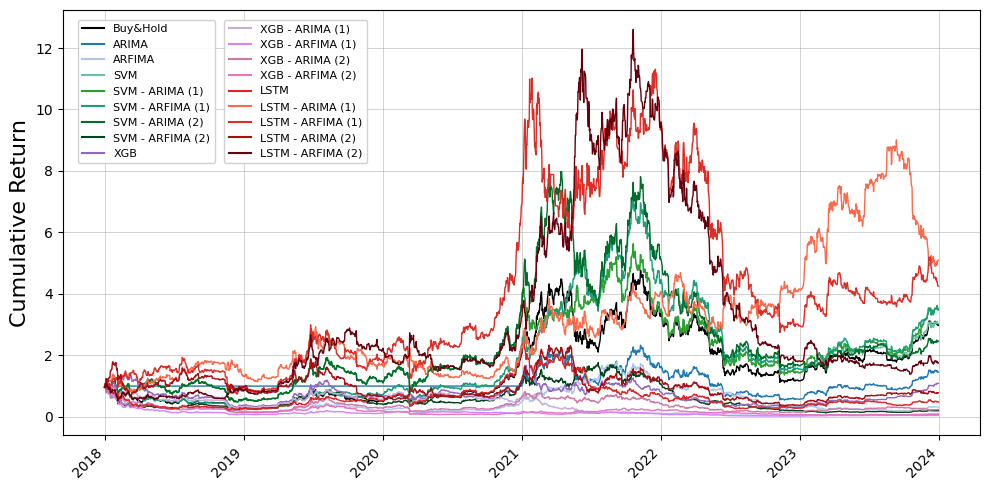

,ARIMA,ARFIMA,SVM,SVM - ARIMA (1),SVM - ARFIMA (1),SVM - ARIMA (2),SVM - ARFIMA (2),XGB,XGB - ARIMA (1),XGB - ARFIMA (1),XGB - ARIMA (2),XGB - ARFIMA (2),LSTM,LSTM - ARIMA (1),LSTM - ARFIMA (1),LSTM - ARIMA (2),LSTM - ARFIMA (2),Benchmark
Trades,1.000000,571.000000,549.000000,493.000000,533.000000,538.000000,928.000000,863.000000,591.000000,715.000000,467.000000,1049.000000,589.000000,567.000000,430.000000,475.000000,747.000000,NaN
Long Trades,1.000000,286.000000,275.000000,247.000000,267.000000,269.000000,464.000000,432.000000,296.000000,358.000000,233.000000,524.000000,295.000000,283.000000,215.000000,237.000000,374.000000,NaN
Short Trades,0.000000,285.000000,274.000000,246.000000,266.000000,269.000000,464.000000,431.000000,295.000000,357.000000,234.000000,525.000000,294.000000,284.000000,215.000000,238.000000,373.000000,NaN
Days in The Market,1094.000000,1817.000000,1862.000000,1903.000000,1865.000000,1872.000000,1646.000000,1656.000000,1844.000000,1743.000000,1905.000000,1548.000000,1828.000000,1866.000000,1915.000000,1919.000000,1693.000000,NaN
CAGR,6.414952,-17.480762,20.324934,23.317866,23.068479,16.218536,-23.706845,1.382705,-31.619827,-40.584392,-21.215515,-35.933494,-11.360920,31.190070,27.263610,-3.984938,9.764385,19.946057
ASD,45.553779,63.043497,63.043288,62.993806,64.741539,64.466654,58.593409,57.475296,63.933135,61.265869,61.821154,58.365942,61.951192,61.828753,64.714718,65.206644,62.076029,69.427681
MD,76.634564,89.388949,75.715573,75.715573,81.890496,81.266917,92.670118,84.071628,96.591173,97.614439,86.459893,94.395819,89.171319,57.710093,75.738037,84.718693,88.986210,81.532711
IR,0.140822,-0.277281,0.322396,0.370161,0.356317,0.251580,-0.404599,0.024057,-0.494577,-0.662431,-0.343176,-0.615659,-0.183385,0.504459,0.421289,-0.061112,0.157297,0.287293
Adj IR,0.011788,-0.054225,0.086543,0.113997,0.100374,0.050208,-0.103504,0.000396,-0.161903,-0.275414,-0.084208,-0.234362,-0.023364,0.272641,0.151653,-0.002875,0.017260,0.070283
SR,0.262705,-0.507576,0.614135,0.707072,0.673991,0.478043,-0.757605,0.045929,-0.894342,-1.197296,-0.635659,-1.086049,-0.341416,1.061116,0.813963,-0.121767,0.314738,0.556147


In [40]:
for i in range(1):

    print('\n')
    print(f'{i+1}')
    print('\n')
    
    df_profit_btc_costs, trades_btc_costs, long_btc_costs, short_btc_costs, days_in_market_btc_costs = calculate_profit_costs_1(list_of_dfs[i], cost = 0.001,
                             columns = models)

    
    plot_all_equity_lines_2(df = df_profit_btc_costs, columns = columns_equity, models = models, title = 'equity_3')
    print('\n')
    
    cagr_ratio_values_df = calculate_cagr(df_profit_btc_costs)
    asd_ratio_values_df = calculate_asd(df_profit_btc_costs)
    md_ratio_values_df = calculate_md(df_profit_btc_costs)
    ir_ratio_values_df = calculate_ir(df_profit_btc_costs)
    adj_ir_ratio_values_df = calculate_adj_ir(df_profit_btc_costs)
    sr_ratio_values_df = calculate_sr(df_profit_btc_costs)

    df_btc_stats = pd.DataFrame(trades_btc_costs, index = ['Trades'], columns = models, dtype = int)
    df_btc_stats = pd.concat([df_btc_stats, pd.DataFrame(long_btc_costs, index = ['Long Trades'])])
    df_btc_stats = pd.concat([df_btc_stats, pd.DataFrame(short_btc_costs, index = ['Short Trades'])])
    df_btc_stats = pd.concat([df_btc_stats, pd.DataFrame(days_in_market_btc_costs, index = ['Days in The Market'])])
    df_btc_stats = pd.concat([df_btc_stats, cagr_ratio_values_df])
    df_btc_stats = pd.concat([df_btc_stats, asd_ratio_values_df])
    df_btc_stats = pd.concat([df_btc_stats, md_ratio_values_df])
    df_btc_stats = pd.concat([df_btc_stats, ir_ratio_values_df])
    df_btc_stats = pd.concat([df_btc_stats, adj_ir_ratio_values_df])
    df_btc_stats = pd.concat([df_btc_stats, sr_ratio_values_df])

    print('\n')

    display(df_btc_stats)


In [120]:
with open('', 'wb') as f:
    
    pickle.dump(df_profit_btc_costs, f)
    pickle.dump(trades_btc_costs, f)
    pickle.dump(long_btc_costs, f)
    pickle.dump(short_btc_costs, f)
    pickle.dump(days_in_market_btc_costs, f)



1




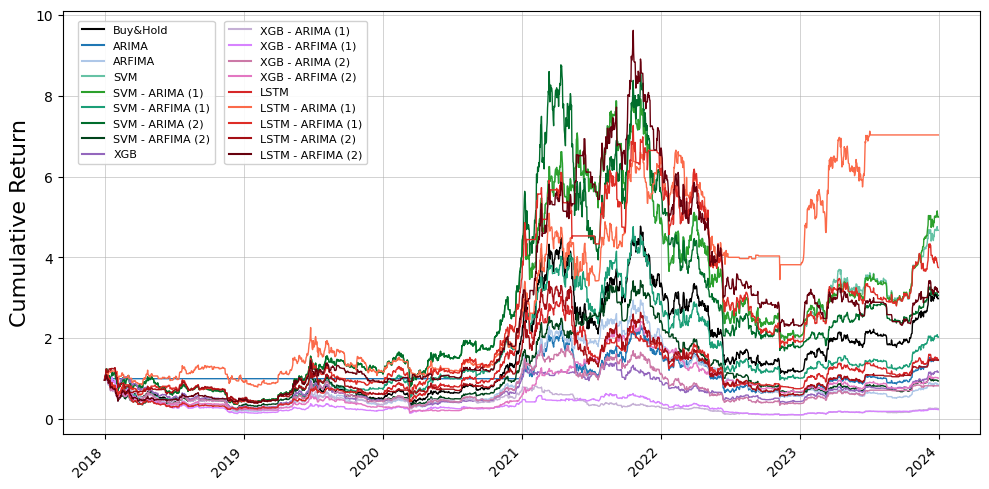

,ARIMA,ARFIMA,SVM,SVM - ARIMA (1),SVM - ARFIMA (1),SVM - ARIMA (2),SVM - ARFIMA (2),XGB,XGB - ARIMA (1),XGB - ARFIMA (1),XGB - ARIMA (2),XGB - ARFIMA (2),LSTM,LSTM - ARIMA (1),LSTM - ARFIMA (1),LSTM - ARIMA (2),LSTM - ARFIMA (2),Benchmark
Trades,1.000000,469.000000,447.000000,409.000000,439.000000,443.000000,731.000000,681.000000,463.000000,541.000000,400.000000,820.000000,449.000000,420.000000,308.000000,362.000000,567.000000,NaN
Long Trades,1.000000,235.000000,224.000000,205.000000,220.000000,222.000000,366.000000,341.000000,232.000000,271.000000,200.000000,410.000000,225.000000,210.000000,154.000000,181.000000,284.000000,NaN
Short Trades,0.000000,234.000000,223.000000,204.000000,219.000000,221.000000,365.000000,340.000000,231.000000,270.000000,200.000000,410.000000,224.000000,210.000000,154.000000,181.000000,283.000000,NaN
Days in The Market,1094.000000,1982.000000,2070.000000,2096.000000,2009.000000,2054.000000,1839.000000,1789.000000,1981.000000,1850.000000,1977.000000,1735.000000,1905.000000,1551.000000,1851.000000,1830.000000,1667.000000,NaN
CAGR,6.414952,-2.522527,29.284901,30.759773,12.496455,20.479953,-0.960859,2.512104,-20.124810,-21.446724,-3.178651,0.203231,6.641988,38.404201,24.637109,6.493859,21.006332,19.946057
ASD,45.553779,61.957498,63.387671,63.440131,63.743284,63.867402,58.703005,54.061555,60.141396,57.636763,61.960874,54.138823,59.109378,53.185342,60.159164,58.614660,54.049753,69.427681
MD,76.634564,83.644382,76.449903,76.449903,81.143689,80.738175,82.034343,77.024471,91.340453,90.786333,81.574226,84.957825,81.025665,52.801373,75.553974,83.388906,77.545094,81.532711
IR,0.140822,-0.040714,0.461997,0.484863,0.196043,0.320664,-0.016368,0.046467,-0.334625,-0.372101,-0.051301,0.003754,0.112368,0.722082,0.409532,0.110789,0.388648,0.287293
Adj IR,0.011788,-0.001228,0.176972,0.195086,0.030191,0.081339,-0.000192,0.001516,-0.073727,-0.087903,-0.001999,0.000009,0.009211,0.525195,0.133543,0.008628,0.105282,0.070283
SR,0.262705,-0.075606,0.889757,0.935681,0.369090,0.610537,-0.030076,0.084360,-0.606709,-0.678585,-0.096492,0.006795,0.208647,1.429423,0.769963,0.214367,0.763112,0.556147


In [41]:
for i in range(1):

    print('\n')
    print(f'{i+1}')
    print('\n')
    
    df_profit_btc_costs, trades_btc_costs, long_btc_costs, short_btc_costs, days_in_market_btc_costs = calculate_profit_costs_6(list_of_dfs[i], cost = 0.001,
                             columns = models)

    plot_all_equity_lines_2(df = df_profit_btc_costs, columns = columns_equity, models = models, title = 'equity_4')
    print('\n')
    
    cagr_ratio_values_df = calculate_cagr(df_profit_btc_costs)
    asd_ratio_values_df = calculate_asd(df_profit_btc_costs)
    md_ratio_values_df = calculate_md(df_profit_btc_costs)
    ir_ratio_values_df = calculate_ir(df_profit_btc_costs)
    adj_ir_ratio_values_df = calculate_adj_ir(df_profit_btc_costs)
    sr_ratio_values_df = calculate_sr(df_profit_btc_costs)

    df_btc_stats = pd.DataFrame(trades_btc_costs, index = ['Trades'], columns = models, dtype = int)
    df_btc_stats = pd.concat([df_btc_stats, pd.DataFrame(long_btc_costs, index = ['Long Trades'])])
    df_btc_stats = pd.concat([df_btc_stats, pd.DataFrame(short_btc_costs, index = ['Short Trades'])])
    df_btc_stats = pd.concat([df_btc_stats, pd.DataFrame(days_in_market_btc_costs, index = ['Days in The Market'])])
    df_btc_stats = pd.concat([df_btc_stats, cagr_ratio_values_df])
    df_btc_stats = pd.concat([df_btc_stats, asd_ratio_values_df])
    df_btc_stats = pd.concat([df_btc_stats, md_ratio_values_df])
    df_btc_stats = pd.concat([df_btc_stats, ir_ratio_values_df])
    df_btc_stats = pd.concat([df_btc_stats, adj_ir_ratio_values_df])
    df_btc_stats = pd.concat([df_btc_stats, sr_ratio_values_df])

    print('\n')
    display(df_btc_stats)


In [122]:
with open('', 'wb') as f:
    
    pickle.dump(df_profit_btc_costs, f)
    pickle.dump(trades_btc_costs, f)
    pickle.dump(long_btc_costs, f)
    pickle.dump(short_btc_costs, f)
    pickle.dump(days_in_market_btc_costs, f)